In [1]:
#@title Install libs
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

!pip install ccxt
!pip install mplfinance
!pip install pykalman

!pip install tqdm

!pip install hurst

--2024-10-16 19:53:05--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-10-16 19:53:05--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-10-16 19:53:06--  http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1
Res

In [2]:
#@title Load libs
from datetime import datetime

#from functools import reduce
#from math import sqrt
import numpy as np
import pandas as pd
#from pandas import DataFrame
from tqdm import tqdm
#from freqtrade.persistence import Trade

import talib.abstract as ta

import ccxt
import mplfinance as mpf

from pykalman import KalmanFilter


from hurst import compute_Hc



In [3]:
#@title Helping functions
'''
def get_data(exch: str, start_time: str, timeframe: str, ticker: str) -> pd.DataFrame:
    #ex = ccxt.binance()
    ex = getattr (ccxt, exch) ()
    from_ts = ex.parse8601(start_time)
    #ohlcv_list = []
    ohlcv = ex.fetch_ohlcv(ticker, timeframe, since=from_ts, limit=1000)
    #ohlcv_list.append(ohlcv)
    while True:
        from_ts = ohlcv[-1][0]+1
        new_ohlcv = ex.fetch_ohlcv(ticker, timeframe, since=from_ts, limit=1000)
        ohlcv.extend(new_ohlcv)
        if len(new_ohlcv)!=1000:
          break
    df = pd.DataFrame(ohlcv, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    df.set_index('date', inplace=True)
    df = df.sort_index(ascending=True)
    return df
'''

def get_data(exch: str, start_time: str, end_time: str, timeframe: str, ticker: str) -> pd.DataFrame:
    ex = getattr(ccxt, exch)()
    from_ts = ex.parse8601(start_time)
    to_ts = ex.parse8601(end_time)

    ohlcv = ex.fetch_ohlcv(ticker, timeframe, since=from_ts, limit=1000)
    while True:
        from_ts = ohlcv[-1][0] + 1
        new_ohlcv = ex.fetch_ohlcv(ticker, timeframe, since=from_ts, limit=1000)
        ohlcv.extend(new_ohlcv)
        if len(new_ohlcv) != 1000 or new_ohlcv[-1][0] >= to_ts:
            break

    df = pd.DataFrame(ohlcv, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    df.set_index('date', inplace=True)
    df = df.sort_index(ascending=True)
    return df


def get_kalman(data: pd.DataFrame, column_name: str, new_column_name:str) -> pd.DataFrame:
    df=data.copy()
    kf = KalmanFilter(transition_matrices = [1],
                    observation_matrices = [1],
                    initial_state_mean = 0)#,
                    #initial_state_covariance = 1,
                    #observation_covariance=1,
                    #transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(df[column_name].values)
    state_means = pd.Series(state_means.flatten(), index=df[column_name].index)

    df[new_column_name]=state_means

    return df


def check_stat(result):
    l=[]
    w=[]
    d_stat=10000
    for i in result[1]:
      if i['deposit_stat']<d_stat:
        l.append(i)
      else:
        w.append(i)
      d_stat=i['deposit_stat']
    return l, w


In [ ]:
EXCH = 'kraken' # @param ['binance','bitfinex','bytetrade','ftx','kraken','poloniex','upbit','acx','bequant','bigone','bitforex','bitkk','bitz','btcalpha','coinex','crex24','digifinex','gateio','hitbtc2','huobipro','huobiru','kucoin','lbank','okex','okex3','stex','upbit','whitebit','zb'] {allow-input: false}
START_DATE = "2024-01-01 00:00:00" #@param {type: "string"}
END_DATE = "2024-01-29 00:00:00" #@param {type: "string"}
TIMEFRAME= "1h" #@param {type: "string"}
TICKER= "BTC/USDT" #@param {type: "string"}
data = get_data(EXCH, START_DATE, END_DATE, TIMEFRAME, TICKER)
data.reset_index(inplace=True)

print(f'data len: {len(data)}')
print()
data.head()

data len: 720



date     open     high      low    close     volume
0 2024-08-30 15:00:00  58450.3  58624.3  57997.6  58095.3  34.637321
1 2024-08-30 16:00:00  58090.2  58570.0  57748.8  58513.5  29.762680
2 2024-08-30 17:00:00  58530.3  58759.4  58407.3  58652.0   2.528782
3 2024-08-30 18:00:00  58650.5  59318.3  58634.2  59318.3   4.002111
4 2024-08-30 19:00:00  59318.3  59318.3  58751.8  58753.4   3.789209

Всего сделок: 75
Успешные сделки: 50
Процент успешных сделок: 66.67%
Общая доходность: 21.13%
Максимальная прибыль: 3.44%
Максимальный убыток: -3.90%
Средняя доходность: 0.87%
Медианная доходность: 0.47%
Средний убыток: -0.90%
Медианный убыток: -0.63%
Доходность рынка за период: 12.23%
Доходность стратегии за период: 21.13%


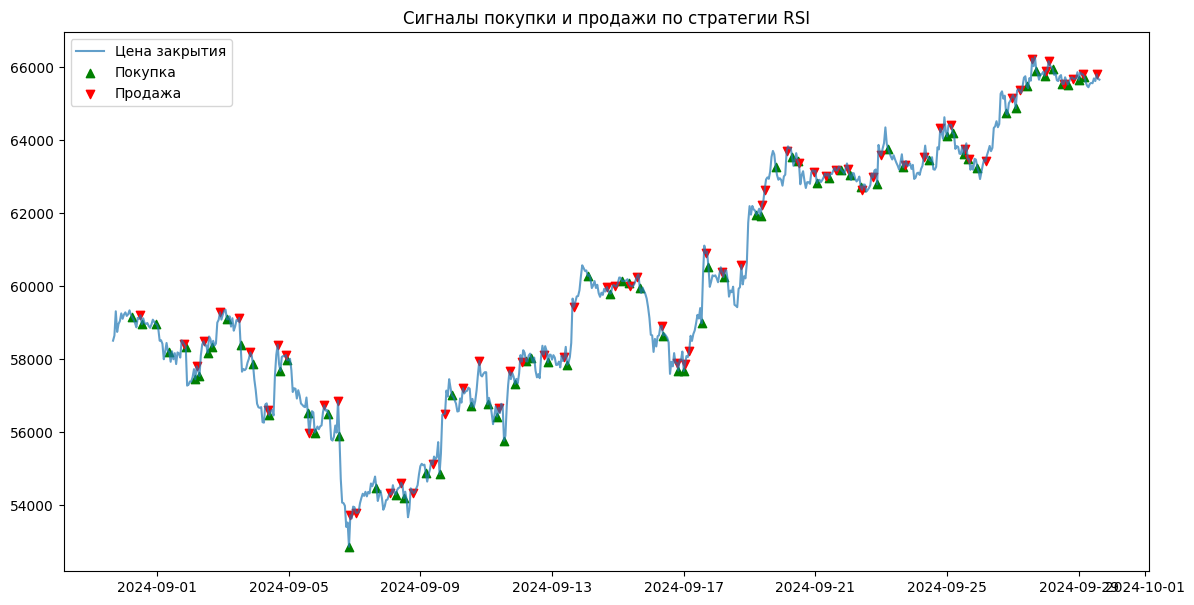

In [ ]:
import talib as ta
import pandas as pd
import numpy as np

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 36
RSI_SELL_LEVEL = 68
STOP_LOSS_RATIO = 0.045  # Стоп-лосс 0.45%
TAKE_PROFIT_RATIO = 0.03  # Тейк-профит 3%
EXIT_DELAY = 2  # Задержка выхода из позиции на N баров

# Загрузка данных (параметры можно настроить по своему усмотрению)
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        if data['RSI'][i] < RSI_BUY_LEVEL:  # Условие для покупки
            entry_price = data['close'][i]
            stop_loss = entry_price * (1 - STOP_LOSS_RATIO)
            take_profit = entry_price * (1 + TAKE_PROFIT_RATIO)
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            exit_index = min(i + EXIT_DELAY, len(data) - 1)
            exit_price = data['close'][exit_index]
            data.at[exit_index, 'signal'] = -1  # Сигнал на продажу
            data.at[exit_index, 'price_exit'] = exit_price
            data.at[exit_index, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            exit_index = min(i + EXIT_DELAY, len(data) - 1)
            exit_price = data['close'][exit_index]
            data.at[exit_index, 'signal'] = -1  # Сигнал на продажу
            data.at[exit_index, 'price_exit'] = exit_price
            data.at[exit_index, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False
        elif data['RSI'][i] > RSI_SELL_LEVEL:  # Продаем по RSI
            exit_index = min(i + EXIT_DELAY, len(data) - 1)
            exit_price = data['close'][exit_index]
            data.at[exit_index, 'signal'] = -1  # Сигнал на продажу
            data.at[exit_index, 'price_exit'] = exit_price
            data.at[exit_index, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Средняя и медианная доходность и убыток
average_profit = trades[trades['trade_result'] > 0]['trade_result'].mean()
median_profit = trades[trades['trade_result'] > 0]['trade_result'].median()
average_loss = trades[trades['trade_result'] < 0]['trade_result'].mean()
median_loss = trades[trades['trade_result'] < 0]['trade_result'].median()

print(f"Средняя доходность: {average_profit:.2f}%")
print(f"Медианная доходность: {median_profit:.2f}%")
print(f"Средний убыток: {average_loss:.2f}%")
print(f"Медианный убыток: {median_loss:.2f}%")

# Доходность рынка за период
market_return = (data['close'].iloc[-1] - data['close'].iloc[0]) / data['close'].iloc[0] * 100
strategy_return = trades['trade_result'].sum()

print(f"Доходность рынка за период: {market_return:.2f}%")
print(f"Доходность стратегии за период: {strategy_return:.2f}%")

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи по стратегии RSI')
plt.legend()
plt.show()

Всего сделок: 116
Успешные сделки: 59
Процент успешных сделок: 50.86%
Общая доходность: 12.90%
Максимальная прибыль: 2.96%
Максимальный убыток: -0.45%
Средняя доходность: 0.63%
Медианная доходность: 0.50%
Средний убыток: -0.43%
Медианный убыток: -0.45%
Доходность рынка за период: 12.31%
Доходность стратегии за период: 12.90%


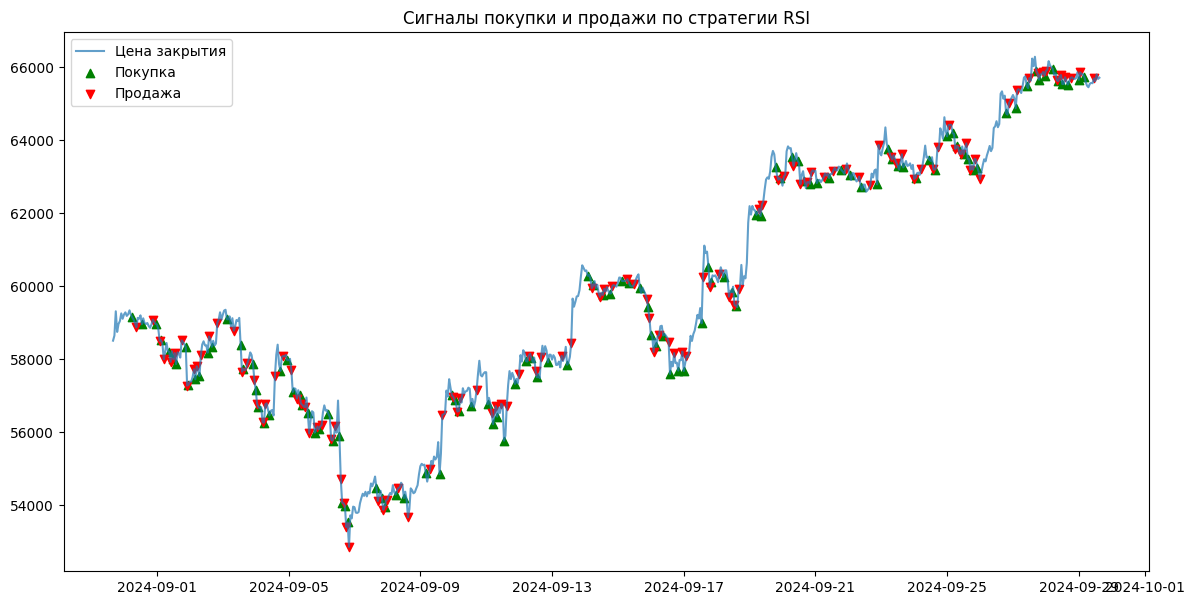

In [ ]:
import talib as ta
import pandas as pd
import numpy as np

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 36
RSI_SELL_LEVEL = 68
STOP_LOSS_RATIO = 0.0045  # Стоп-лосс 0.45%
TAKE_PROFIT_RATIO = 0.03  # Тейк-профит 3%

# Загрузка данных (параметры можно настроить по своему усмотрению)
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        if data['RSI'][i] < RSI_BUY_LEVEL:  # Условие для покупки
            entry_price = data['close'][i]
            stop_loss = entry_price * (1 - STOP_LOSS_RATIO)
            take_profit = entry_price * (1 + TAKE_PROFIT_RATIO)
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            exit_price = stop_loss
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            exit_price = take_profit
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False
        elif data['RSI'][i] > RSI_SELL_LEVEL:  # Продаем по RSI
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Средняя и медианная доходность и убыток
average_profit = trades[trades['trade_result'] > 0]['trade_result'].mean()
median_profit = trades[trades['trade_result'] > 0]['trade_result'].median()
average_loss = trades[trades['trade_result'] < 0]['trade_result'].mean()
median_loss = trades[trades['trade_result'] < 0]['trade_result'].median()

print(f"Средняя доходность: {average_profit:.2f}%")
print(f"Медианная доходность: {median_profit:.2f}%")
print(f"Средний убыток: {average_loss:.2f}%")
print(f"Медианный убыток: {median_loss:.2f}%")

# Доходность рынка за период
market_return = (data['close'].iloc[-1] - data['close'].iloc[0]) / data['close'].iloc[0] * 100
strategy_return = trades['trade_result'].sum()

print(f"Доходность рынка за период: {market_return:.2f}%")
print(f"Доходность стратегии за период: {strategy_return:.2f}%")

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи по стратегии RSI')
plt.legend()
plt.show()

Всего сделок: 81
Успешные сделки: 48
Процент успешных сделок: 59.26%
Общая доходность: 17.43%
Максимальная прибыль: 4.17%
Максимальный убыток: -3.43%
Средняя доходность: 0.83%
Медианная доходность: 0.61%
Средний убыток: -0.67%
Медианный убыток: -0.43%
Доходность рынка за период: 12.33%
Доходность стратегии за период: 17.43%


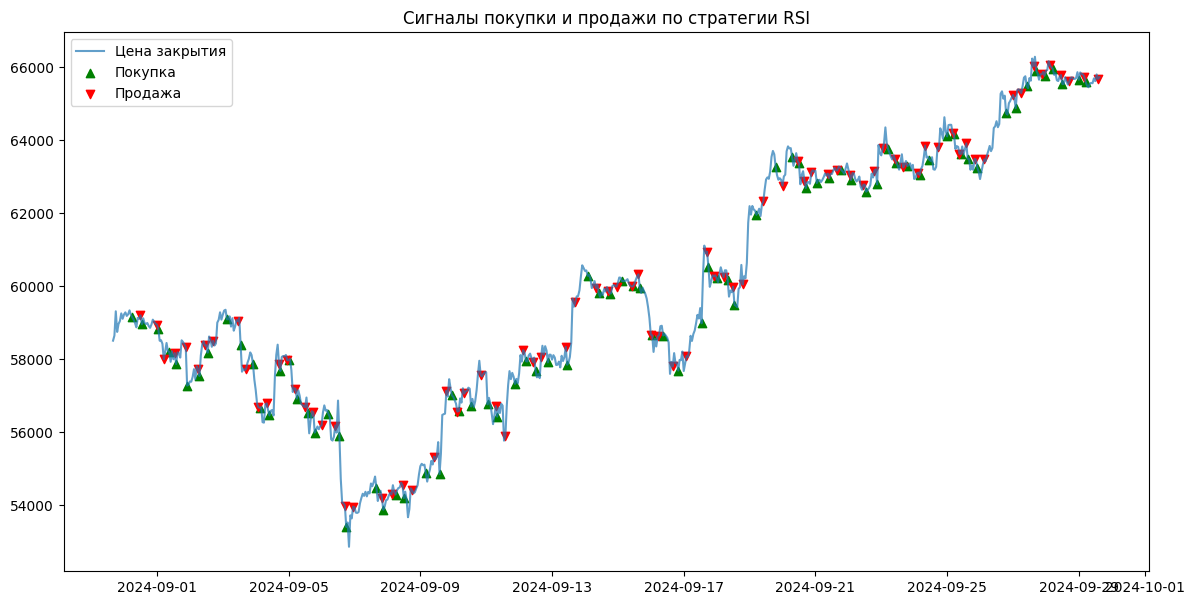

In [ ]:
import talib as ta
import pandas as pd
import numpy as np

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 36
RSI_SELL_LEVEL = 68
STOP_LOSS_RATIO = 0.0045  # Стоп-лосс 0.45%
TAKE_PROFIT_RATIO = 0.03  # Тейк-профит 3%
EXIT_DELAY = 3  # Задержка выхода из позиции на N баров

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0
data['price_entry'] = np.nan
data['price_exit'] = np.nan
data['trade_result'] = np.nan

# Статусы для управления сделками
in_position = False
entry_price = 0
exit_signal = None
exit_price = 0
exit_bar = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:
        if data['RSI'][i] < RSI_BUY_LEVEL:
            entry_price = data['close'][i]
            stop_loss = entry_price * (1 - STOP_LOSS_RATIO)
            take_profit = entry_price * (1 + TAKE_PROFIT_RATIO)
            data.at[i, 'signal'] = 1
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:
        if exit_signal is None:
            if data['low'][i] <= stop_loss:
                exit_signal = 'stop_loss'
                exit_price = stop_loss
                exit_bar = i + EXIT_DELAY
            elif data['high'][i] >= take_profit:
                exit_signal = 'take_profit'
                exit_price = take_profit
                exit_bar = i + EXIT_DELAY
            elif data['RSI'][i] > RSI_SELL_LEVEL:
                exit_signal = 'RSI'
                exit_price = data['close'][i]
                exit_bar = i + EXIT_DELAY

        if exit_signal is not None and i >= exit_bar:
            data.at[i, 'signal'] = -1
            data.at[i, 'price_exit'] = data['close'][i]
            data.at[i, 'trade_result'] = (data['close'][i] - entry_price) / entry_price * 100
            in_position = False
            exit_signal = None

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Средняя и медианная доходность и убыток
average_profit = trades[trades['trade_result'] > 0]['trade_result'].mean()
median_profit = trades[trades['trade_result'] > 0]['trade_result'].median()
average_loss = trades[trades['trade_result'] < 0]['trade_result'].mean()
median_loss = trades[trades['trade_result'] < 0]['trade_result'].median()

print(f"Средняя доходность: {average_profit:.2f}%")
print(f"Медианная доходность: {median_profit:.2f}%")
print(f"Средний убыток: {average_loss:.2f}%")
print(f"Медианный убыток: {median_loss:.2f}%")

# Доходность рынка за период
market_return = (data['close'].iloc[-1] - data['close'].iloc[0]) / data['close'].iloc[0] * 100
strategy_return = trades['trade_result'].sum()

print(f"Доходность рынка за период: {market_return:.2f}%")
print(f"Доходность стратегии за период: {strategy_return:.2f}%")

# Визуализация
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи по стратегии RSI')
plt.legend()
plt.show()

Всего сделок: 2
Успешные сделки: 0
Процент успешных сделок: 0.00%
Общая доходность: -2.36%
Максимальная прибыль: -0.86%
Максимальный убыток: -1.50%
Средняя доходность: nan%
Медианная доходность: nan%
Средний убыток: -1.18%
Медианный убыток: -1.18%
Доходность рынка за период: 12.02%
Доходность стратегии за период: -2.36%


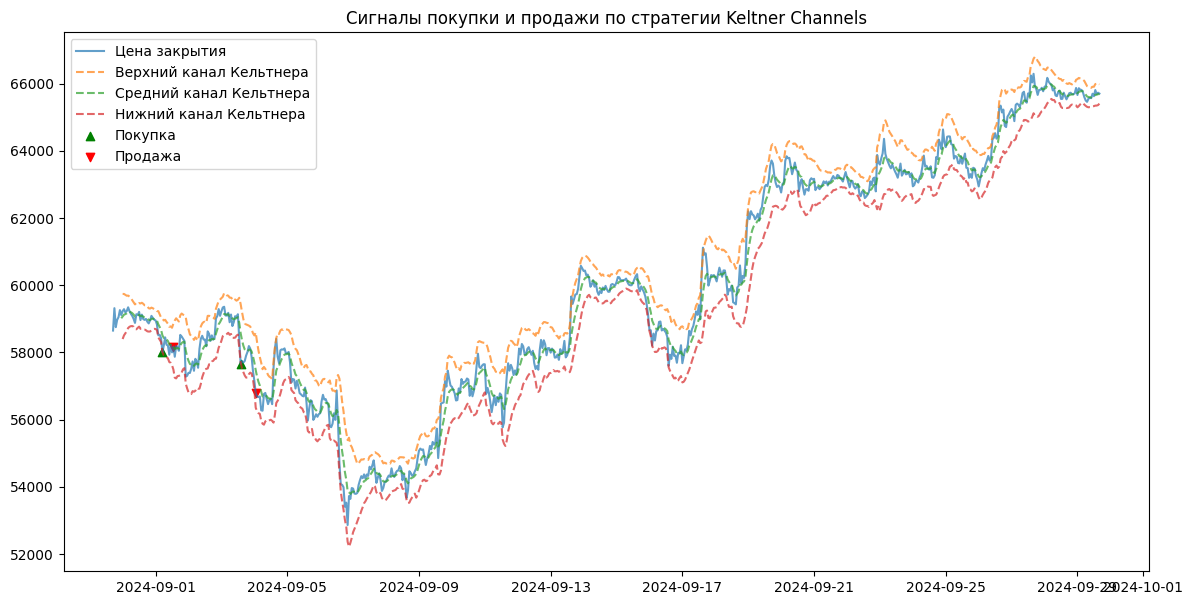

In [ ]:
import talib as ta
import pandas as pd
import numpy as np

# Параметры стратегии
KELTNER_PERIOD = 7  # Период для расчета каналов Кельтнера
STOP_LOSS_MULTIPLIER = 2  # Множитель для ATR при расчете стоп-лосса
TAKE_PROFIT_MULTIPLIER = 4  # Множитель для ATR при расчете тейк-профита

# Загрузка данных (параметры можно настроить по своему усмотрению)
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=KELTNER_PERIOD)

# Рассчитываем каналы Кельтнера
data['keltn_channel_middle'] = ta.EMA(data['close'], timeperiod=KELTNER_PERIOD)
data['keltn_channel_upper'] = data['keltn_channel_middle'] + STOP_LOSS_MULTIPLIER * data['ATR']
data['keltn_channel_lower'] = data['keltn_channel_middle'] - STOP_LOSS_MULTIPLIER * data['ATR']

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0
stop_loss = 0
take_profit = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        if data['close'][i] < data['keltn_channel_lower'][i]:  # Условие для покупки
            entry_price = data['close'][i]
            stop_loss = entry_price - STOP_LOSS_MULTIPLIER * data['ATR'][i]
            take_profit = entry_price + TAKE_PROFIT_MULTIPLIER * data['ATR'][i]
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            exit_price = stop_loss
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            exit_price = take_profit
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False
        elif data['close'][i] > data['keltn_channel_upper'][i]:  # Продаем по верхней полосе Кельтнера
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Средняя и медианная доходность и убыток
average_profit = trades[trades['trade_result'] > 0]['trade_result'].mean()
median_profit = trades[trades['trade_result'] > 0]['trade_result'].median()
average_loss = trades[trades['trade_result'] < 0]['trade_result'].mean()
median_loss = trades[trades['trade_result'] < 0]['trade_result'].median()

print(f"Средняя доходность: {average_profit:.2f}%")
print(f"Медианная доходность: {median_profit:.2f}%")
print(f"Средний убыток: {average_loss:.2f}%")
print(f"Медианный убыток: {median_loss:.2f}%")

# Доходность рынка за период
market_return = (data['close'].iloc[-1] - data['close'].iloc[0]) / data['close'].iloc[0] * 100
strategy_return = trades['trade_result'].sum()

print(f"Доходность рынка за период: {market_return:.2f}%")
print(f"Доходность стратегии за период: {strategy_return:.2f}%")

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
plt.plot(data['date'], data['keltn_channel_upper'], label='Верхний канал Кельтнера', linestyle='--', alpha=0.7)
plt.plot(data['date'], data['keltn_channel_middle'], label='Средний канал Кельтнера', linestyle='--', alpha=0.7)
plt.plot(data['date'], data['keltn_channel_lower'], label='Нижний канал Кельтнера', linestyle='--', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи по стратегии Keltner Channels')
plt.legend()
plt.show()

Total number of OHLCV data points fetched: 720
Всего сделок: 132
Успешные сделки: 64
Процент успешных сделок: 48.48%
Общая доходность: 15.14%
Максимальная прибыль: 2.91%
Максимальный убыток: -1.29%


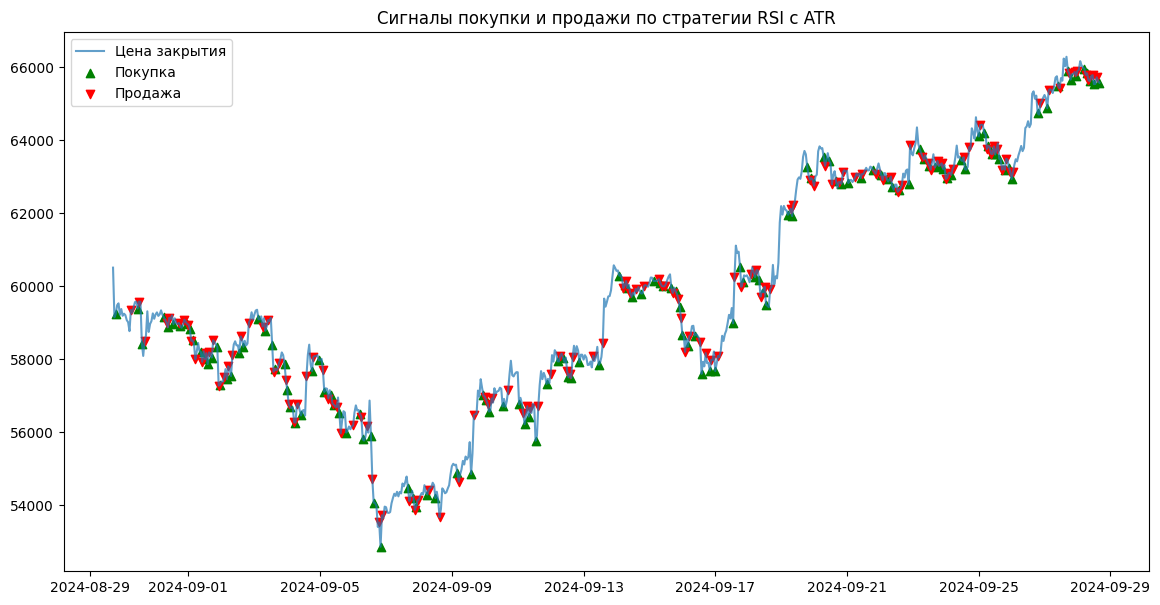

In [ ]:
#@title RSI 2 + ATR // buy 35 sell 65
import talib as ta
import pandas as pd
import numpy as np

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 36
RSI_SELL_LEVEL = 65
ATR_PERIOD = 2  # Период ATR для расчета волатильности
ATR_MULTIPLIER_SL = 0.6 # Множитель для стоп-лосса
ATR_MULTIPLIER_TP = 2.5  # Множитель для тейк-профита

# Загрузка данных (параметры можно настроить по своему усмотрению)
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем ATR для динамических стоп-лоссов и тейк-профитов
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        if data['RSI'][i] < RSI_BUY_LEVEL:  # Условие для покупки
            entry_price = data['close'][i]
            atr_value = data['ATR'][i]  # Текущее значение ATR
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        elif data['RSI'][i] > RSI_SELL_LEVEL:  # Продаем по RSI
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи по стратегии RSI с ATR')
plt.legend()
plt.show()

Total number of OHLCV data points fetched: 720
Всего сделок: 43
Успешные сделки: 17
Процент успешных сделок: 39.53%
Общая доходность: 5.95%
Максимальная прибыль: 2.96%
Максимальный убыток: -0.90%


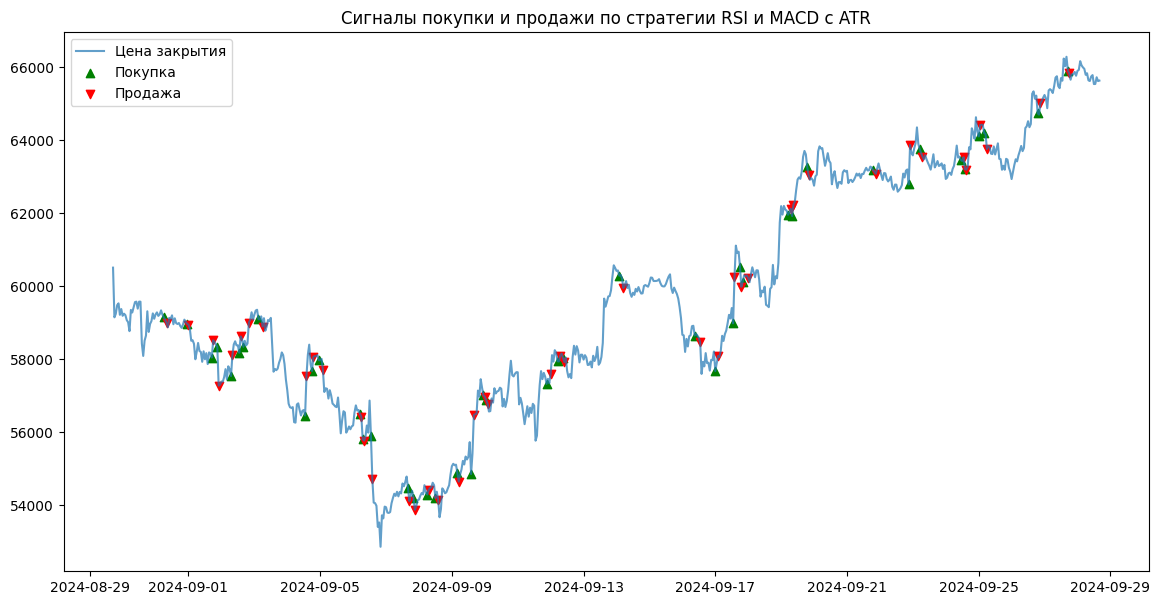

In [ ]:
#@title RSI 2 + MACD + ATR Kalman // buy 35 sell 65
import talib as ta
import pandas as pd
import numpy as np

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 36
RSI_SELL_LEVEL = 65
ATR_PERIOD = 2  # Период ATR для расчета волатильности
ATR_MULTIPLIER_SL = 0.55  # Множитель для стоп-лосса
ATR_MULTIPLIER_TP = 2.9  # Множитель для тейк-профита

# Параметры MACD
MACD_FAST = 12  # Период для быстрой EMA
MACD_SLOW = 26  # Период для медленной EMA
MACD_SIGNAL = 7  # Период для сигнальной линии

# Загрузка данных (параметры можно настроить по своему усмотрению)
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем индикаторы RSI, ATR и MACD
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)
data['MACD'], data['MACD_signal'], _ = ta.MACD(data['close'], fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIGNAL)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и MACD выше сигнальной линии
        if data['RSI'][i] < RSI_BUY_LEVEL and data['MACD'][i] > data['MACD_signal'][i]:
            entry_price = data['close'][i]
            atr_value = data['ATR'][i]  # Текущее значение ATR
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем по RSI или если MACD ниже сигнальной линии
        elif data['RSI'][i] > RSI_SELL_LEVEL or data['MACD'][i] < data['MACD_signal'][i]:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи по стратегии RSI и MACD с ATR')
plt.legend()
plt.show()

Total number of OHLCV data points fetched: 720
Всего сделок: 69
Успешные сделки: 45
Процент успешных сделок: 65.22%
Общая доходность: 14.35%
Максимальная прибыль: 2.96%
Максимальный убыток: -2.14%


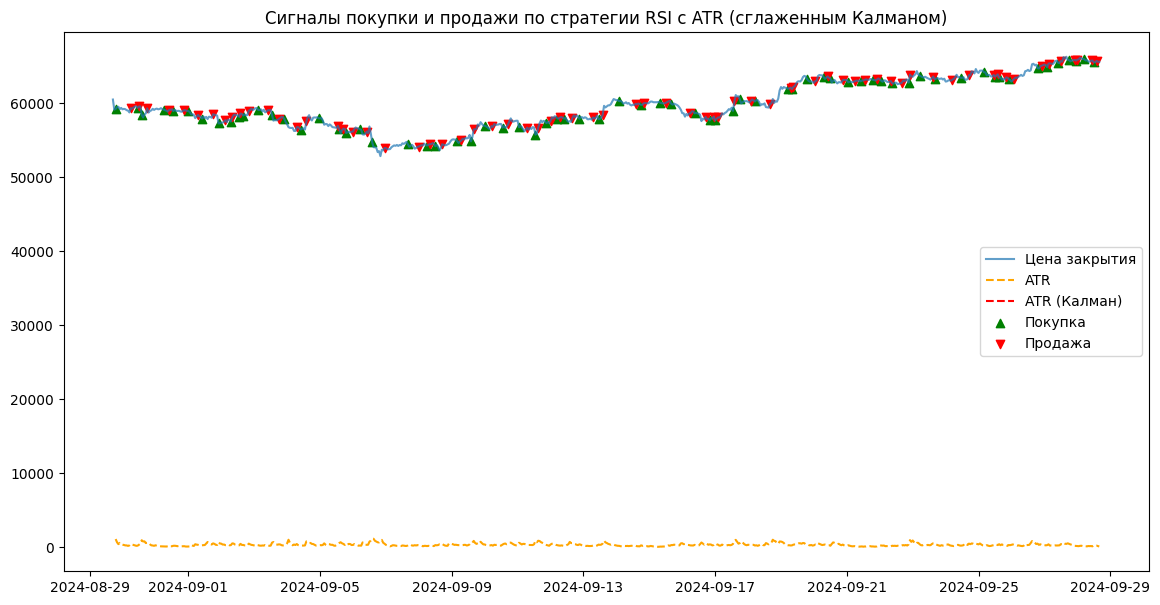

In [ ]:
import talib as ta
import pandas as pd
import numpy as np
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 31
RSI_SELL_LEVEL = 69
ATR_PERIOD = 2  # Период ATR для расчета волатильности
ATR_MULTIPLIER_SL = 0.55  # Множитель для стоп-лосса
ATR_MULTIPLIER_TP = 3  # Множитель для тейк-профита

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных (параметры можно настроить по своему усмотрению)
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем стандартный RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем стандартный ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_kalman'] = apply_kalman_filter(data['ATR'].values)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки
        if data['RSI'][i] < RSI_BUY_LEVEL:
            entry_price = data['close'][i]
            atr_value = data['ATR_kalman'][i]  # Сглаженное значение ATR
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем по RSI
        elif data['RSI'][i] > RSI_SELL_LEVEL:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
plt.plot(data['date'], data['ATR'], label='ATR', linestyle='--', color='orange')
plt.plot(data['date'], data['ATR_kalman'], label='ATR (Калман)', linestyle='--', color='red')
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи по стратегии RSI с ATR (сглаженным Калманом)')
plt.legend()
plt.show()

Total number of OHLCV data points fetched: 720
Всего сделок: 57
Успешные сделки: 44
Процент успешных сделок: 77.19%
Общая доходность: 15.62%
Максимальная прибыль: 1.92%
Максимальный убыток: -1.91%


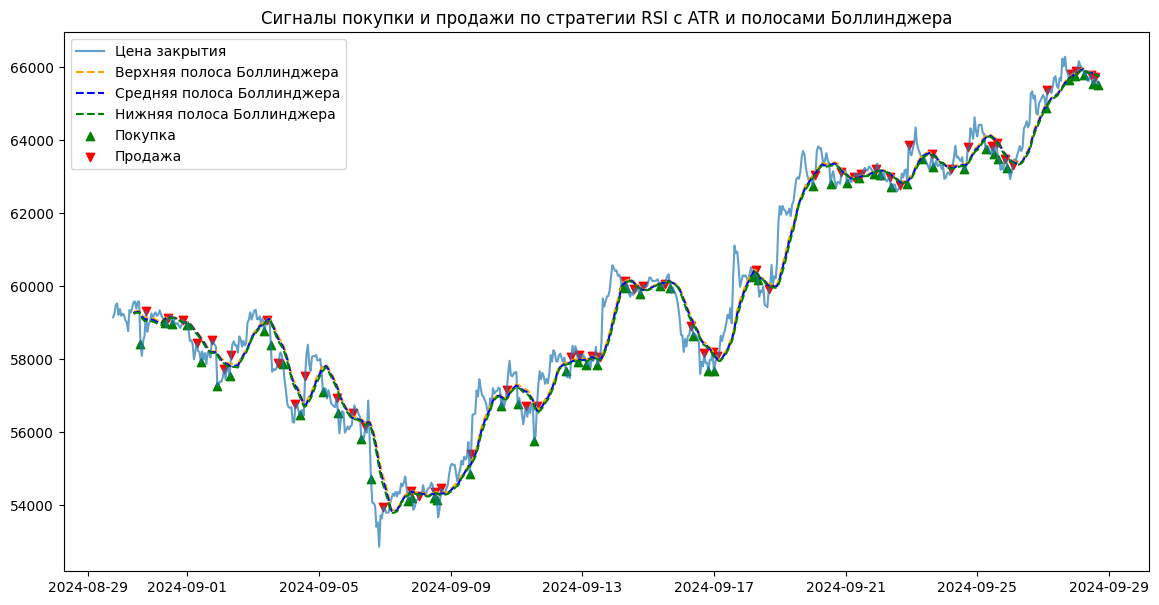

In [ ]:
#@title RSI 2 + Bollinger bands + ATR Kalman // buy 35 sell 65
import talib as ta
import pandas as pd
import numpy as np
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 32
RSI_SELL_LEVEL = 71
ATR_PERIOD = 2  # Период ATR для расчета волатильности
ATR_MULTIPLIER_SL = 0.6  # Множитель для стоп-лосса
ATR_MULTIPLIER_TP = 2.5  # Множитель для тейк-профита
BBANDS_PERIOD = 16  # Период для расчета полос Боллинджера
BBANDS_STDDEV = 0.1  # Стандартное отклонение для полос Боллинджера

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных (параметры можно настроить по своему усмотрению)
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем стандартный RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем стандартный ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_kalman'] = apply_kalman_filter(data['ATR'].values)

# Рассчитываем полосы Боллинджера
data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['close'], timeperiod=BBANDS_PERIOD, nbdevup=BBANDS_STDDEV, nbdevdn=BBANDS_STDDEV, matype=0)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и цена касается нижней полосы Боллинджера
        if data['RSI'][i] < RSI_BUY_LEVEL and data['close'][i] <= data['BB_lower'][i]:
            entry_price = data['close'][i]
            atr_value = data['ATR_kalman'][i]  # Сглаженное значение ATR
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем, если RSI выше уровня продажи или если цена касается верхней полосы Боллинджера
        elif data['RSI'][i] > RSI_SELL_LEVEL or data['close'][i] >= data['BB_upper'][i]:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
plt.plot(data['date'], data['BB_upper'], label='Верхняя полоса Боллинджера', linestyle='--', color='orange')
plt.plot(data['date'], data['BB_middle'], label='Средняя полоса Боллинджера', linestyle='--', color='blue')
plt.plot(data['date'], data['BB_lower'], label='Нижняя полоса Боллинджера', linestyle='--', color='green')
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи по стратегии RSI с ATR и полосами Боллинджера')
plt.legend()
plt.show()

Total number of OHLCV data points fetched: 720
Всего сделок: 132
Успешные сделки: 64
Процент успешных сделок: 48.48%
Общая доходность: 15.14%
Максимальная прибыль: 2.91%
Максимальный убыток: -1.29%


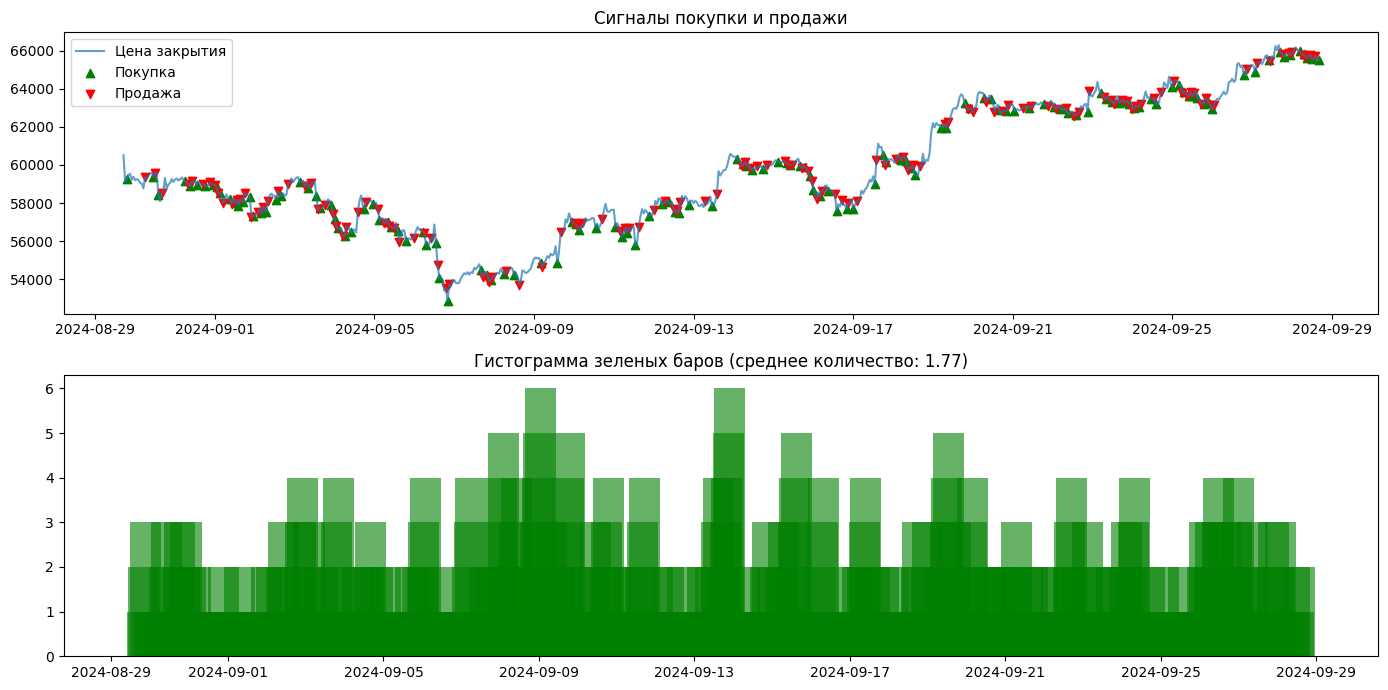

In [ ]:
#@title RSI 2 + ATR Kalman  // Green bars length
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 36
RSI_SELL_LEVEL = 65
ATR_PERIOD = 2  # Период ATR для расчета волатильности
ATR_MULTIPLIER_SL = 0.6  # Множитель для стоп-лосса
ATR_MULTIPLIER_TP = 2.5  # Множитель для тейк-профита

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем стандартный RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем стандартный ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки
        if data['RSI'][i] < RSI_BUY_LEVEL:
            entry_price = data['close'][i]
            atr_value = data['ATR'][i]  # Значение ATR
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем по RSI
        elif data['RSI'][i] > RSI_SELL_LEVEL:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Рассчитываем прибыльные (зеленые) бары
data['profit_bar'] = data['close'] > data['close'].shift(1)

# Находим последовательности прибыльных баров
data['green_streak'] = (data['profit_bar'] != data['profit_bar'].shift(1)).cumsum()
green_streak_lengths = data.groupby('green_streak')['profit_bar'].cumsum()

# Рассчитываем среднюю длину последовательности зеленых баров
avg_green_length = green_streak_lengths[data['profit_bar']].mean()

# Создаем гистограмму с количеством зеленых баров за последние N (средняя длина) периодов
data['green_histogram'] = green_streak_lengths.rolling(window=int(avg_green_length)).sum()

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.subplot(2, 1, 1)
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи')
plt.legend()

# Гистограмма зеленых баров
plt.subplot(2, 1, 2)
plt.bar(data['date'], data['green_histogram'], color='green', alpha=0.6)
plt.title(f'Гистограмма зеленых баров (среднее количество: {avg_green_length:.2f})')

plt.tight_layout()
plt.show()

Total number of OHLCV data points fetched: 720
Всего сделок: 132
Успешные сделки: 64
Процент успешных сделок: 48.48%
Общая доходность: 15.14%
Максимальная прибыль: 2.91%
Максимальный убыток: -1.29%
Среднее количество зеленых баров после покупки: 1.04


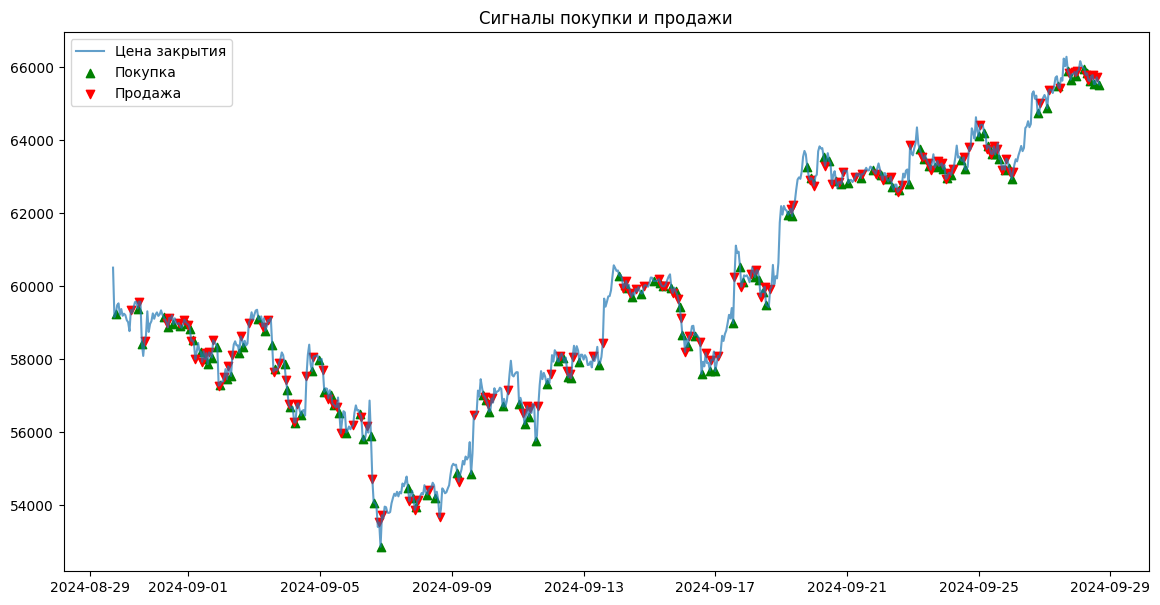

In [ ]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 36
RSI_SELL_LEVEL = 65
ATR_PERIOD = 2  # Период ATR для расчета волатильности
ATR_MULTIPLIER_SL = 0.6  # Множитель для стоп-лосса
ATR_MULTIPLIER_TP = 2.5  # Множитель для тейк-профита

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем стандартный RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем стандартный ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки
        if data['RSI'][i] < RSI_BUY_LEVEL:
            entry_price = data['close'][i]
            atr_value = data['ATR'][i]  # Значение ATR
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем по RSI
        elif data['RSI'][i] > RSI_SELL_LEVEL:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Рассчитываем прибыльные (зеленые) бары
data['profit_bar'] = data['close'] > data['close'].shift(1)

# Находим промежутки с зелеными барами после покупки
green_bars_after_buy = []
for i in range(1, len(data)):
    if data['signal'][i] == 1:  # Найден сигнал на покупку
        green_count = 0
        for j in range(i + 1, len(data)):
            if data['profit_bar'][j]:  # Если бар зеленый (прибыльный)
                green_count += 1
            else:
                break  # Если встречаем красный бар, прерываем подсчет
        green_bars_after_buy.append(green_count)

# Рассчитываем среднее количество зеленых баров после покупки
avg_green_bars_after_buy = np.mean(green_bars_after_buy) if green_bars_after_buy else 0

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")
print(f"Среднее количество зеленых баров после покупки: {avg_green_bars_after_buy:.2f}")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи')
plt.legend()

plt.show()

Total number of OHLCV data points fetched: 720
Всего сделок: 20
Успешные сделки: 14
Процент успешных сделок: 70.00%
Общая доходность: 18.41%
Максимальная прибыль: 4.59%
Максимальный убыток: -1.92%


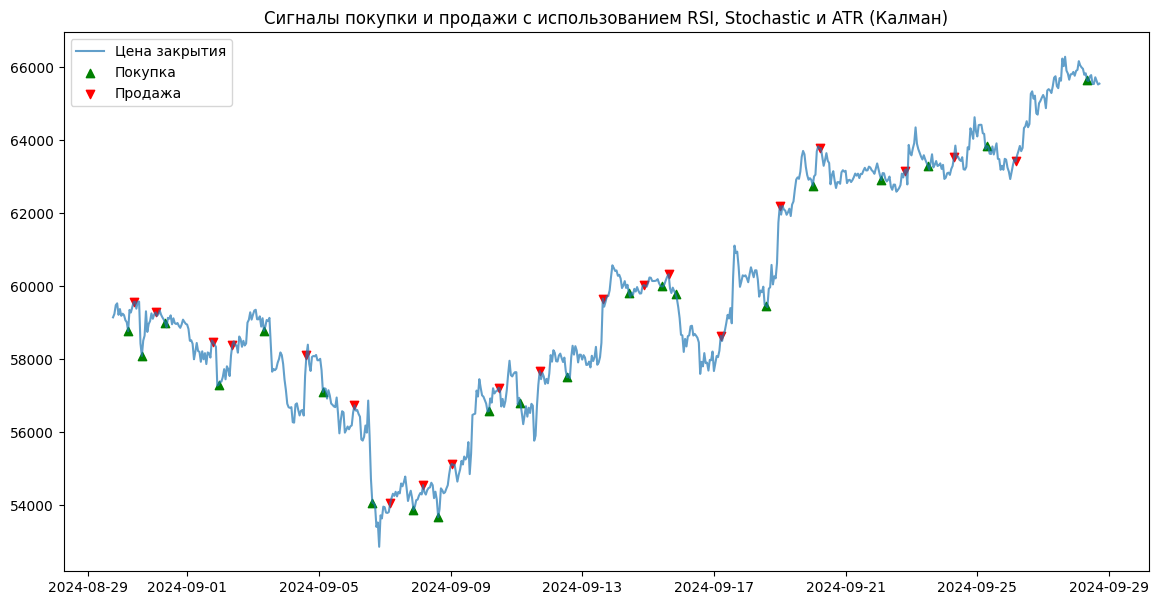

In [ ]:
#@title RSI 2 + Stochastic + ATR Kalman // buy 35 sell 65
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 35
RSI_SELL_LEVEL = 66
STOCH_K_PERIOD = 10  # Период для K линии стохастика
STOCH_D_PERIOD = 2   # Период для D линии стохастика
STOCH_OVERBOUGHT = 75
STOCH_OVERSOLD = 25
ATR_PERIOD = 2  # Период ATR для расчета волатильности
ATR_MULTIPLIER_SL = 0.6  # Множитель для стоп-лосса
ATR_MULTIPLIER_TP = 2.5  # Множитель для тейк-профита

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем стохастик
data['STOCH_K'], data['STOCH_D'] = ta.STOCH(data['high'], data['low'], data['close'],
                                             fastk_period=STOCH_K_PERIOD,
                                             slowk_period=STOCH_D_PERIOD,
                                             slowk_matype=0,
                                             slowd_period=STOCH_D_PERIOD,
                                             slowd_matype=0)

# Рассчитываем стандартный ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и стохастик показывает перепроданность
        if data['RSI'][i] < RSI_BUY_LEVEL and data['STOCH_K'][i] < STOCH_OVERSOLD and data['STOCH_D'][i] < STOCH_OVERSOLD:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем, если RSI выше уровня продажи и стохастик показывает перекупленность
        elif data['RSI'][i] > RSI_SELL_LEVEL and data['STOCH_K'][i] > STOCH_OVERBOUGHT and data['STOCH_D'][i] > STOCH_OVERBOUGHT:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI, Stochastic и ATR (Калман)')
plt.legend()

plt.show()

In [ ]:
data

date     open     high      low    close     volume  \
0   2024-09-09 12:00:00  55266.0  55351.6  54998.5  55330.2  11.078901   
1   2024-09-09 13:00:00  55330.3  55750.0  55250.1  55733.1  10.666123   
2   2024-09-09 14:00:00  55733.1  55733.1  54857.2  54857.2  21.453873   
3   2024-09-09 15:00:00  54835.5  55458.6  54835.5  55418.5  19.340486   
4   2024-09-09 16:00:00  55387.1  56489.9  55383.0  56478.3  20.982238   
..                  ...      ...      ...      ...      ...        ...   
715 2024-10-09 07:00:00  62421.7  62421.7  62198.4  62272.6   2.466418   
716 2024-10-09 08:00:00  62274.0  62277.7  62055.7  62108.6   9.429089   
717 2024-10-09 09:00:00  62147.5  62268.3  62104.8  62268.3   4.884672   
718 2024-10-09 10:00:00  62257.7  62257.7  62056.0  62143.7   6.890957   
719 2024-10-09 11:00:00  62144.2  62144.2  62142.9  62142.9   0.000701   

         RSI_1  STOCH_K_1  STOCH_D_1      RSI_2  ...         ATR  ATR_Kalman  \
0          NaN        NaN        NaN        NaN  ...         NaN         NaN   
1          NaN        NaN        NaN        NaN  ...         NaN         NaN   
2    31.506099        NaN        NaN  31.506099  ...  687.900000         NaN   
3    63.525443        NaN        NaN  63.525443  ...  655.500000         NaN   
4    86.809927        NaN        NaN  86.809927  ...  881.200000         NaN   
..         ...        ...        ...        ...  ...         ...         ...   
715  19.100156  60.890302  71.172403  19.100156  ...  190.478444         NaN   
716   7.760134  30.027822  45.459062   7.760134  ...  206.239222         NaN   
717  57.222951  29.600556  29.814189  57.222951  ...  184.869611         NaN   
718  31.154210  31.769407  30.684982  31.154210  ...  198.584806         NaN   
719  30.973020  17.987680  24.878543  30.973020  ...   99.942403         NaN   

     signal_1  signal_2  price_entry_1  price_entry_2  price_exit_1  \
0           0         0            NaN            NaN           NaN   
1           0         0            NaN            NaN           NaN   
2           0         0            NaN            NaN           NaN   
3           0         0            NaN            NaN           NaN   
4           0         0            NaN            NaN           NaN   
..        ...       ...            ...            ...           ...   
715         0         1            NaN        62272.6           NaN   
716         0         0            NaN            NaN           NaN   
717         0         0            NaN            NaN           NaN   
718         0         0            NaN            NaN           NaN   
719         1         0        62142.9            NaN           NaN   

     price_exit_2  trade_result_1  trade_result_2  
0             NaN             NaN             NaN  
1             NaN             NaN             NaN  
2             NaN             NaN             NaN  
3             NaN             NaN             NaN  
4             NaN             NaN             NaN  
..            ...             ...             ...  
715           NaN             NaN             NaN  
716           NaN             NaN             NaN  
717           NaN             NaN             NaN  
718           NaN             NaN             NaN  
719           NaN             NaN             NaN  

[720 rows x 23 columns]

In [ ]:
dd

array([[10,  1,  2],
       [10,  3,  4],
       [10,  5,  6],
       [10,  7,  8]])

Всего сделок: 54
Успешные сделки: 43
Процент успешных сделок: 79.63%
Текущий капитал: 12570.38 USD
Общая доходность: 25.70%
Максимальная прибыль: 4.59%
Максимальный убыток: -3.09%


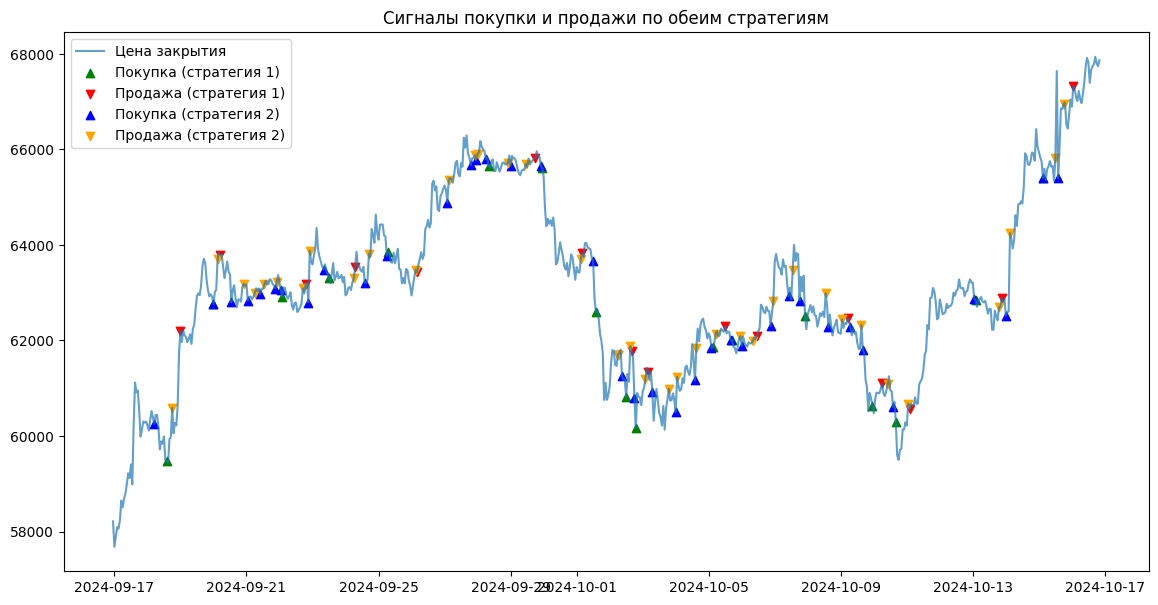

In [29]:
#@title 2 Both Strategy
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD_1 = 2
RSI_BUY_LEVEL_1 = 35
RSI_SELL_LEVEL_1 = 66

STOCH_K_PERIOD = 10  # Период для K линии стохастика
STOCH_D_PERIOD = 2   # Период для D линии стохастика
STOCH_OVERBOUGHT = 75
STOCH_OVERSOLD = 25

# Параметры второй стратегии
RSI_PERIOD_2 = 2
RSI_BUY_LEVEL_2 = 32
RSI_SELL_LEVEL_2 = 71

BBANDS_PERIOD = 16  # Период для расчета полос Боллинджера
BBANDS_STDDEV = 0.1  # Стандартное отклонение для полос Боллинджера

# Общие параметры для обеих стратегий
ATR_PERIOD = 2  # Период ATR для расчета волатильности
ATR_MULTIPLIER_SL = 0.6  # Множитель для стоп-лосса
ATR_MULTIPLIER_TP = 2.5  # Множитель для тейк-профита

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data.values)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI для 1-й стратегии
data['RSI_1'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD_1)

# Рассчитываем стохастик для 1-й стратегии
data['STOCH_K_1'], data['STOCH_D_1'] = ta.STOCH(data['high'], data['low'], data['close'],
                                                 fastk_period=STOCH_K_PERIOD,
                                                 slowk_period=STOCH_D_PERIOD,
                                                 slowk_matype=0,
                                                 slowd_period=STOCH_D_PERIOD,
                                                 slowd_matype=0)

# Рассчитываем RSI для 2-й стратегии
data['RSI_2'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD_2)

# Рассчитываем полосы Боллинджера для 2-й стратегии
data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['close'], timeperiod=BBANDS_PERIOD, nbdevup=BBANDS_STDDEV, nbdevdn=BBANDS_STDDEV, matype=0)

# Рассчитываем стандартный ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)
#data.dropna(inplace=True)
data=data.iloc[2:].copy()
# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = np.nan #apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal_1'] = 0  # 1-я стратегия: покупка = 1, продажа = -1
data['signal_2'] = 0  # 2-я стратегия: покупка = 1, продажа = -1
data['price_entry_1'] = np.nan  # Цена входа для 1-й стратегии
data['price_entry_2'] = np.nan  # Цена входа для 2-й стратегии
data['price_exit_1'] = np.nan   # Цена выхода для 1-й стратегии
data['price_exit_2'] = np.nan   # Цена выхода для 2-й стратегии
data['trade_result_1'] = np.nan  # Результат сделки для 1-й стратегии
data['trade_result_2'] = np.nan  # Результат сделки для 2-й стратегии

# Статусы для управления сделками
in_position_1 = False
in_position_2 = False
entry_price_1 = 0
entry_price_2 = 0
stop_loss = np.nan  # Общий стоп-лосс для обеих стратегий
take_profit = np.nan  # Общий тейк-профит для обеих стратегий

# Начальный капитал
initial_capital = 10000  # 10,000 USD
current_capital = initial_capital

# Логика для 1-й стратегии
for i in range(2, len(data)):
    if not in_position_1:  # Если мы не в позиции по 1-й стратегии
        # Условие для покупки: RSI ниже уровня покупки и стохастик показывает перепроданность
        if data['RSI_1'][i] < RSI_BUY_LEVEL_1 and data['STOCH_K_1'][i] < STOCH_OVERSOLD and data['STOCH_D_1'][i] < STOCH_OVERSOLD:
            entry_price_1 = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price_1 - ATR_MULTIPLIER_SL * atr_value  # Общий стоп-лосс
            take_profit = entry_price_1 + ATR_MULTIPLIER_TP * atr_value  # Общий тейк-профит
            data.at[i, 'signal_1'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry_1'] = entry_price_1
            in_position_1 = True
    else:  # Если мы в позиции по 1-й стратегии
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal_1'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit_1'] = stop_loss
            trade_return = (stop_loss - entry_price_1) / entry_price_1 * 100
            data.at[i, 'trade_result_1'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_1 = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal_1'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit_1'] = take_profit
            trade_return = (take_profit - entry_price_1) / entry_price_1 * 100
            data.at[i, 'trade_result_1'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_1 = False
        # Продаем по RSI
        elif data['RSI_1'][i] > RSI_SELL_LEVEL_1 and data['STOCH_K_1'][i] > STOCH_OVERBOUGHT and data['STOCH_D_1'][i] > STOCH_OVERBOUGHT:
            exit_price_1 = data['close'][i]
            data.at[i, 'signal_1'] = -1  # Сигнал на продажу
            trade_return = (exit_price_1 - entry_price_1) / entry_price_1 * 100
            data.at[i, 'price_exit_1'] = exit_price_1
            data.at[i, 'trade_result_1'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_1 = False

# Логика для 2-й стратегии
    if not in_position_2:  # Если мы не в позиции по 2-й стратегии
        # Условие для покупки: RSI ниже уровня покупки и цена касается нижней полосы Боллинджера
        if data['RSI_2'][i] < RSI_BUY_LEVEL_2 and data['close'][i] <= data['BB_lower'][i]:
            entry_price_2 = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price_2 - ATR_MULTIPLIER_SL * atr_value  # Общий стоп-лосс
            take_profit = entry_price_2 + ATR_MULTIPLIER_TP * atr_value  # Общий тейк-профит
            data.at[i, 'signal_2'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry_2'] = entry_price_2
            in_position_2 = True
    else:  # Если мы в позиции по 2-й стратегии
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal_2'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit_2'] = stop_loss
            trade_return = (stop_loss - entry_price_2) / entry_price_2 * 100
            data.at[i, 'trade_result_2'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_2 = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal_2'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit_2'] = take_profit
            trade_return = (take_profit - entry_price_2) / entry_price_2 * 100
            data.at[i, 'trade_result_2'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_2 = False
        # Продаем по RSI, если цена касается верхней полосы Боллинджера
        elif data['RSI_2'][i] > RSI_SELL_LEVEL_2 and data['close'][i] >= data['BB_upper'][i]:
            exit_price_2 = data['close'][i]
            data.at[i, 'signal_2'] = -1  # Сигнал на продажу
            trade_return = (exit_price_2 - entry_price_2) / entry_price_2 * 100
            data.at[i, 'price_exit_2'] = exit_price_2
            data.at[i, 'trade_result_2'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_2 = False

# Выводим результаты сделок для обеих стратегий
trades_1 = data.dropna(subset=['trade_result_1'])
trades_2 = data.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data[data['signal_1'] == 1]
sell_signals_1 = data[data['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data[data['signal_2'] == 1]
sell_signals_2 = data[data['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

In [30]:
(exit_price_1 - entry_price_1) / entry_price_1 * 100

2.962085126879888

In [170]:
ex = ccxt.bitfinex()
TIME_START='2024-09-01 00:00:00'  #@param {type: "string"}
from_ts = ex.parse8601(TIME_START)
ohlcv = ex.fetch_ohlcv('BTC/USDT', '1h', since=from_ts, limit=720)
df = pd.DataFrame(ohlcv, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df['date'], unit='ms')
df.set_index('date', inplace=True)
df = df.sort_index(ascending=True)
df.reset_index(inplace=True)
df

date     open     high      low    close     volume
0   2024-09-01 00:00:00  58968.0  59047.0  58920.0  58956.0   1.339053
1   2024-09-01 01:00:00  58918.0  58935.0  58828.0  58836.0   0.450133
2   2024-09-01 02:00:00  58816.0  58847.0  58278.0  58546.0  83.377146
3   2024-09-01 03:00:00  58521.0  58675.0  58431.0  58522.0  12.506238
4   2024-09-01 04:00:00  58525.0  58589.0  58388.0  58418.0  11.800473
..                  ...      ...      ...      ...      ...        ...
715 2024-09-30 19:00:00  63301.0  63631.0  63301.0  63434.0   7.138772
716 2024-09-30 20:00:00  63495.0  63850.0  63461.0  63780.0   4.351054
717 2024-09-30 21:00:00  63786.0  63839.0  63641.0  63709.0   6.562216
718 2024-09-30 22:00:00  63738.0  63763.0  63477.0  63482.0   1.238356
719 2024-09-30 23:00:00  63482.0  63595.0  62871.0  63349.0   9.191101

[720 rows x 6 columns]

In [171]:
data2=df.copy()#data[['date', 'open', 'close', 'high', 'low', 'volume']].copy()
#count=0
data2['RSI_1']=np.nan
data2['STOCH_K_1']=np.nan
data2['STOCH_D_1']=np.nan
data2['RSI_2']=np.nan
data2['STOCH_K_2']=np.nan
data2['STOCH_D_2']=np.nan
data2['BB_upper']=np.nan
data2['BB_middle']=np.nan
data2['BB_lower']=np.nan

data2['signal_1'] = 0  # 1-я стратегия: покупка = 1, продажа = -1
data2['signal_2'] = 0  # 2-я стратегия: покупка = 1, продажа = -1
data2['price_entry_1'] = np.nan  # Цена входа для 1-й стратегии
data2['price_entry_2'] = np.nan  # Цена входа для 2-й стратегии
data2['price_exit_1'] = np.nan   # Цена выхода для 1-й стратегии
data2['price_exit_2'] = np.nan   # Цена выхода для 2-й стратегии
data2['trade_result_1'] = np.nan  # Результат сделки для 1-й стратегии
data2['trade_result_2'] = np.nan

data2['ATR']  = np.nan  #ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)
data2['ATR_Kalman'] = np.nan

in_position_1 = False
in_position_2 = False
entry_price_1 = 0
entry_price_2 = 0
stop_loss = np.nan  # Общий стоп-лосс для обеих стратегий
take_profit = np.nan  # Общий тейк-профит для обеих стратегий

# Начальный капитал
initial_capital = 10000  # 10,000 USD
current_capital = initial_capital


for i in range(2,len(data2)):
    dd=data2.iloc[:i]

    data2.at[i,'RSI_1'] = ta.RSI(dd['close'], timeperiod=RSI_PERIOD_1).values[-2]

# Рассчитываем стохастик для 1-й стратегии
    k,d=ta.STOCH(dd['high'], dd['low'], dd['close'],
                                                    fastk_period=STOCH_K_PERIOD,
                                                    slowk_period=STOCH_D_PERIOD,
                                                    slowk_matype=0,
                                                    slowd_period=STOCH_D_PERIOD,
                                                    slowd_matype=0)

    data2.at[i,'STOCH_K_1'], data2.at[i,'STOCH_D_1'] = k.values[-2], d.values[-2]
    # Рассчитываем RSI для 2-й стратегии
    data2.at[i,'RSI_2'] = ta.RSI(dd['close'], timeperiod=RSI_PERIOD_2).values[-2]

    # Рассчитываем полосы Боллинджера для 2-й стратегии
    bb_u, bb_m, bb_l = ta.BBANDS(dd['close'],
                 timeperiod=BBANDS_PERIOD,
                 nbdevup=BBANDS_STDDEV,
                 nbdevdn=BBANDS_STDDEV,
                 matype=0)

    data2.at[i,'BB_upper'], data2.at[i,'BB_middle'], data2.at[i,'BB_lower'] = bb_u.values[-2], bb_m.values[-2], bb_l.values[-2]

    if not in_position_1:  # Если мы не в позиции по 1-й стратегии
        # Условие для покупки: RSI ниже уровня покупки и стохастик показывает перепроданность
        if data2['RSI_1'][i] < RSI_BUY_LEVEL_1 and data2['STOCH_K_1'][i] < STOCH_OVERSOLD and data2['STOCH_D_1'][i] < STOCH_OVERSOLD:
            entry_price_1 = data2['close'][i]
            atr_value = data2['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price_1 - ATR_MULTIPLIER_SL * atr_value  # Общий стоп-лосс
            take_profit = entry_price_1 + ATR_MULTIPLIER_TP * atr_value  # Общий тейк-профит
            data2.at[i, 'signal_1'] = 1  # Сигнал на покупку
            data2.at[i, 'price_entry_1'] = entry_price_1
            in_position_1 = True
    else:  # Если мы в позиции по 1-й стратегии
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data2['low'][i] <= stop_loss:  # Стоп-лосс
            data2.at[i, 'signal_1'] = -1  # Сигнал на продажу
            data2.at[i, 'price_exit_1'] = stop_loss
            trade_return = (stop_loss - entry_price_1) / entry_price_1 * 100
            data2.at[i, 'trade_result_1'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_1 = False
        elif data2['high'][i] >= take_profit:  # Тейк-профит
            data2.at[i, 'signal_1'] = -1  # Сигнал на продажу
            data2.at[i, 'price_exit_1'] = take_profit
            trade_return = (take_profit - entry_price_1) / entry_price_1 * 100
            data2.at[i, 'trade_result_1'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_1 = False
        # Продаем по RSI
        elif data2['RSI_1'][i] > RSI_SELL_LEVEL_1 and data2['STOCH_K_1'][i] > STOCH_OVERBOUGHT and data2['STOCH_D_1'][i] > STOCH_OVERBOUGHT:
            exit_price_1 = data2['close'][i]
            data2.at[i, 'signal_1'] = -1  # Сигнал на продажу
            trade_return = (exit_price_1 - entry_price_1) / entry_price_1 * 100
            data2.at[i, 'price_exit_1'] = exit_price_1
            data2.at[i, 'trade_result_1'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_1 = False


    if not in_position_2:  # Если мы не в позиции по 2-й стратегии
        # Условие для покупки: RSI ниже уровня покупки и цена касается нижней полосы Боллинджера
        if data2['RSI_2'][i] < RSI_BUY_LEVEL_2 and data2['close'][i] <= data2['BB_lower'][i]:
            entry_price_2 = data2['close'][i]
            atr_value = data2['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price_2 - ATR_MULTIPLIER_SL * atr_value  # Общий стоп-лосс
            take_profit = entry_price_2 + ATR_MULTIPLIER_TP * atr_value  # Общий тейк-профит
            data2.at[i, 'signal_2'] = 1  # Сигнал на покупку
            data2.at[i, 'price_entry_2'] = entry_price_2
            in_position_2 = True
    else:  # Если мы в позиции по 2-й стратегии
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data2['low'][i] <= stop_loss:  # Стоп-лосс
            data2.at[i, 'signal_2'] = -1  # Сигнал на продажу
            data2.at[i, 'price_exit_2'] = stop_loss
            trade_return = (stop_loss - entry_price_2) / entry_price_2 * 100
            data2.at[i, 'trade_result_2'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_2 = False
        elif data2['high'][i] >= take_profit:  # Тейк-профит
            data2.at[i, 'signal_2'] = -1  # Сигнал на продажу
            data2.at[i, 'price_exit_2'] = take_profit
            trade_return = (take_profit - entry_price_2) / entry_price_2 * 100
            data2.at[i, 'trade_result_2'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_2 = False
        # Продаем по RSI, если цена касается верхней полосы Боллинджера
        elif data2['RSI_2'][i] > RSI_SELL_LEVEL_2 and data2['close'][i] >= data2['BB_upper'][i]:
            exit_price_2 = data2['close'][i]
            data2.at[i, 'signal_2'] = -1  # Сигнал на продажу
            trade_return = (exit_price_2 - entry_price_2) / entry_price_2 * 100
            data2.at[i, 'price_exit_2'] = exit_price_2
            data2.at[i, 'trade_result_2'] = trade_return
            current_capital *= (1 + trade_return / 100)  # Обновляем капитал
            in_position_2 = False


#Without SL (only signals)

Всего сделок: 44
Успешные сделки: 35
Процент успешных сделок: 79.55%
Текущий капитал: 13065.71 USD
Общая доходность: 30.66%
Максимальная прибыль: 3.82%
Максимальный убыток: -2.77%
Buy/Hold (min-max): total: 13425.0, by 1000: 253.96314933222354


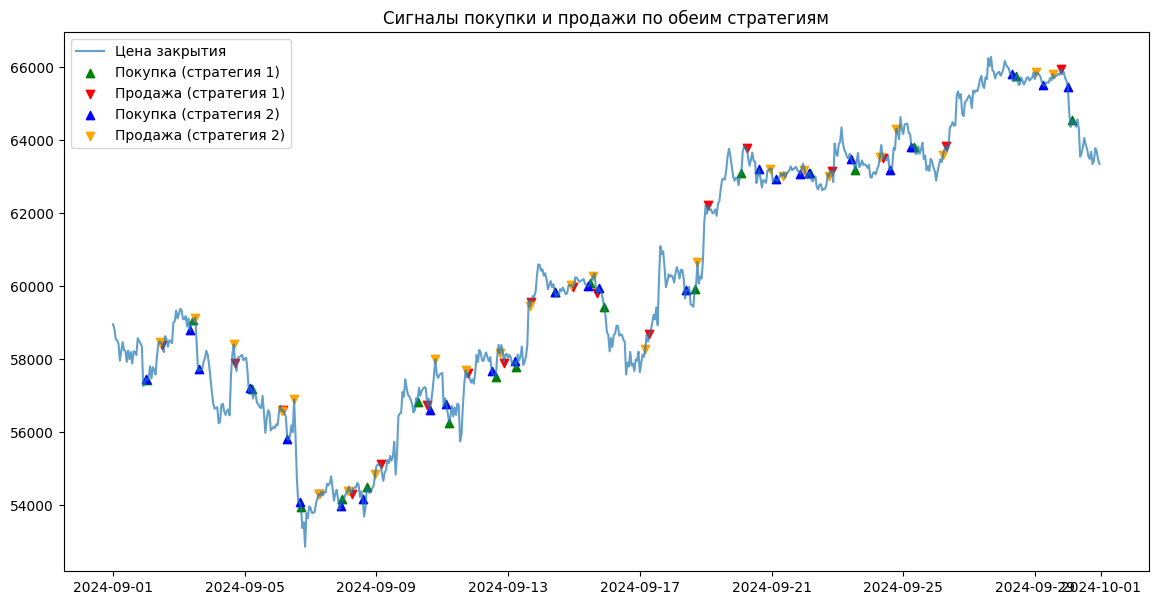

In [172]:
#@title 2024-09-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")
#@title Buy/Hold (min-max)
a=df['close'].max()-df['close'].min()
b=a*1000/df['close'].min()
print(f'Buy/Hold (min-max): total: {a}, by 1000: {b}')
# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 39
Успешные сделки: 26
Процент успешных сделок: 66.67%
Текущий капитал: 9112.03 USD
Общая доходность: -8.88%
Максимальная прибыль: 4.01%
Максимальный убыток: -7.83%
Buy/Hold (min-max): total: 15570.0, by 1000: 312.6066617142169


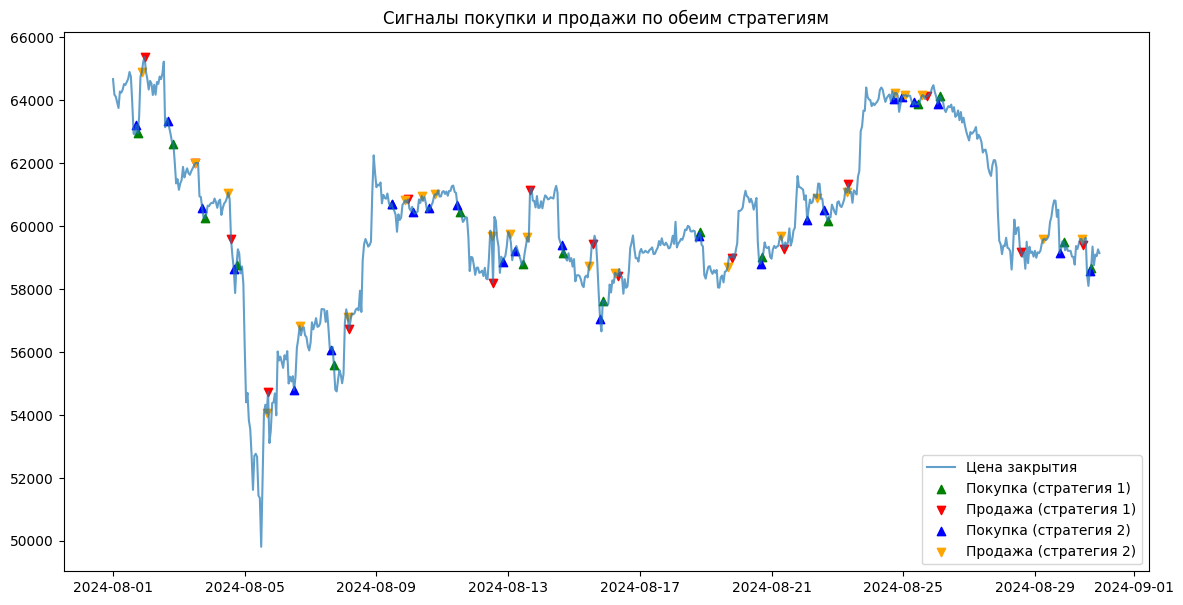

In [169]:
#@title 2024-08-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")
#@title Buy/Hold (min-max)
a=df['close'].max()-df['close'].min()
b=a*1000/df['close'].min()
print(f'Buy/Hold (min-max): total: {a}, by 1000: {b}')
# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 32
Успешные сделки: 19
Процент успешных сделок: 59.38%
Текущий капитал: 10143.57 USD
Общая доходность: 1.44%
Максимальная прибыль: 4.64%
Максимальный убыток: -7.13%
Buy/Hold (min-max): total: 15855.0, by 1000: 293.88867263526663


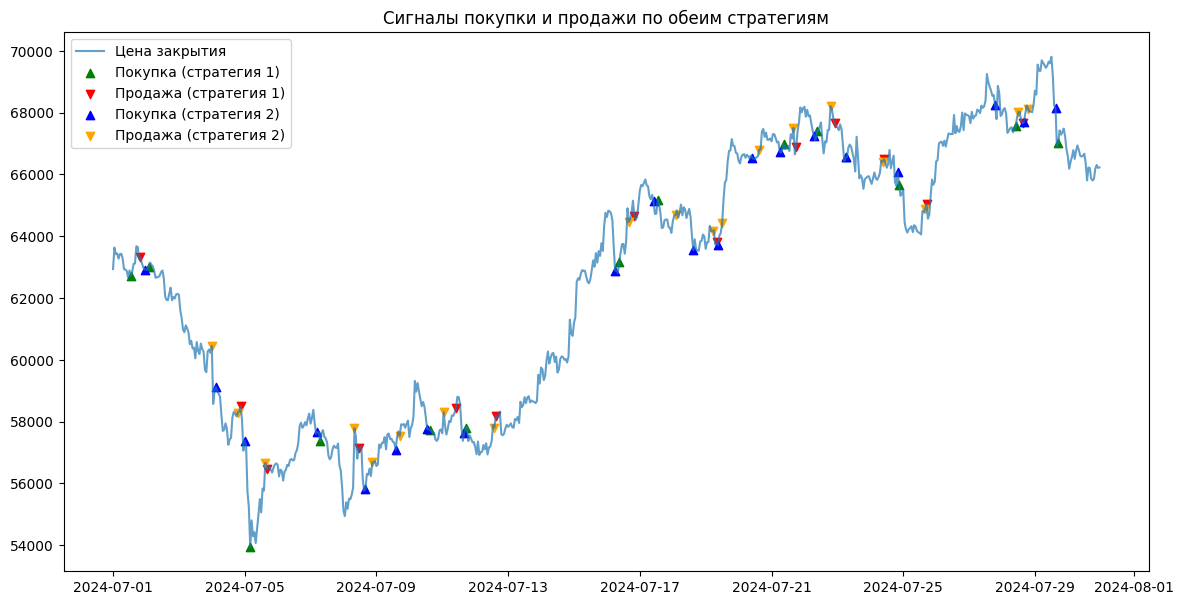

In [166]:
#@title 2024-07-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")
#@title Buy/Hold (min-max)
a=df['close'].max()-df['close'].min()
b=a*1000/df['close'].min()
print(f'Buy/Hold (min-max): total: {a}, by 1000: {b}')
# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 37
Успешные сделки: 22
Процент успешных сделок: 59.46%
Текущий капитал: 9150.63 USD
Общая доходность: -8.49%
Максимальная прибыль: 1.48%
Максимальный убыток: -5.32%
Buy/Hold (min-max): total: 12341.0, by 1000: 208.0200923709672


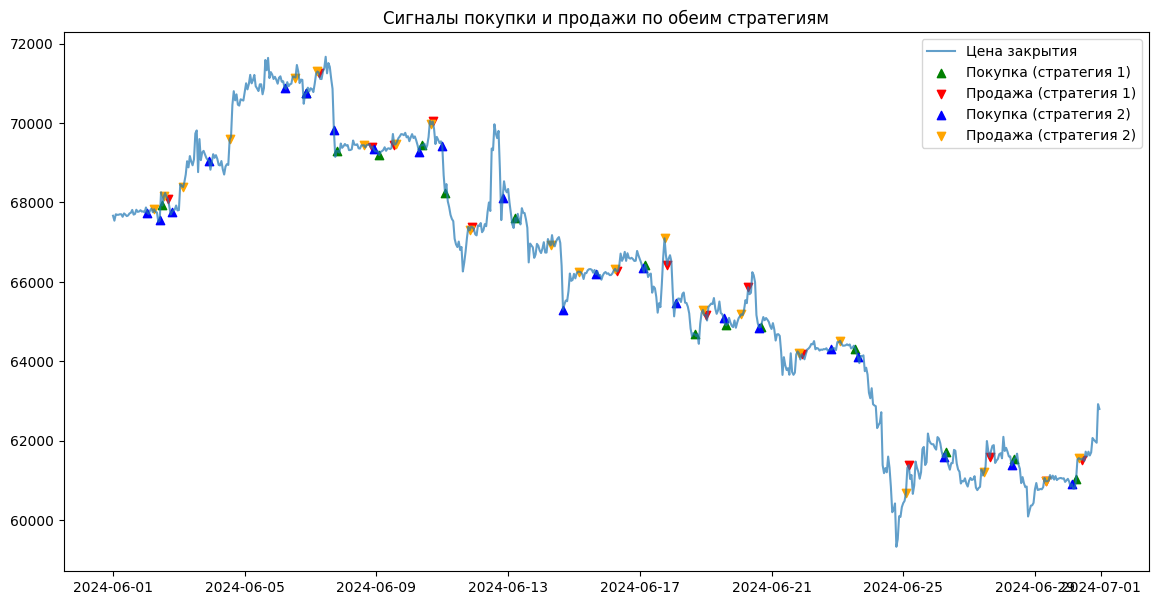

In [163]:
#@title 2024-06-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")
#@title Buy/Hold (min-max)
a=df['close'].max()-df['close'].min()
b=a*1000/df['close'].min()
print(f'Buy/Hold (min-max): total: {a}, by 1000: {b}')
# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 38
Успешные сделки: 29
Процент успешных сделок: 76.32%
Текущий капитал: 12182.02 USD
Общая доходность: 21.82%
Максимальная прибыль: 4.08%
Максимальный убыток: -2.58%
Buy/Hold (min-max): total: 14584.0, by 1000: 256.5121801072905


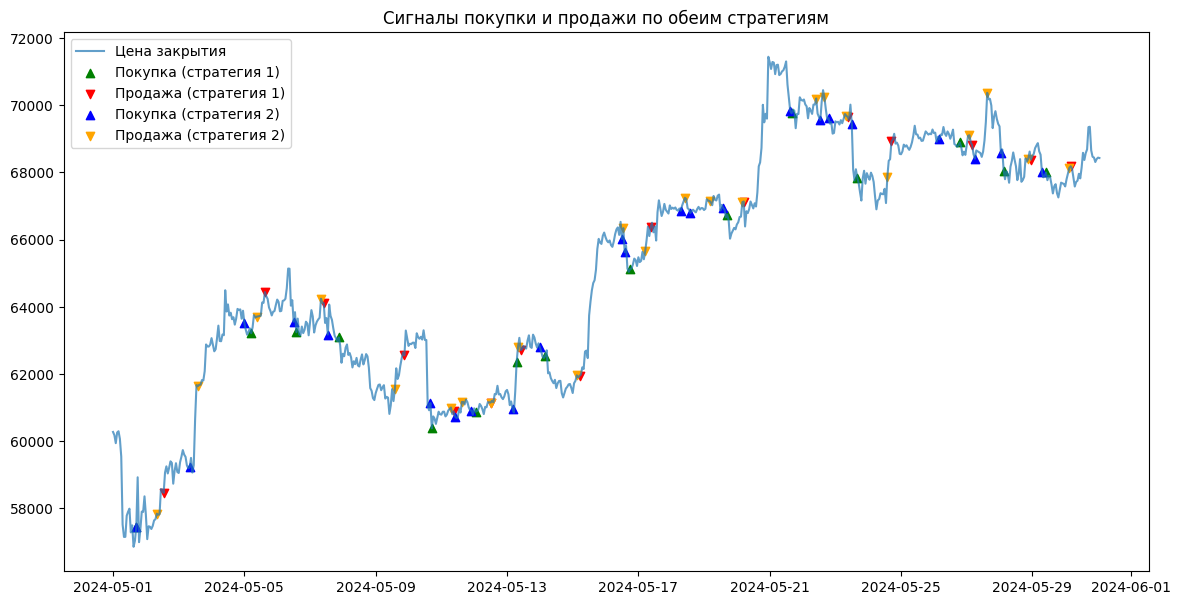

In [160]:
#@title 2024-05-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")
#@title Buy/Hold (min-max)
a=df['close'].max()-df['close'].min()
b=a*1000/df['close'].min()
print(f'Buy/Hold (min-max): total: {a}, by 1000: {b}')
# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 37
Успешные сделки: 20
Процент успешных сделок: 54.05%
Текущий капитал: 9365.33 USD
Общая доходность: -6.35%
Максимальная прибыль: 5.24%
Максимальный убыток: -4.11%
Buy/Hold (min-max): total: 13151.0, by 1000: 222.01026402863124


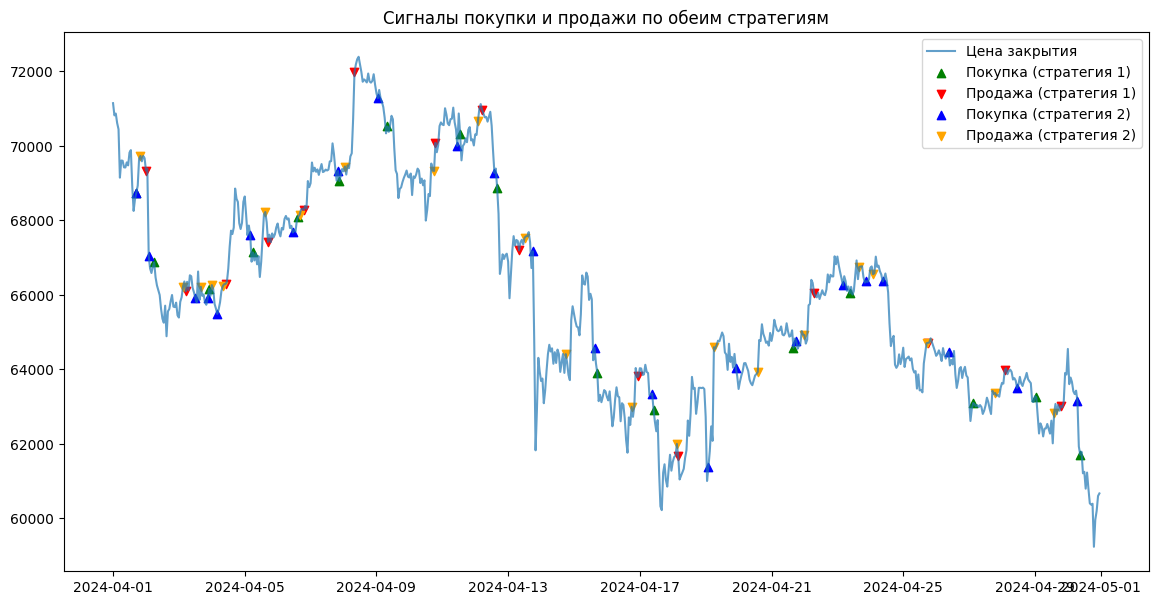

In [157]:
#@title 2024-04-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")
#@title Buy/Hold (min-max)
a=df['close'].max()-df['close'].min()
b=a*1000/df['close'].min()
print(f'Buy/Hold (min-max): total: {a}, by 1000: {b}')
# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 37
Успешные сделки: 24
Процент успешных сделок: 64.86%
Текущий капитал: 11371.65 USD
Общая доходность: 13.72%
Максимальная прибыль: 5.44%
Максимальный убыток: -4.36%
Buy/Hold (min-max): total: 12586.0, by 1000: 206.3955395211545


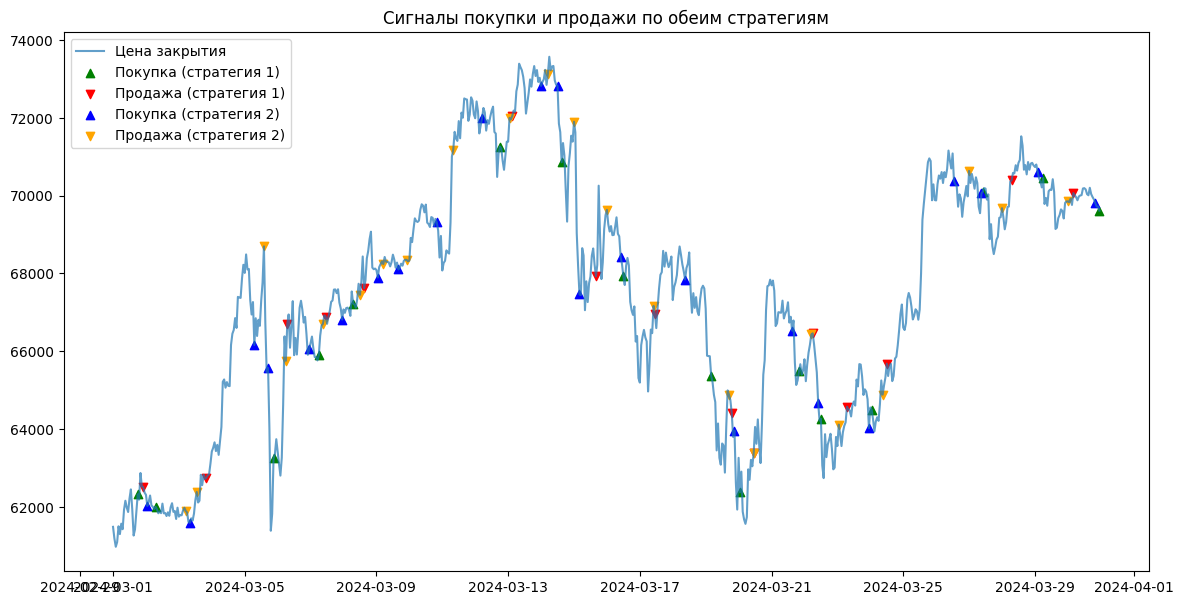

In [154]:
#@title 2024-03-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")
#@title Buy/Hold (min-max)
a=df['close'].max()-df['close'].min()
b=a*1000/df['close'].min()
print(f'Buy/Hold (min-max): total: {a}, by 1000: {b}')
# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 41
Успешные сделки: 29
Процент успешных сделок: 70.73%
Текущий капитал: 13781.30 USD
Общая доходность: 37.81%
Максимальная прибыль: 5.00%
Максимальный убыток: -0.76%
Buy/Hold (min-max): total: 21018.0, by 1000: 500.6073597713469


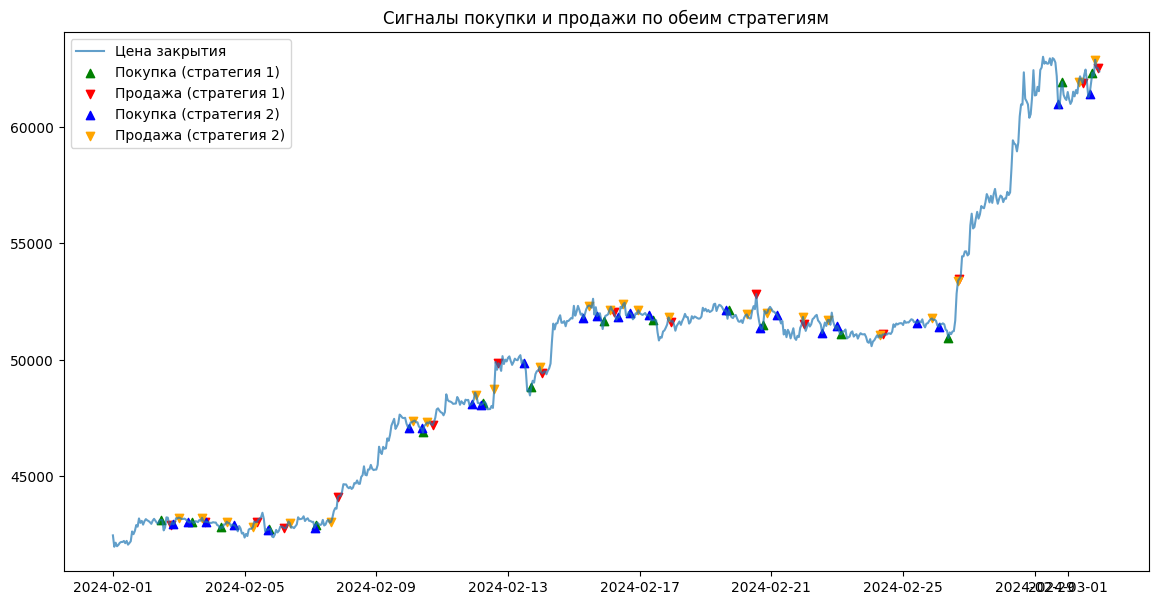

In [151]:
#@title 2024-02-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")
#@title Buy/Hold (min-max)
a=df['close'].max()-df['close'].min()
b=a*1000/df['close'].min()
print(f'Buy/Hold (min-max): total: {a}, by 1000: {b}')
# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 39
Успешные сделки: 37
Процент успешных сделок: 94.87%
Текущий капитал: 12849.48 USD
Общая доходность: 28.49%
Максимальная прибыль: 4.11%
Максимальный убыток: -0.17%
Buy/Hold (min-max): total: 7383.0, by 1000: 447.0210704771131


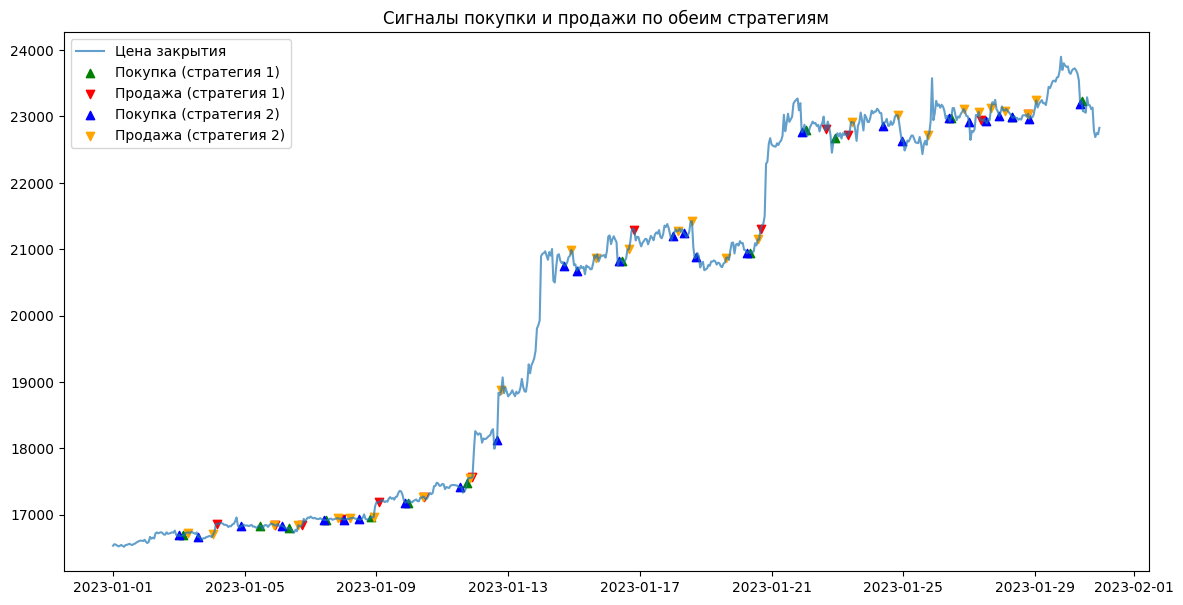

In [145]:
#@title 2024-01-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")
#@title Buy/Hold (min-max)
a=df['close'].max()-df['close'].min()
b=a*1000/df['close'].min()
print(f'Buy/Hold (min-max): total: {a}, by 1000: {b}')
# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 36
Успешные сделки: 24
Процент успешных сделок: 66.67%
Текущий капитал: 10200.43 USD
Общая доходность: 2.00%
Максимальная прибыль: 1.51%
Максимальный убыток: -4.81%
Buy/Hold (min-max): total: 6856.0, by 1000: 181.9436335650974


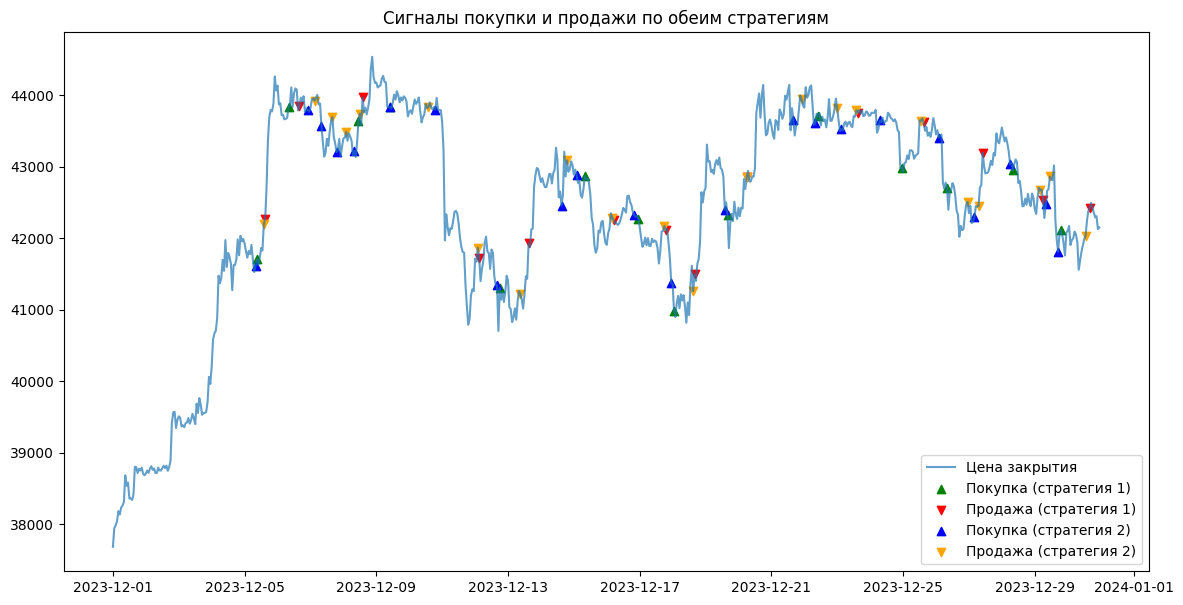

In [142]:
#@title 2023-12-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")
#@title Buy/Hold (min-max)
a=df['close'].max()-df['close'].min()
b=a*1000/df['close'].min()
print(f'Buy/Hold (min-max): total: {a}, by 1000: {b}')
# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 39
Успешные сделки: 25
Процент успешных сделок: 64.10%
Текущий капитал: 9810.63 USD
Общая доходность: -1.89%
Максимальная прибыль: 2.10%
Максимальный убыток: -2.58%
Buy/Hold (min-max): total: 4165.0, by 1000: 121.8441915572068


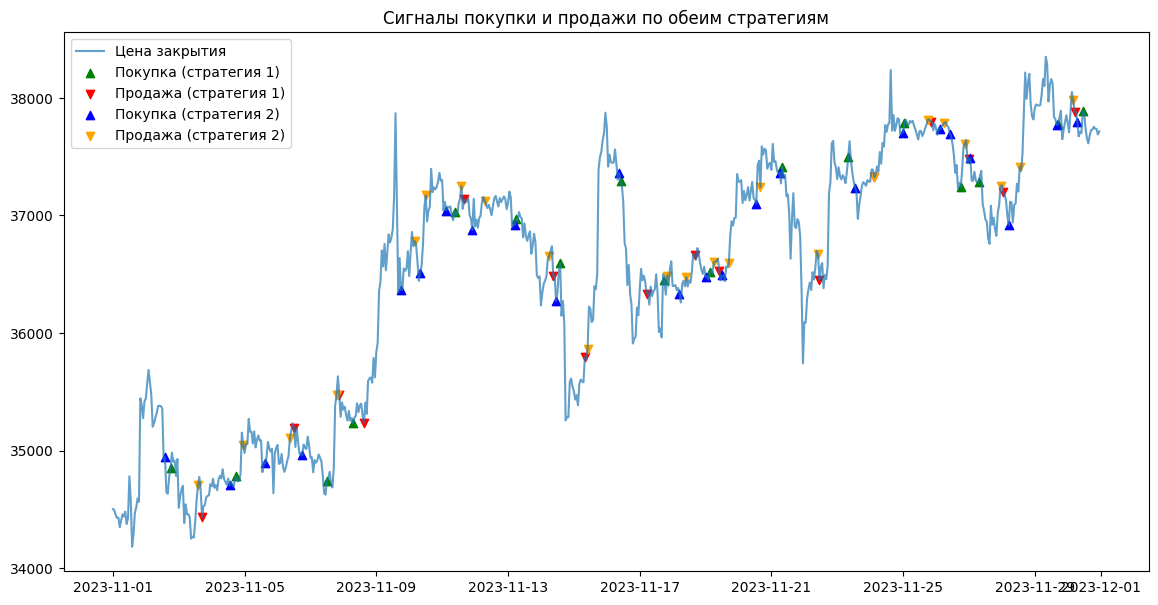

In [139]:
#@title 2023-11-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")
#@title Buy/Hold (min-max)
a=df['close'].max()-df['close'].min()
b=a*1000/df['close'].min()
print(f'Buy/Hold (min-max): total: {a}, by 1000: {b}')
# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 41
Успешные сделки: 28
Процент успешных сделок: 68.29%
Текущий капитал: 10275.82 USD
Общая доходность: 2.76%
Максимальная прибыль: 4.98%
Максимальный убыток: -6.71%
Buy/Hold (min-max): total: 14936.0, by 1000: 278.25698157497624


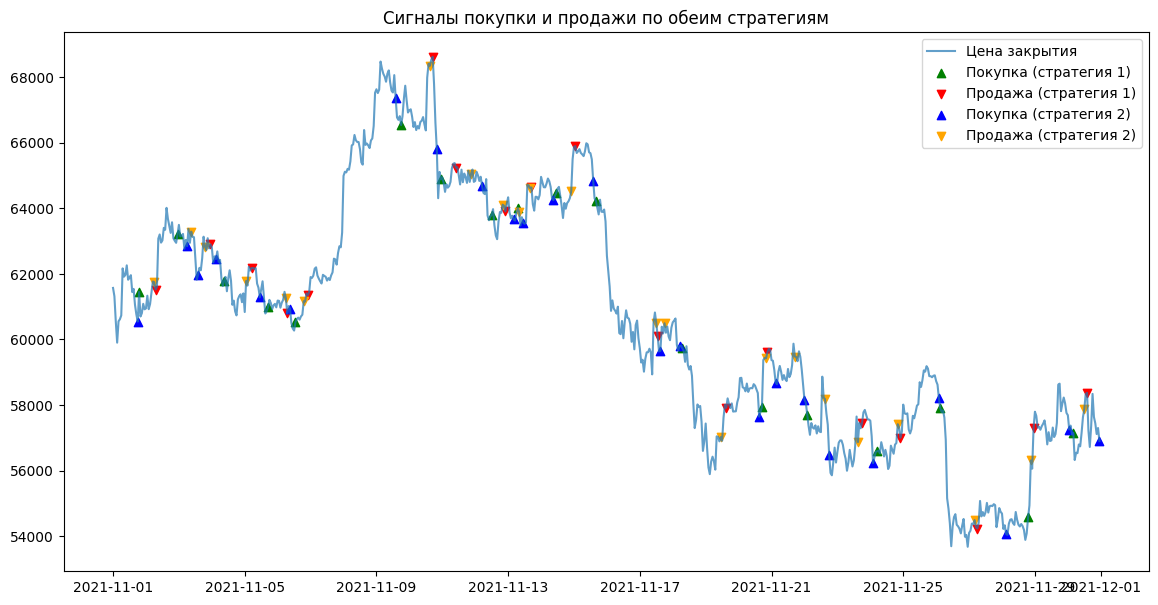

In [136]:
#@title 2021-11-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")
#@title Buy/Hold (min-max)
a=df['close'].max()-df['close'].min()
b=a*1000/df['close'].min()
print(f'Buy/Hold (min-max): total: {a}, by 1000: {b}')
# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

In [133]:
#@title Buy/Hold (min-max)
a=df['close'].max()-df['close'].min()
a, a*1000/df['close'].min()

(10733.0, 309.5492169699766)

Всего сделок: 38
Успешные сделки: 26
Процент успешных сделок: 68.42%
Текущий капитал: 9192.82 USD
Общая доходность: -8.07%
Максимальная прибыль: 2.97%
Максимальный убыток: -8.85%


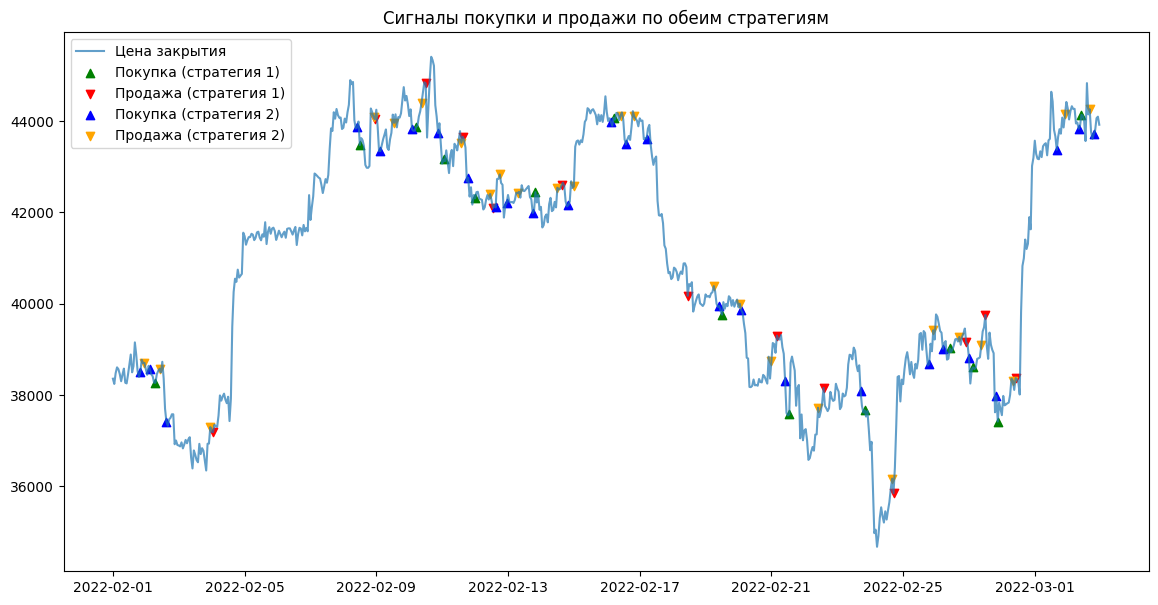

In [132]:
#@title 2022-02-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

In [129]:
#@title Buy/Hold (min-max)
a=df['close'].max()-df['close'].min()
a, a*1000/df['close'].min()

(12777.0, 434.2963970088375)

Всего сделок: 47
Успешные сделки: 38
Процент успешных сделок: 80.85%
Текущий капитал: 13280.37 USD
Общая доходность: 32.80%
Максимальная прибыль: 3.55%
Максимальный убыток: -5.77%


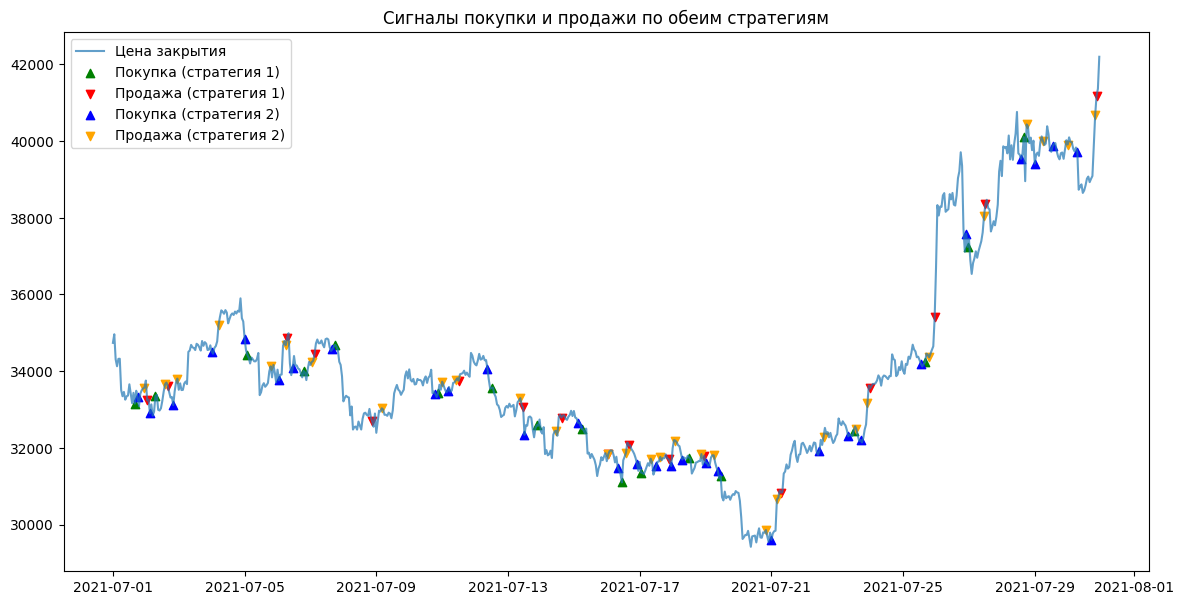

In [116]:
#@title 2021-07-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 31
Успешные сделки: 10
Процент успешных сделок: 32.26%
Текущий капитал: 5687.81 USD
Общая доходность: -43.12%
Максимальная прибыль: 2.06%
Максимальный убыток: -11.26%


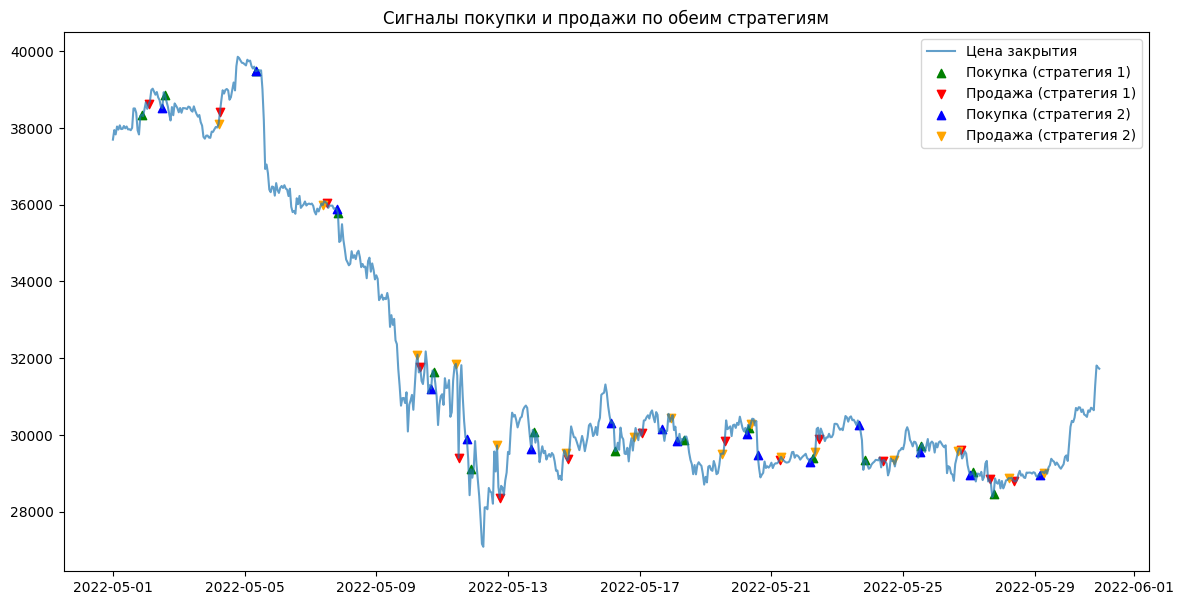

In [113]:
#@title 2022-05-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 34
Успешные сделки: 20
Процент успешных сделок: 58.82%
Текущий капитал: 7228.97 USD
Общая доходность: -27.71%
Максимальная прибыль: 4.56%
Максимальный убыток: -15.40%


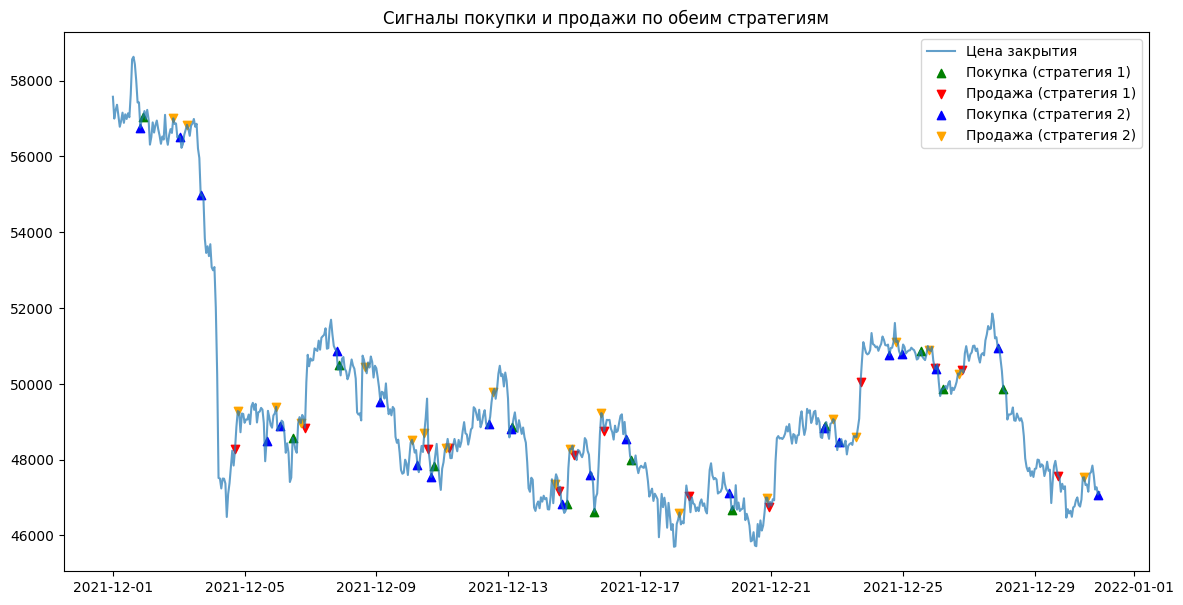

In [110]:
#@title 2021-12-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 39
Успешные сделки: 30
Процент успешных сделок: 76.92%
Текущий капитал: 10935.72 USD
Общая доходность: 9.36%
Максимальная прибыль: 3.34%
Максимальный убыток: -3.85%


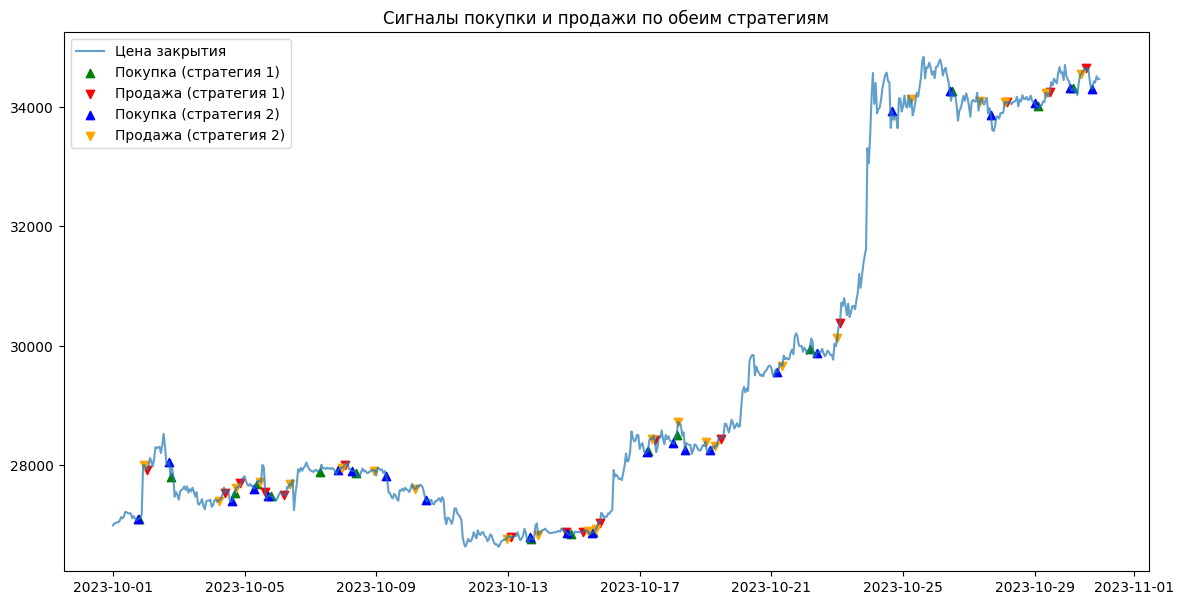

In [107]:
#@title 2023-10-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 36
Успешные сделки: 25
Процент успешных сделок: 69.44%
Текущий капитал: 9683.38 USD
Общая доходность: -3.17%
Максимальная прибыль: 1.29%
Максимальный убыток: -2.72%


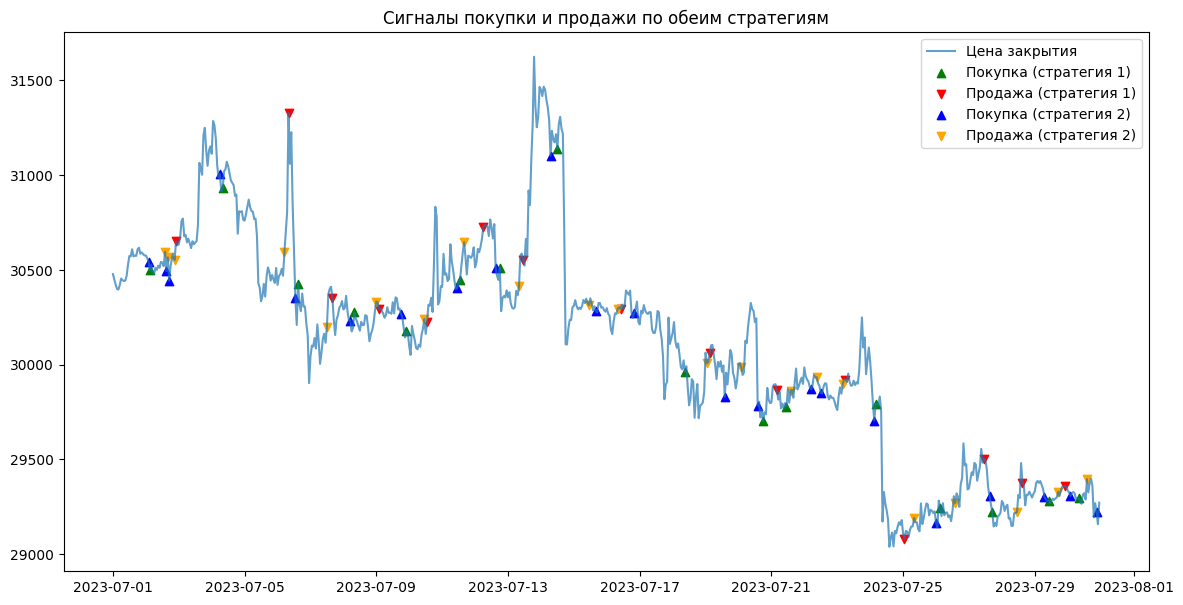

In [104]:
#@title 2023-07-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 32
Успешные сделки: 20
Процент успешных сделок: 62.50%
Текущий капитал: 10138.49 USD
Общая доходность: 1.38%
Максимальная прибыль: 2.67%
Максимальный убыток: -3.19%


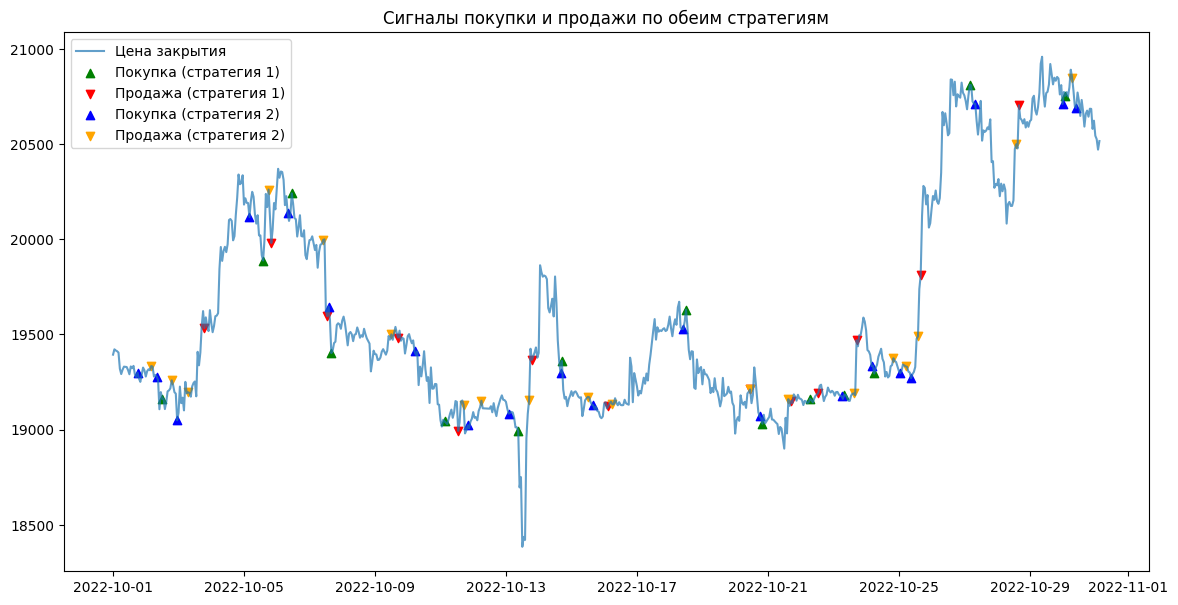

In [100]:
#@title 2022-10-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 35
Успешные сделки: 24
Процент успешных сделок: 68.57%
Текущий капитал: 9849.76 USD
Общая доходность: -1.50%
Максимальная прибыль: 4.03%
Максимальный убыток: -6.26%


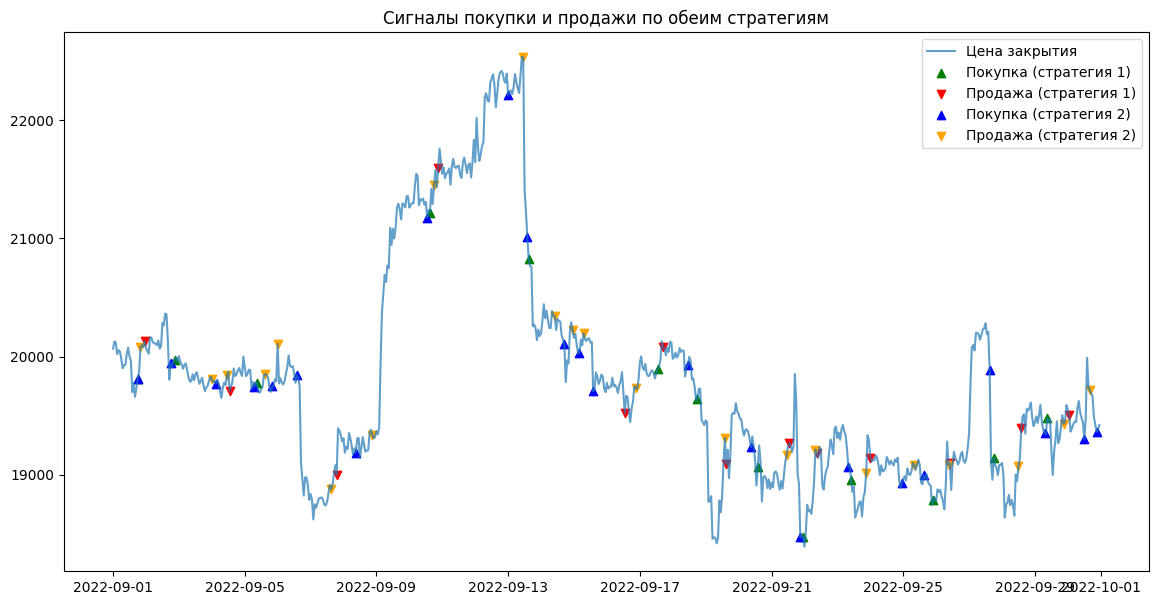

In [94]:
#@title 2022-09-01 +720 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

Всего сделок: 50
Успешные сделки: 31
Процент успешных сделок: 62.00%
Текущий капитал: 8692.56 USD
Общая доходность: -13.07%
Максимальная прибыль: 3.70%
Максимальный убыток: -9.15%


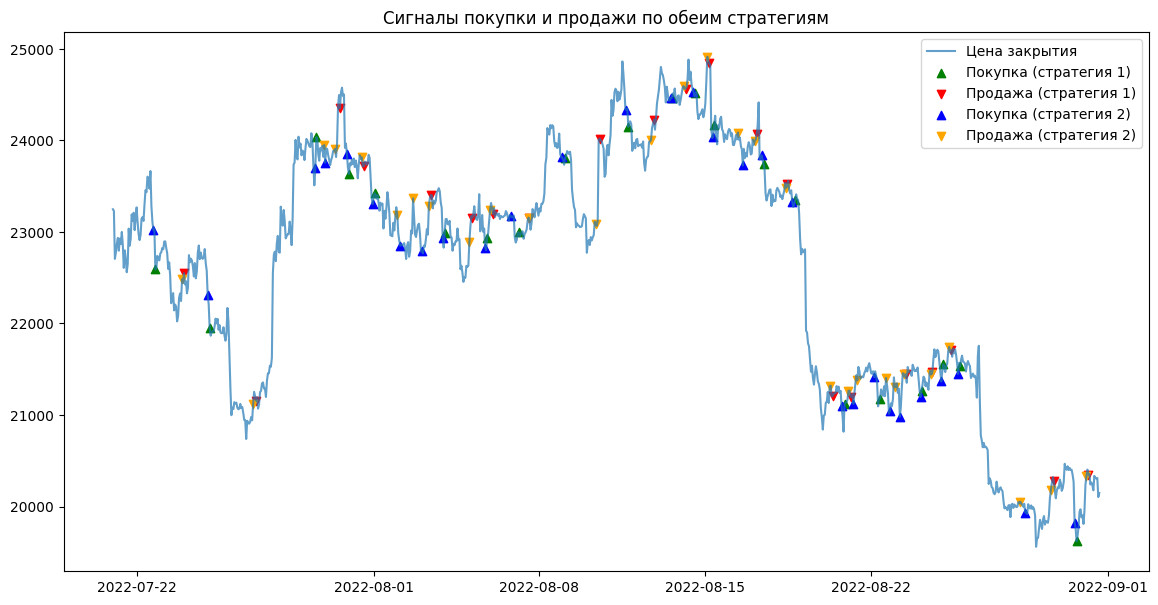

In [87]:
#@title 2022-07-21 +1000 (1h)
trades_1 = data2.dropna(subset=['trade_result_1'])
trades_2 = data2.dropna(subset=['trade_result_2'])

# Общие результаты по обеим стратегиям
total_trades = len(trades_1) + len(trades_2)
successful_trades = len(trades_1[trades_1['trade_result_1'] > 0]) + len(trades_2[trades_2['trade_result_2'] > 0])
total_return = trades_1['trade_result_1'].sum() + trades_2['trade_result_2'].sum()
max_profit = max(trades_1['trade_result_1'].max(), trades_2['trade_result_2'].max())
max_loss = min(trades_1['trade_result_1'].min(), trades_2['trade_result_2'].min())

# Выводим общие результаты
print(f"Всего сделок: {total_trades}")
print(f"Успешные сделки: {successful_trades}")
print(f"Процент успешных сделок: {successful_trades / total_trades * 100:.2f}%")
print(f"Текущий капитал: {current_capital:.2f} USD")
print(f"Общая доходность: {(current_capital - initial_capital) / initial_capital * 100:.2f}%")
print(f"Максимальная прибыль: {max_profit:.2f}%")
print(f"Максимальный убыток: {max_loss:.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data2['date'], data2['close'], label='Цена закрытия', alpha=0.7)

# Сигналы по первой стратегии
buy_signals_1 = data2[data2['signal_1'] == 1]
sell_signals_1 = data2[data2['signal_1'] == -1]
plt.scatter(buy_signals_1['date'], buy_signals_1['close'], marker='^', color='green', label='Покупка (стратегия 1)', alpha=1)
plt.scatter(sell_signals_1['date'], sell_signals_1['close'], marker='v', color='red', label='Продажа (стратегия 1)', alpha=1)

# Сигналы по второй стратегии
buy_signals_2 = data2[data2['signal_2'] == 1]
sell_signals_2 = data2[data2['signal_2'] == -1]
plt.scatter(buy_signals_2['date'], buy_signals_2['close'], marker='^', color='blue', label='Покупка (стратегия 2)', alpha=1)
plt.scatter(sell_signals_2['date'], sell_signals_2['close'], marker='v', color='orange', label='Продажа (стратегия 2)', alpha=1)

plt.title('Сигналы покупки и продажи по обеим стратегиям')
plt.legend()

plt.show()

#Next

In [6]:
!pip install backtesting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173913 sha256=1cee0f11ce7f0533c318612d30a396174a098ba0c73fa8fc0c3cb246356946bb
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [15]:
def get_data_bt(exch: str, start_time: str, end_time: str, timeframe: str, ticker: str) -> pd.DataFrame:
    ex = getattr(ccxt, exch)()
    from_ts = ex.parse8601(start_time)
    to_ts = ex.parse8601(end_time)

    ohlcv = ex.fetch_ohlcv(ticker, timeframe, since=from_ts, limit=1000)
    while True:
        from_ts = ohlcv[-1][0] + 1
        new_ohlcv = ex.fetch_ohlcv(ticker, timeframe, since=from_ts, limit=1000)
        ohlcv.extend(new_ohlcv)
        if len(new_ohlcv) != 1000 or new_ohlcv[-1][0] >= to_ts:
            break

    df = pd.DataFrame(ohlcv, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Date'] = pd.to_datetime(df['Date'], unit='ms')
    df.set_index('Date', inplace=True)
    df = df.sort_index(ascending=True)
    return df

In [16]:
dd=get_data_bt('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')

In [ ]:
def get_stoch(high, low, close):
    data['STOCH_K'], data['STOCH_D'] = ta.STOCH(data['high'], data['low'], data['close'],

In [53]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG


class RsiCross(Strategy):
    #RSI_BUY_LEVEL_1 = 35
    #RSI_SELL_LEVEL_1 = 66
    #RSI_PERIOD_2


    def init(self):
        price = self.data.Close
        self.rsi_1 = self.I(ta.RSI, price, 2)
        self.stoch_k_1, self.stoch_d_1 = self.I(ta.STOCH, self.data.High, self.data.Low, price,
                          STOCH_K_PERIOD,
                          STOCH_D_PERIOD,
                          0,
                          STOCH_D_PERIOD,
                          0)
        #self.bb_u, self.bb_m, self.bb_l = self.I(ta.BBANDS, price, BBANDS_PERIOD, BBANDS_STDDEV, 0)
        #ta.BBANDS(data['close'], timeperiod=BBANDS_PERIOD, nbdevup=BBANDS_STDDEV, nbdevdn=BBANDS_STDDEV, matype=0)

        #self.rsi_2 = self.I(ta.RSI, price, RSI_PERIOD_2)

    def next(self):
      #if
        if self.stoch_d_1[-1] != np.nan and self.rsi_1[-1] != np.nan and self.stoch_d_1[-1] != np.nan:
            if self.rsi_1[-1] < RSI_BUY_LEVEL_1 and self.stoch_k_1[-1] < STOCH_OVERSOLD and self.stoch_d_1[-1] < STOCH_OVERSOLD:
                print(f'hui: {self.data.Close[-1]}')
                #self.position.close()
                self.buy()
            elif self.rsi_1[-1] > RSI_SELL_LEVEL_1 and self.stoch_k_1[-1] > STOCH_OVERBOUGHT and self.stoch_d_1[-1] > STOCH_OVERBOUGHT: #crossover(self.ma2, self.rsi_1):
                print(f"blya: {self.data.Close[-1]}")
                self.position.close()#.sell()

            #elif self.rsi_2[-1] < RSI_BUY_LEVEL_2 and self.data.Close[-1] <= self.bb_l[-1]:
                #self.buy()
            #elif self.rsi_2 [-1]> RSI_SELL_LEVEL_2 and self.data.Close[-1] >= self.bb_l[-1]:
                #self.position.close()#sell()


bt = Backtest(dd, RsiCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
bt.plot()

<ipython-input-53-2c61f0e178f8>:44: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(dd, RsiCross, commission=.002,


blya: 60037.4
blya: 60015.6
blya: 60094.2
blya: 60244.2
blya: 60237.0
hui: 59999.8
blya: 60331.0
hui: 59794.5
hui: 59666.6
hui: 59431.4
hui: 59133.2
hui: 58675.1
hui: 58658.7
hui: 58205.4
hui: 58355.6
hui: 57808.6
blya: 58647.1
blya: 58693.4
blya: 58791.8
blya: 58992.3
blya: 59221.1
blya: 59406.3
blya: 60256.7
blya: 61117.9
blya: 60913.1
blya: 60952.2
hui: 59470.3
hui: 59431.5
blya: 62199.9
blya: 61968.0
blya: 62204.9
blya: 62130.0
blya: 62653.7
blya: 62929.2
blya: 62988.2
blya: 63552.2
blya: 63712.5
blya: 63620.2
hui: 62760.5
blya: 63781.3
blya: 63790.0
blya: 63167.7
blya: 63174.2
blya: 63250.0
hui: 62915.2
hui: 62877.2
hui: 62729.9
hui: 62648.5
hui: 62596.0
blya: 63174.7
blya: 63204.8
blya: 63779.7
blya: 63925.0
blya: 64357.7
hui: 63305.0
hui: 63200.0
hui: 62945.1
hui: 62979.5
blya: 63541.0
blya: 63858.6
blya: 63755.0
blya: 64333.3
blya: 64213.2
blya: 64635.9
blya: 64429.4
blya: 64428.0
hui: 63844.5
hui: 63825.5
hui: 63638.5
hui: 63627.6
hui: 63196.4
hui: 63196.6
hui: 62941.7
blya: 6

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p7872', ...)

In [54]:
stats

Start                     2024-09-14 05:00:00
End                       2024-10-14 04:00:00
Duration                     29 days 23:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]                7.209729
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                            NaN
Max. Trade Duration                       NaN
Avg. Trade Duration                       NaN
Profit Factor                             NaN
Expectancy [%]                            NaN
SQN                                       NaN
_strategy                            RsiCross
_equity_curve                             ...
_trades                   Empty DataFrame
...
dtype: object

In [ ]:
if 1<=0-np.nan*0.2:
    print('yes')

In [ ]:
list(range(2, len(data)))[0]

2

In [ ]:
data['ATR_Kalman'].head(30)

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
20   NaN
21   NaN
22   NaN
23   NaN
24   NaN
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
Name: ATR_Kalman, dtype: float64

In [ ]:
ta.STOCH(data['high'].iloc[:20], data['low'].iloc[:20], data['close'].iloc[:20],
                                                 fastk_period=STOCH_K_PERIOD,
                                                 slowk_period=STOCH_D_PERIOD,
                                                 slowk_matype=0,
                                                 slowd_period=STOCH_D_PERIOD,
                                                 slowd_matype=0)

(0           NaN
 1           NaN
 2           NaN
 3           NaN
 4           NaN
 5           NaN
 6           NaN
 7           NaN
 8           NaN
 9           NaN
 10          NaN
 11    71.083943
 12    67.332191
 13    61.640532
 14    42.067208
 15    21.393221
 16    11.918639
 17    19.527348
 18    26.773227
 19    45.376130
 dtype: float64,
 0           NaN
 1           NaN
 2           NaN
 3           NaN
 4           NaN
 5           NaN
 6           NaN
 7           NaN
 8           NaN
 9           NaN
 10          NaN
 11    74.529668
 12    69.208067
 13    64.486361
 14    51.853870
 15    31.730215
 16    16.655930
 17    15.722993
 18    23.150287
 19    36.074678
 dtype: float64)

In [ ]:
ta.RSI(data['close'].iloc[:30], timeperiod=2)

0           NaN
1           NaN
2     31.506099
3     63.525443
4     86.809927
5     87.117223
6     87.587507
7     96.787032
8     70.131303
9     88.563109
10    54.753581
11    32.943736
12    28.968302
13    17.809689
14     9.728033
15     3.257478
16     9.837959
17    81.859996
18    53.505677
19    86.217844
20    56.943745
21    66.067988
22    69.095908
23    86.025300
24    63.334288
25     6.499180
26    47.011219
27    24.381792
28    55.424603
29    82.244050
dtype: float64

In [ ]:
data['close'].iloc[:4]

0    55330.2
1    55733.1
2    54857.2
3    55418.5
Name: close, dtype: float64

In [ ]:
data[]

In [ ]:
len(data)

720

Total number of OHLCV data points fetched: 720
Всего сделок: 8
Успешные сделки: 7
Процент успешных сделок: 87.50%
Общая доходность: 14.84%
Максимальная прибыль: 6.31%
Максимальный убыток: -6.76%


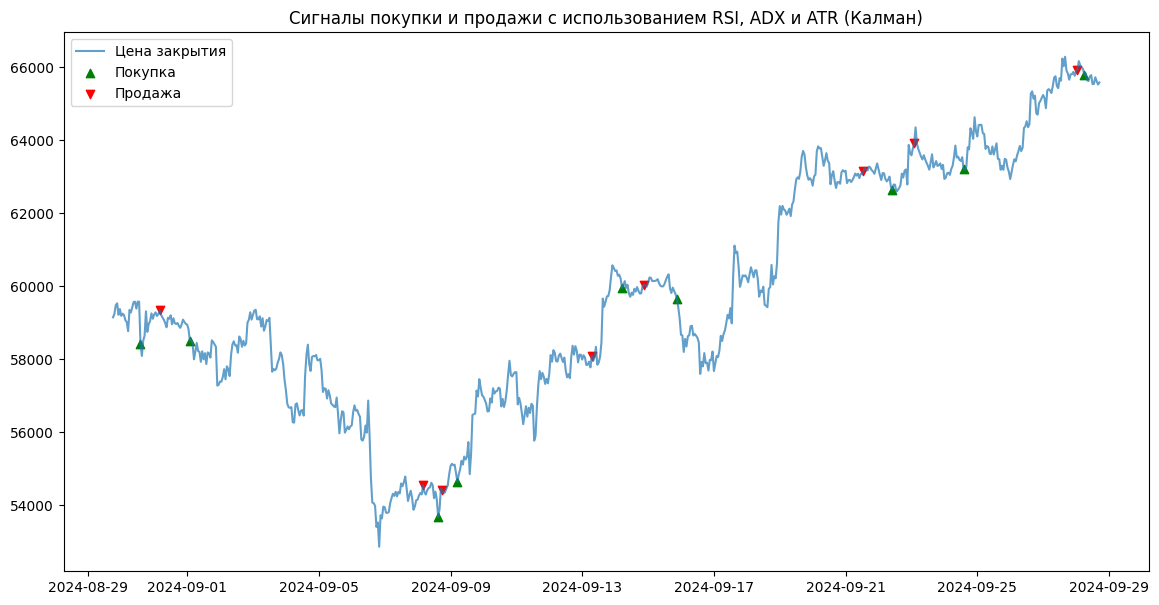

In [ ]:
#@title RSI 2 + ADX + ATR Kalman //
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD = 3
RSI_BUY_LEVEL = 30
RSI_SELL_LEVEL = 65
ADX_PERIOD = 10
ADX_THRESHOLD = 20
ATR_PERIOD = 2
ATR_MULTIPLIER_SL = 0.6
ATR_MULTIPLIER_TP = 2.5

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем ADX
data['ADX'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=ADX_PERIOD)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и ADX выше порога
        if data['RSI'][i] < RSI_BUY_LEVEL and data['ADX'][i] > ADX_THRESHOLD:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем, если RSI выше уровня продажи и ADX ниже порога
        elif data['RSI'][i] > RSI_SELL_LEVEL and data['ADX'][i] < ADX_THRESHOLD:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI, ADX и ATR (Калман)')
plt.legend()

plt.show()

Total number of OHLCV data points fetched: 720
Всего сделок: 11
Успешные сделки: 9
Процент успешных сделок: 81.82%
Общая доходность: 6.32%
Максимальная прибыль: 2.73%
Максимальный убыток: -1.43%


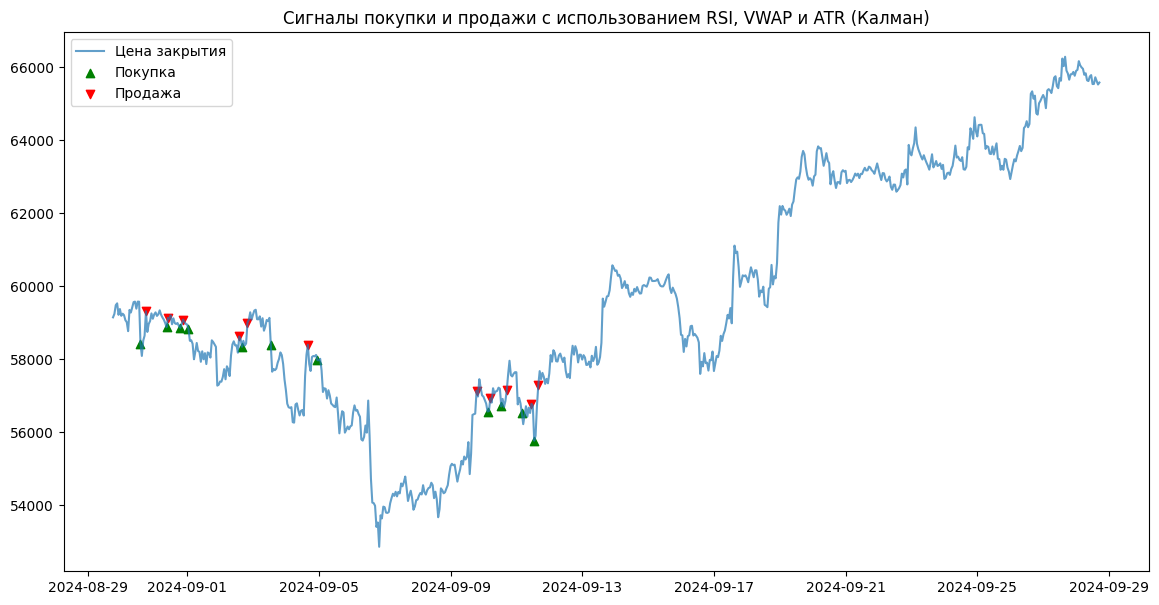

In [ ]:
#@title RSI 2 + VWAP + ATR Kalman // buy 35 sell 65
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 30
RSI_SELL_LEVEL = 65
VWAP_PERIOD = 14
ATR_PERIOD = 2
ATR_MULTIPLIER_SL = 0.6
ATR_MULTIPLIER_TP = 2.5

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем VWAP
data['VWAP'] = (data['close'] * data['volume']).cumsum() / data['volume'].cumsum()
data['VWAP'] = data['VWAP'].rolling(window=VWAP_PERIOD).mean()

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и цена ниже VWAP
        if data['RSI'][i] < RSI_BUY_LEVEL and data['close'][i] < data['VWAP'][i]:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем, если RSI выше уровня продажи и цена выше VWAP
        elif data['RSI'][i] > RSI_SELL_LEVEL and data['close'][i] > data['VWAP'][i]:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI, VWAP и ATR (Калман)')
plt.legend()

plt.show()

Total number of OHLCV data points fetched: 720
Всего сделок: 16
Успешные сделки: 9
Процент успешных сделок: 56.25%
Общая доходность: 11.00%
Максимальная прибыль: 5.26%
Максимальный убыток: -1.58%


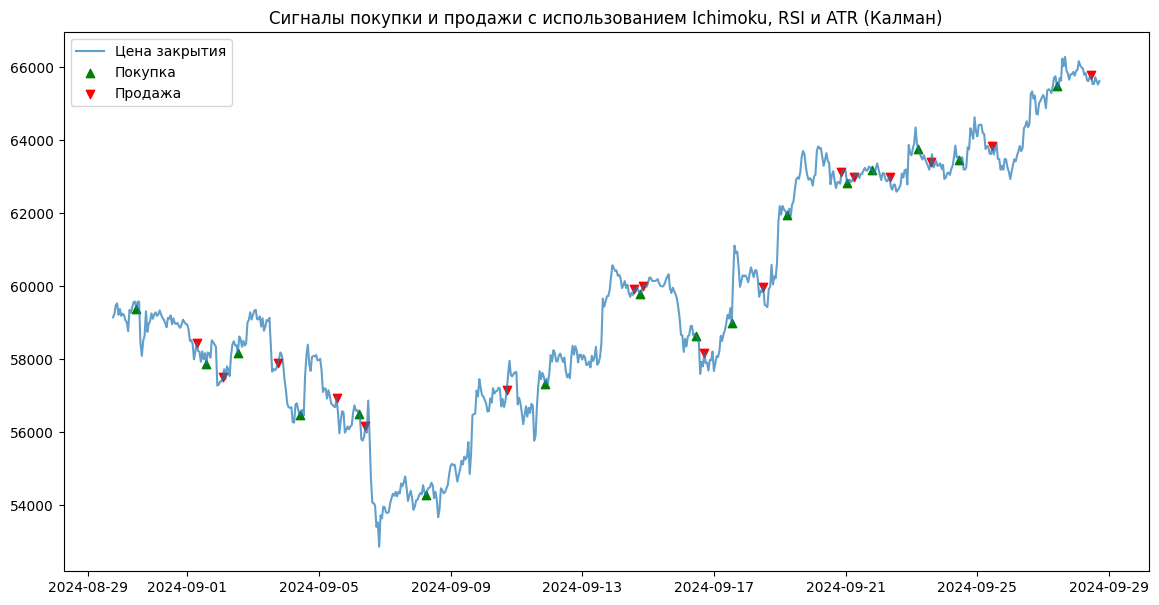

In [ ]:
#@title RSI 2 + Ichimoku + ATR Kalman // buy 35 sell 65
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Параметры стратегии
ICHIMOKU_TENKAN_SEN = 10
ICHIMOKU_KIJUN_SEN = 21
ICHIMOKU_SENKOU_SPAN_A = 52
ICHIMOKU_SENKOU_SPAN_B = 52
RSI_PERIOD = 2
RSI_BUY_LEVEL = 35
RSI_SELL_LEVEL = 65
ATR_PERIOD = 2
ATR_MULTIPLIER_SL = 0.75
ATR_MULTIPLIER_TP = 2.5

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем Ichimoku
data['Tenkan-sen'] = (data['high'].rolling(window=ICHIMOKU_TENKAN_SEN).max() + data['low'].rolling(window=ICHIMOKU_TENKAN_SEN).min()) / 2
data['Kijun-sen'] = (data['high'].rolling(window=ICHIMOKU_KIJUN_SEN).max() + data['low'].rolling(window=ICHIMOKU_KIJUN_SEN).min()) / 2
data['Senkou Span A'] = (data['Tenkan-sen'] + data['Kijun-sen']) / 2
data['Senkou Span B'] = (data['high'].rolling(window=ICHIMOKU_SENKOU_SPAN_B).max() + data['low'].rolling(window=ICHIMOKU_SENKOU_SPAN_B).min()) / 2

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: цена выше Tenkan-sen и RSI ниже уровня покупки
        if data['close'][i] > data['Tenkan-sen'][i] and data['RSI'][i] < RSI_BUY_LEVEL:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем, если цена ниже Kijun-sen и RSI выше уровня продажи
        elif data['close'][i] < data['Kijun-sen'][i] and data['RSI'][i] > RSI_SELL_LEVEL:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием Ichimoku, RSI и ATR (Калман)')
plt.legend()

plt.show()

Total number of OHLCV data points fetched: 720
Всего сделок: 25
Успешные сделки: 17
Процент успешных сделок: 68.00%
Общая доходность: 14.83%
Максимальная прибыль: 3.96%
Максимальный убыток: -1.91%


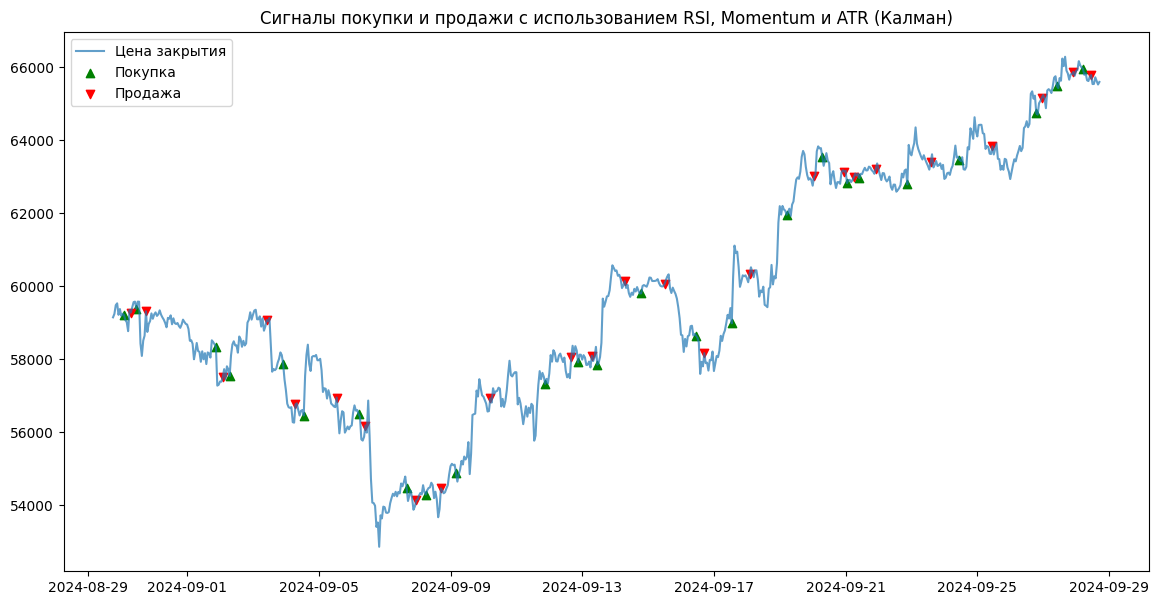

In [ ]:
#@title RSI 2 + Momentum + ATR Kalman // buy 35 sell 65
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 35
RSI_SELL_LEVEL = 65
MOMENTUM_PERIOD = 8
ATR_PERIOD = 2
ATR_MULTIPLIER_SL = 0.75
ATR_MULTIPLIER_TP = 2.5

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем Momentum
data['Momentum'] = ta.MOM(data['close'], timeperiod=MOMENTUM_PERIOD)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и Momentum выше нуля
        if data['RSI'][i] < RSI_BUY_LEVEL and data['Momentum'][i] > 0:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем, если RSI выше уровня продажи и Momentum ниже нуля
        elif data['RSI'][i] > RSI_SELL_LEVEL and data['Momentum'][i] < 0:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI, Momentum и ATR (Калман)')
plt.legend()

plt.show()

Total number of OHLCV data points fetched: 720
Всего сделок: 23
Успешные сделки: 17
Процент успешных сделок: 73.91%
Общая доходность: 15.88%
Максимальная прибыль: 3.83%
Максимальный убыток: -3.90%


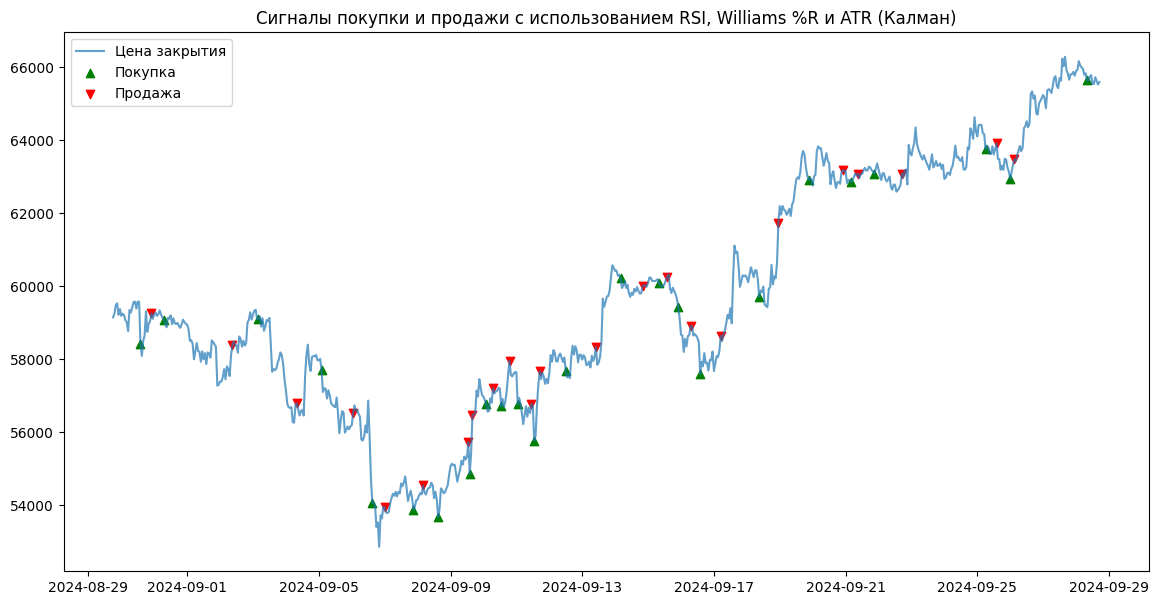

In [ ]:
#@title RSI 2 + Williams + ATR Kalman // buy 35 sell 65
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 30
RSI_SELL_LEVEL = 65
WILLIAMS_PERIOD = 7
WILLIAMS_BUY_LEVEL = -90
WILLIAMS_SELL_LEVEL = -10
ATR_PERIOD = 2
ATR_MULTIPLIER_SL = 0.6
ATR_MULTIPLIER_TP = 2.5

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем Williams %R
data['Williams'] = ta.WILLR(data['high'], data['low'], data['close'], timeperiod=WILLIAMS_PERIOD)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и Williams %R ниже уровня покупки
        if data['RSI'][i] < RSI_BUY_LEVEL and data['Williams'][i] < WILLIAMS_BUY_LEVEL:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем, если RSI выше уровня продажи и Williams %R выше уровня продажи
        elif data['RSI'][i] > RSI_SELL_LEVEL and data['Williams'][i] > WILLIAMS_SELL_LEVEL:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI, Williams %R и ATR (Калман)')
plt.legend()

plt.show()

Total number of OHLCV data points fetched: 720
Всего сделок: 38
Успешные сделки: 28
Процент успешных сделок: 73.68%
Общая доходность: 15.95%
Максимальная прибыль: 2.96%
Максимальный убыток: -2.01%


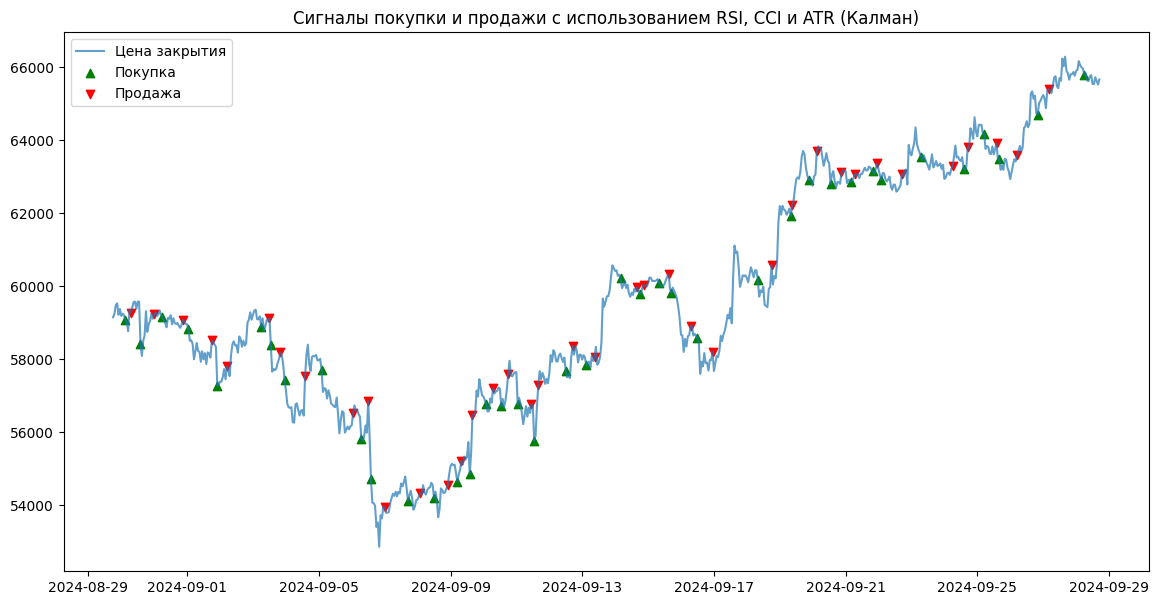

In [ ]:
#@title RSI 2 + CCI + Kalman ATR // buy 35 sell 65
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 30
RSI_SELL_LEVEL = 65
CCI_PERIOD = 7
CCI_BUY_LEVEL = -80
CCI_SELL_LEVEL = 95
ATR_PERIOD = 2
ATR_MULTIPLIER_SL = 0.6
ATR_MULTIPLIER_TP = 2.5

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем CCI
data['CCI'] = ta.CCI(data['high'], data['low'], data['close'], timeperiod=CCI_PERIOD)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах

# Статусы для управления сделками
in_position = False
entry_price = 0

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и CCI ниже уровня покупки
        if data['RSI'][i] < RSI_BUY_LEVEL and data['CCI'][i] < CCI_BUY_LEVEL:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            in_position = False
        # Продаем, если RSI выше уровня продажи и CCI выше уровня продажи
        elif data['RSI'][i] > RSI_SELL_LEVEL and data['CCI'][i] > CCI_SELL_LEVEL:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            in_position = False

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))

# График цены закрытия
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI, CCI и ATR (Калман)')
plt.legend()

plt.show()

In [ ]:
!pip install ccxt pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.1 MB/s eta 0:00:00


|   iter    |  target   | rsi_bu... | rsi_pe... | rsi_se... | stoch_... | stoch_... | stoch_... | stoch_... |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.0       | 21.24     | 28.57     | 81.96     | 27.96     | 4.872     | 8.9       | 61.74     |
| 2         | -0.004075 | 35.99     | 18.43     | 81.24     | 10.62     | 14.64     | 25.81     | 66.37     |
| 3         | -0.001097 | 15.45     | 6.319     | 69.13     | 25.74     | 8.183     | 12.28     | 78.36     |
| 4         | 0.01628   | 14.18     | 9.472     | 70.99     | 23.68     | 12.42     | 9.992     | 75.43     |
| 5         | 0.004634  | 27.77     | 2.347     | 78.23     | 15.12     | 3.781     | 28.72     | 88.97     |
| 6         | 0.001061  | 14.34     | 9.625     | 71.14     | 23.83     | 12.58     | 10.14     | 75.58     |
| 7         | 0.007235  | 14.86     | 13.71     | 73.25     | 34.73     | 3.252     | 7.266     | 70.15     |
| 8       

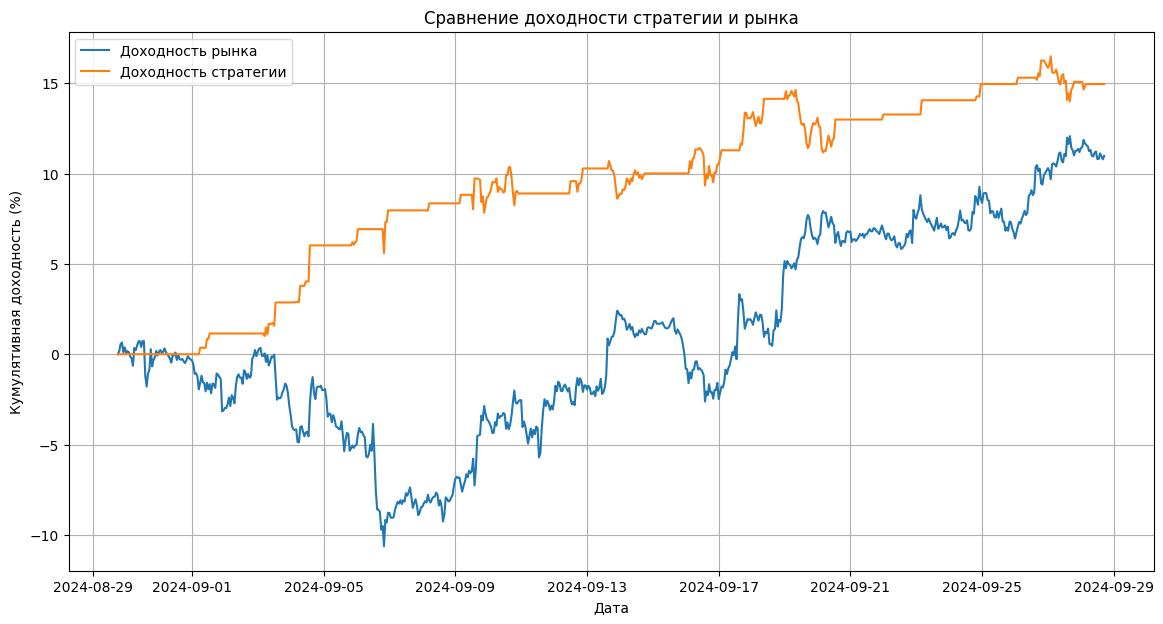

In [ ]:
# Установка необходимых библиотек
!pip install ccxt bayesian-optimization

# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ccxt
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings('ignore')

# Функция для получения данных с биржи
def get_data(exchange_id, symbol, timeframe, limit=1000):
    exchange_class = getattr(ccxt, exchange_id)
    exchange = exchange_class()
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

# Функция для расчета индикаторов
def calculate_indicators(df, rsi_period, stoch_k_period, stoch_d_period):
    # RSI
    delta = df['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    average_gain = gain.rolling(window=int(rsi_period)).mean()
    average_loss = loss.rolling(window=int(rsi_period)).mean()
    rs = average_gain / average_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Стохастический осциллятор
    df['Lowest_Low'] = df['low'].rolling(window=int(stoch_k_period)).min()
    df['Highest_High'] = df['high'].rolling(window=int(stoch_k_period)).max()
    df['%K'] = 100 * ((df['close'] - df['Lowest_Low']) / (df['Highest_High'] - df['Lowest_Low']))
    df['%D'] = df['%K'].rolling(window=int(stoch_d_period)).mean()

    # ATR для управления рисками
    df['TR'] = np.maximum.reduce([
        df['high'] - df['low'],
        abs(df['high'] - df['close'].shift()),
        abs(df['low'] - df['close'].shift())
    ])
    df['ATR'] = df['TR'].rolling(window=14).mean()

# Функция для генерации торговых сигналов
def generate_signals(df, rsi_buy_threshold, rsi_sell_threshold, stoch_buy_threshold, stoch_sell_threshold):
    df['Signal'] = 0

    # Длинная позиция
    df.loc[
        (df['RSI'] < rsi_buy_threshold) &
        (df['%K'] < stoch_buy_threshold) &
        (df['%D'] < stoch_buy_threshold),
        'Signal'
    ] = 1

    # Короткая позиция
    df.loc[
        (df['RSI'] > rsi_sell_threshold) &
        (df['%K'] > stoch_sell_threshold) &
        (df['%D'] > stoch_sell_threshold),
        'Signal'
    ] = -1

    df['Position'] = df['Signal'].shift().fillna(0)

# Функция для расчета доходности стратегии
def calculate_strategy_returns(df):
    df['Market_Returns'] = df['close'].pct_change()
    df['Strategy_Returns'] = df['Position'] * df['Market_Returns']
    df['Cumulative_Market_Returns'] = (1 + df['Market_Returns'].fillna(0)).cumprod() - 1
    df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns'].fillna(0)).cumprod() - 1

# Целевая функция для байесовской оптимизации
def optimize_strategy(rsi_period, stoch_k_period, stoch_d_period, rsi_buy_threshold, rsi_sell_threshold, stoch_buy_threshold, stoch_sell_threshold):
    rsi_period = int(rsi_period)
    stoch_k_period = int(stoch_k_period)
    stoch_d_period = int(stoch_d_period)
    rsi_buy_threshold = int(rsi_buy_threshold)
    rsi_sell_threshold = int(rsi_sell_threshold)
    stoch_buy_threshold = int(stoch_buy_threshold)
    stoch_sell_threshold = int(stoch_sell_threshold)

    if rsi_period <= 0 or stoch_k_period <= 0 or stoch_d_period <= 0:
        return -np.inf  # Неприемлемые параметры

    df_copy = df.copy()
    calculate_indicators(df_copy, rsi_period, stoch_k_period, stoch_d_period)
    generate_signals(df_copy, rsi_buy_threshold, rsi_sell_threshold, stoch_buy_threshold, stoch_sell_threshold)
    calculate_strategy_returns(df_copy)
    total_return = df_copy['Cumulative_Strategy_Returns'].iloc[-1]
    return total_return

# Основной блок программы
if __name__ == "__main__":
    EXCHANGE_ID = 'kraken'
    SYMBOL = 'BTC/USDT'
    TIMEFRAME = '1h'
    LIMIT = 1000  # Максимальное количество свечей

    # Получение данных
    df = get_data(EXCHANGE_ID, SYMBOL, TIMEFRAME, LIMIT)

    # Диапазоны параметров для оптимизации
    pbounds = {
        'rsi_period': (1, 30),
        'stoch_k_period': (5, 30),
        'stoch_d_period': (3, 15),
        'rsi_buy_threshold': (10, 40),
        'rsi_sell_threshold': (60, 90),
        'stoch_buy_threshold': (10, 40),
        'stoch_sell_threshold': (60, 90)
    }

    optimizer = BayesianOptimization(
        f=optimize_strategy,
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    # Запуск оптимизации
    optimizer.maximize(init_points=5, n_iter=25)

    # Лучшие параметры
    best_params = optimizer.max['params']
    print("Наилучшие параметры:")
    for param, value in best_params.items():
        if 'threshold' in param:
            print(f"{param}: {int(value)}")
        else:
            print(f"{param}: {int(value)}")

    # Применение лучших параметров
    best_params_int = {param: int(value) for param, value in best_params.items()}
    calculate_indicators(df, best_params_int['rsi_period'], best_params_int['stoch_k_period'], best_params_int['stoch_d_period'])
    generate_signals(df, best_params_int['rsi_buy_threshold'], best_params_int['rsi_sell_threshold'], best_params_int['stoch_buy_threshold'], best_params_int['stoch_sell_threshold'])

    calculate_strategy_returns(df)

    # Вывод результатов
    total_return = df['Cumulative_Strategy_Returns'].iloc[-1] * 100
    print(f"\nОбщая доходность стратегии с оптимизированными параметрами: {total_return:.2f}%")

    # Построение графиков
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Cumulative_Market_Returns'] * 100, label='Доходность рынка')
    plt.plot(df.index, df['Cumulative_Strategy_Returns'] * 100, label='Доходность стратегии')
    plt.legend()
    plt.title('Сравнение доходности стратегии и рынка')
    plt.xlabel('Дата')
    plt.ylabel('Кумулятивная доходность (%)')
    plt.grid(True)
    plt.show()

In [ ]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Параметры стратегии
RSI_PERIOD = 2
RSI_OVERBOUGHT = 65
RSI_OVERSOLD = 31
ATR_PERIOD = 2
STOP_LOSS_MULTIPLIER = 0.6
TAKE_PROFIT_MULTIPLIER = 2.5

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах
data['equity'] = 100000  # Начальный капитал

# Статусы для управления сделками
in_position = False
entry_price = 0
initial_equity = data['equity'].iloc[0]

# Логика стратегии
for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки
        if data['RSI'][i] < RSI_OVERSOLD:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - STOP_LOSS_MULTIPLIER * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + TAKE_PROFIT_MULTIPLIER * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        # Продаем, если RSI выше уровня продажи
        elif data['RSI'][i] > RSI_OVERBOUGHT:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        else:
            data.at[i, 'equity'] = data.iloc[i-1]['equity']

# Выводим результаты сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 10))

# График цены закрытия
plt.subplot(3, 1, 1)
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI и ATR (Калман)')
plt.legend()


TypeError: get_data() takes from 3 to 4 positional arguments but 5 were given

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.3 MB/s eta 0:00:00


In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from skopt import gp_minimize
from skopt.space import Real, Integer

# Параметры стратегии
RSI_PERIOD = 2
RSI_OVERBOUGHT = 70
RSI_OVERSOLD = 30
ATR_PERIOD = 2
STOP_LOSS_MULTIPLIER = 1.5
TAKE_PROFIT_MULTIPLIER = 3

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах
data['equity'] = 100000.0  # Начальный капитал (изменим тип на float)

# Статусы для управления сделками
in_position = False
entry_price = 0
initial_equity = data['equity'].iloc[0]

# Функция для расчета доходности стратегии
def calculate_strategy_return(params):
    rsi_oversold, rsi_overbought, stop_loss_multiplier, take_profit_multiplier = params

    in_position = False
    entry_price = 0
    data['signal'] = 0
    data['price_entry'] = np.nan
    data['price_exit'] = np.nan
    data['trade_result'] = np.nan
    data['equity'] = 100000.0

    for i in range(1, len(data)):
        if not in_position:  # Если мы не в позиции
            # Условие для покупки: RSI ниже уровня покупки
            if data['RSI'][i] < rsi_oversold:
                entry_price = data['close'][i]
                atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
                stop_loss = entry_price - stop_loss_multiplier * atr_value  # Стоп-лосс на основе сглаженного ATR
                take_profit = entry_price + take_profit_multiplier * atr_value  # Тейк-профит на основе сглаженного ATR
                data.at[i, 'signal'] = 1  # Сигнал на покупку
                data.at[i, 'price_entry'] = entry_price
                in_position = True
        else:  # Если мы в позиции
            # Проверяем, достигли ли стоп-лосса или тейк-профита
            if data['low'][i] <= stop_loss:  # Стоп-лосс
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = stop_loss
                data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            elif data['high'][i] >= take_profit:  # Тейк-профит
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = take_profit
                data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            # Продаем, если RSI выше уровня продажи
            elif data['RSI'][i] > rsi_overbought:
                exit_price = data['close'][i]
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = exit_price
                data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            else:
                data.at[i, 'equity'] = data.iloc[i-1]['equity']

    # Возвращаем отрицательную доходность (поскольку gp_minimize ищет минимум функции)
    return -data['equity'].iloc[-1] / initial_equity

# Определение пространства поиска
search_space = [
    Integer(10, 40, name='rsi_oversold'),
    Integer(60, 90, name='rsi_overbought'),
    Real(0.5, 2.0, name='stop_loss_multiplier'),
    Real(1.0, 4.0, name='take_profit_multiplier')
]

# Байесовская оптимизация
result = gp_minimize(calculate_strategy_return, search_space, n_calls=100, random_state=45)

# Вывод оптимальных параметров
optimal_params = result.x
print("Оптимальные параметры:")
print(f"RSI Oversold: {optimal_params[0]}")
print(f"RSI Overbought: {optimal_params[1]}")
print(f"Stop Loss Multiplier: {optimal_params[2]:.2f}")
print(f"Take Profit Multiplier: {optimal_params[3]:.2f}")

# Применение оптимальных параметров к стратегии
rsi_oversold, rsi_overbought, stop_loss_multiplier, take_profit_multiplier = optimal_params

in_position = False
entry_price = 0
data['signal'] = 0
data['price_entry'] = np.nan
data['price_exit'] = np.nan
data['trade_result'] = np.nan
data['equity'] = 100000.0

for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки
        if data['RSI'][i] < rsi_oversold:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - stop_loss_multiplier * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + take_profit_multiplier * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        # Продаем, если RSI выше уровня продажи
        elif data['RSI'][i] > rsi_overbought:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        else:
            data.at[i, 'equity'] = data.iloc[i-1]['equity']

# Вывод результатов сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 10))

# График цены закрытия
plt.subplot(3, 1, 1)
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI и ATR (Калман)')
plt.legend()

# График RSI
plt.subplot(3, 1, 2)
plt.plot(data['date'], data['RSI'], label='RSI')
plt.axhline(y=rsi_overbought, color='r', linestyle='--', label='Overbought')
plt.axhline(y=rsi_oversold, color='g', linestyle='--', label='Oversold')
plt.title('RSI')
plt.legend()

# График доходности
plt.subplot(3, 1, 3)
plt.plot(data['date'], data['equity'], label='Equity')
plt.title('Equity Curve')
plt.legend()

plt.tight_layout()
plt.show()

TypeError: get_data() takes from 3 to 4 positional arguments but 5 were given

In [ ]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from skopt import gp_minimize
from skopt.space import Real, Integer

# Параметры стратегии
RSI_PERIOD = 2
RSI_OVERBOUGHT = 70
RSI_OVERSOLD = 30
ATR_PERIOD = 2
STOP_LOSS_MULTIPLIER = 1.5
TAKE_PROFIT_MULTIPLIER = 3

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Функция для расчета доходности стратегии
def calculate_strategy_return(params):
    rsi_period, rsi_oversold, rsi_overbought, atr_period, stop_loss_multiplier, take_profit_multiplier = params

    # Рассчитываем RSI
    data['RSI'] = ta.RSI(data['close'], timeperiod=int(rsi_period))

    # Рассчитываем ATR
    data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=int(atr_period))

    # Применяем фильтр Калмана к значениям ATR
    data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

    in_position = False
    entry_price = 0
    data['signal'] = 0
    data['price_entry'] = np.nan
    data['price_exit'] = np.nan
    data['trade_result'] = np.nan
    data['equity'] = 100000.0

    for i in range(1, len(data)):
        if not in_position:  # Если мы не в позиции
            # Условие для покупки: RSI ниже уровня покупки
            if data['RSI'][i] < rsi_oversold:
                entry_price = data['close'][i]
                atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
                stop_loss = entry_price - stop_loss_multiplier * atr_value  # Стоп-лосс на основе сглаженного ATR
                take_profit = entry_price + take_profit_multiplier * atr_value  # Тейк-профит на основе сглаженного ATR
                data.at[i, 'signal'] = 1  # Сигнал на покупку
                data.at[i, 'price_entry'] = entry_price
                in_position = True
        else:  # Если мы в позиции
            # Проверяем, достигли ли стоп-лосса или тейк-профита
            if data['low'][i] <= stop_loss:  # Стоп-лосс
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = stop_loss
                data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            elif data['high'][i] >= take_profit:  # Тейк-профит
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = take_profit
                data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            # Продаем, если RSI выше уровня продажи
            elif data['RSI'][i] > rsi_overbought:
                exit_price = data['close'][i]
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = exit_price
                data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            else:
                data.at[i, 'equity'] = data.iloc[i-1]['equity']

    # Возвращаем отрицательную доходность (поскольку gp_minimize ищет минимум функции)
    return -data['equity'].iloc[-1] / data['equity'].iloc[0]

# Определение пространства поиска
search_space = [
    Integer(2, 14, name='rsi_period'),  # Диапазон для периода RSI
    Integer(10, 40, name='rsi_oversold'),
    Integer(60, 90, name='rsi_overbought'),
    Real(2, 14, name='atr_period'),  # Диапазон для периода ATR
    Real(0.5, 2.0, name='stop_loss_multiplier'),
    Real(1.0, 4.0, name='take_profit_multiplier')
]

# Байесовская оптимизация
result = gp_minimize(calculate_strategy_return, search_space, n_calls=50, random_state=43)

# Вывод оптимальных параметров
optimal_params = result.x
print("Оптимальные параметры:")
print(f"RSI Period: {optimal_params[0]}")
print(f"RSI Oversold: {optimal_params[1]}")
print(f"RSI Overbought: {optimal_params[2]}")
print(f"ATR Period: {optimal_params[3]}")
print(f"Stop Loss Multiplier: {optimal_params[4]:.2f}")
print(f"Take Profit Multiplier: {optimal_params[5]:.2f}")

# Применение оптимальных параметров к стратегии
rsi_period, rsi_oversold, rsi_overbought, atr_period, stop_loss_multiplier, take_profit_multiplier = optimal_params

# Рассчитываем RSI с оптимальным периодом
data['RSI'] = ta.RSI(data['close'], timeperiod=int(rsi_period))

# Рассчитываем ATR с оптимальным периодом
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=int(atr_period))

# Применение оптимальных параметров к стратегии
rsi_period, rsi_oversold, rsi_overbought, atr_period, stop_loss_multiplier, take_profit_multiplier = optimal_params

# Рассчитываем RSI с оптимальным периодом
data['RSI'] = ta.RSI(data['close'], timeperiod=int(rsi_period))

# Рассчитываем ATR с оптимальным периодом
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=int(atr_period))

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах
data['equity'] = 100000.0  # Начальный капитал (изменим тип на float)

# Статусы для управления сделками
in_position = False
entry_price = 0
initial_equity = data['equity'].iloc[0]

for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки
        if data['RSI'][i] < rsi_oversold:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - stop_loss_multiplier * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + take_profit_multiplier * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        # Продаем, если RSI выше уровня продажи
        elif data['RSI'][i] > rsi_overbought:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        else:
            data.at[i, 'equity'] = data.iloc[i-1]['equity']

# Вывод результатов сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 10))

# График цены закрытия
plt.subplot(3, 1, 1)
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI и ATR (Калман)')
plt.legend()

# График RSI
plt.subplot(3, 1, 2)
plt.plot(data['date'], data['RSI'], label='RSI')
plt.axhline(y=rsi_overbought, color='r', linestyle='--', label='Overbought')
plt.axhline(y=rsi_oversold, color='g', linestyle='--', label='Oversold')
plt.title('RSI')
plt.legend()

# График доходности
plt.subplot(3, 1, 3)
plt.plot(data['date'], data['equity'], label='Equity')
plt.title('Equity Curve')
plt.legend()

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'skopt'

Оптимальные параметры:
RSI Period: 12
RSI Oversold: 16
RSI Overbought: 83
ATR Period: 9
Stop Loss Multiplier: 1.17
Take Profit Multiplier: 1.30
Всего сделок: 1
Успешные сделки: 1
Процент успешных сделок: 100.00%
Общая доходность: 0.78%
Максимальная прибыль: 0.78%
Максимальный убыток: 0.78%


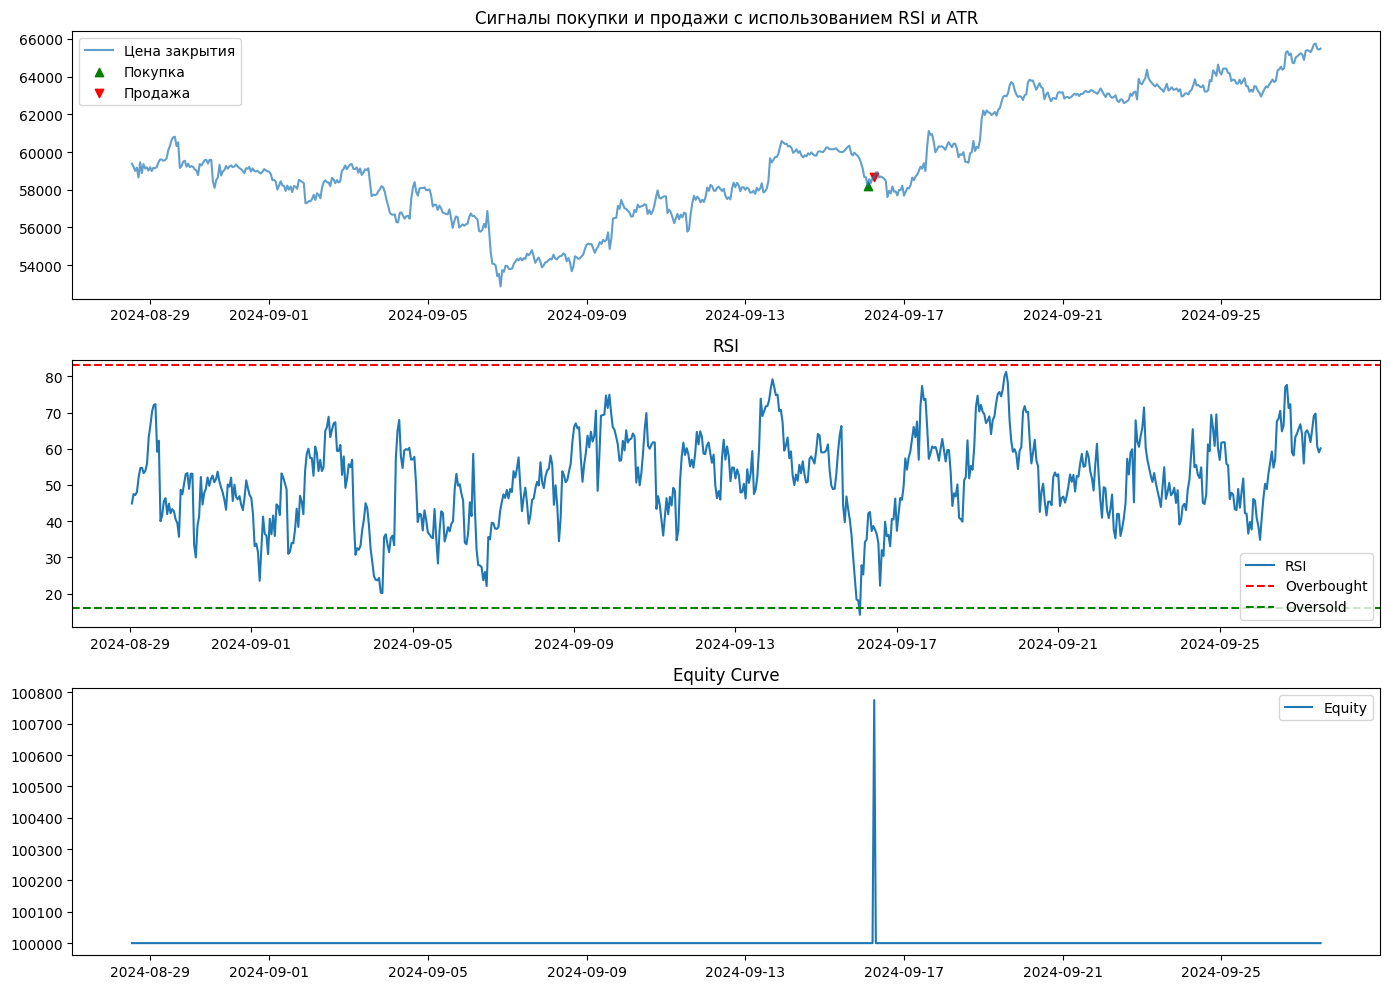

In [ ]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real, Integer

# Параметры стратегии
RSI_PERIOD = 2
RSI_OVERBOUGHT = 70
RSI_OVERSOLD = 30
ATR_PERIOD = 2
STOP_LOSS_MULTIPLIER = 1.5
TAKE_PROFIT_MULTIPLIER = 3

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Функция для расчета доходности стратегии
def calculate_strategy_return(params):
    rsi_period, rsi_oversold, rsi_overbought, atr_period, stop_loss_multiplier, take_profit_multiplier = params

    # Рассчитываем RSI
    data['RSI'] = ta.RSI(data['close'], timeperiod=int(rsi_period))

    # Рассчитываем ATR
    data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=int(atr_period))

    in_position = False
    entry_price = 0
    data['signal'] = 0
    data['price_entry'] = np.nan
    data['price_exit'] = np.nan
    data['trade_result'] = np.nan
    data['equity'] = 100000.0

    for i in range(1, len(data)):
        if not in_position:  # Если мы не в позиции
            # Условие для покупки: RSI ниже уровня покупки
            if data['RSI'][i] < rsi_oversold:
                entry_price = data['close'][i]
                atr_value = data['ATR'][i]  # Используем обычный ATR
                stop_loss = entry_price - stop_loss_multiplier * atr_value  # Стоп-лосс на основе ATR
                take_profit = entry_price + take_profit_multiplier * atr_value  # Тейк-профит на основе ATR
                data.at[i, 'signal'] = 1  # Сигнал на покупку
                data.at[i, 'price_entry'] = entry_price
                in_position = True
        else:  # Если мы в позиции
            # Проверяем, достигли ли стоп-лосса или тейк-профита
            if data['low'][i] <= stop_loss:  # Стоп-лосс
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = stop_loss
                data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            elif data['high'][i] >= take_profit:  # Тейк-профит
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = take_profit
                data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            # Продаем, если RSI выше уровня продажи
            elif data['RSI'][i] > rsi_overbought:
                exit_price = data['close'][i]
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = exit_price
                data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            else:
                data.at[i, 'equity'] = data.iloc[i-1]['equity']

    # Возвращаем отрицательную доходность (поскольку gp_minimize ищет минимум функции)
    return -data['equity'].iloc[-1] / data['equity'].iloc[0]

# Определение пространства поиска
search_space = [
    Integer(2, 14, name='rsi_period'),  # Диапазон для периода RSI
    Integer(10, 40, name='rsi_oversold'),
    Integer(60, 90, name='rsi_overbought'),
    Integer(2, 14, name='atr_period'),  # Диапазон для периода ATR
    Real(0.5, 2.0, name='stop_loss_multiplier'),
    Real(1.0, 4.0, name='take_profit_multiplier')
]

# Байесовская оптимизация
result = gp_minimize(calculate_strategy_return, search_space, n_calls=50, random_state=42)

# Вывод оптимальных параметров
optimal_params = result.x
print("Оптимальные параметры:")
print(f"RSI Period: {optimal_params[0]}")
print(f"RSI Oversold: {optimal_params[1]}")
print(f"RSI Overbought: {optimal_params[2]}")
print(f"ATR Period: {optimal_params[3]}")
print(f"Stop Loss Multiplier: {optimal_params[4]:.2f}")
print(f"Take Profit Multiplier: {optimal_params[5]:.2f}")

# Применение оптимальных параметров к стратегии
rsi_period, rsi_oversold, rsi_overbought, atr_period, stop_loss_multiplier, take_profit_multiplier = optimal_params

# Рассчитываем RSI с оптимальным периодом
data['RSI'] = ta.RSI(data['close'], timeperiod=int(rsi_period))

# Рассчитываем ATR с оптимальным периодом
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=int(atr_period))

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах
data['equity'] = 100000.0  # Начальный капитал (изменим тип на float)

# Статусы для управления сделками
in_position = False
entry_price = 0
initial_equity = data['equity'].iloc[0]

for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки
        if data['RSI'][i] < rsi_oversold:
            entry_price = data['close'][i]
            atr_value = data['ATR'][i]  # Используем обычный ATR
            stop_loss = entry_price - stop_loss_multiplier * atr_value  # Стоп-лосс на основе ATR
            take_profit = entry_price + take_profit_multiplier * atr_value  # Тейк-профит на основе ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        # Продаем, если RSI выше уровня продажи
        elif data['RSI'][i] > rsi_overbought:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        else:
            data.at[i, 'equity'] = data.iloc[i-1]['equity']

# Вывод результатов сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 10))

# График цены закрытия
plt.subplot(3, 1, 1)
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI и ATR')
plt.legend()

# График RSI
plt.subplot(3, 1, 2)
plt.plot(data['date'], data['RSI'], label='RSI')
plt.axhline(y=rsi_overbought, color='r', linestyle='--', label='Overbought')
plt.axhline(y=rsi_oversold, color='g', linestyle='--', label='Oversold')
plt.title('RSI')
plt.legend()

# График доходности
plt.subplot(3, 1, 3)
plt.plot(data['date'], data['equity'], label='Equity')
plt.title('Equity Curve')
plt.legend()

plt.tight_layout()
plt.show()

Оптимальные параметры:
RSI Oversold: 34
RSI Overbought: 66
Stop Loss Multiplier: 1.67
Take Profit Multiplier: 2.79
Всего сделок: 90
Успешные сделки: 53
Процент успешных сделок: 58.89%
Общая доходность: 8.90%
Максимальная прибыль: 2.96%
Максимальный убыток: -2.73%


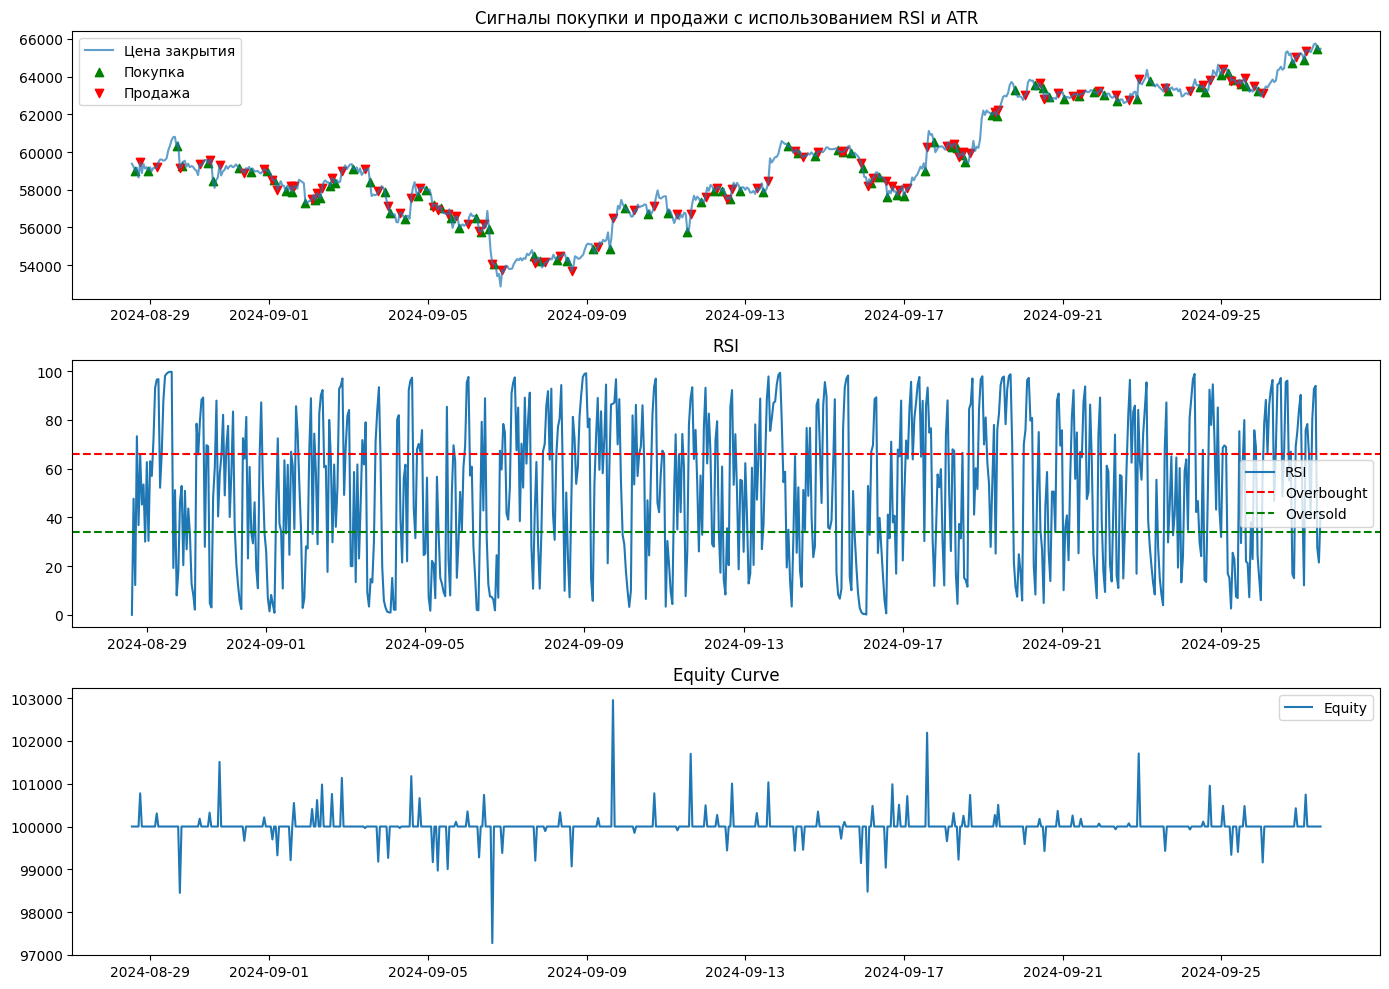

In [ ]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real, Integer

# Параметры стратегии
RSI_PERIOD = 2
ATR_PERIOD = 2

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Функция для расчета доходности стратегии
def calculate_strategy_return(params):
    rsi_oversold, rsi_overbought, stop_loss_multiplier, take_profit_multiplier = params

    # Рассчитываем RSI
    data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

    # Рассчитываем ATR
    data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

    in_position = False
    entry_price = 0
    data['signal'] = 0
    data['price_entry'] = np.nan
    data['price_exit'] = np.nan
    data['trade_result'] = np.nan
    data['equity'] = 100000.0

    for i in range(1, len(data)):
        if not in_position:  # Если мы не в позиции
            # Условие для покупки: RSI ниже уровня покупки
            if data['RSI'][i] < rsi_oversold:
                entry_price = data['close'][i]
                atr_value = data['ATR'][i]  # Используем обычный ATR
                stop_loss = entry_price - stop_loss_multiplier * atr_value  # Стоп-лосс на основе ATR
                take_profit = entry_price + take_profit_multiplier * atr_value  # Тейк-профит на основе ATR
                data.at[i, 'signal'] = 1  # Сигнал на покупку
                data.at[i, 'price_entry'] = entry_price
                in_position = True
        else:  # Если мы в позиции
            # Проверяем, достигли ли стоп-лосса или тейк-профита
            if data['low'][i] <= stop_loss:  # Стоп-лосс
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = stop_loss
                data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            elif data['high'][i] >= take_profit:  # Тейк-профит
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = take_profit
                data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            # Продаем, если RSI выше уровня продажи
            elif data['RSI'][i] > rsi_overbought:
                exit_price = data['close'][i]
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = exit_price
                data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            else:
                data.at[i, 'equity'] = data.iloc[i-1]['equity']

    # Возвращаем отрицательную доходность (поскольку gp_minimize ищет минимум функции)
    return -data['equity'].iloc[-1] / data['equity'].iloc[0]

# Определение пространства поиска
search_space = [
    Integer(10, 40, name='rsi_oversold'),
    Integer(60, 90, name='rsi_overbought'),
    Real(0.5, 2.0, name='stop_loss_multiplier'),
    Real(1.0, 4.0, name='take_profit_multiplier')
]

# Байесовская оптимизация
result = gp_minimize(calculate_strategy_return, search_space, n_calls=50, random_state=42)

# Вывод оптимальных параметров
optimal_params = result.x
print("Оптимальные параметры:")
print(f"RSI Oversold: {optimal_params[0]}")
print(f"RSI Overbought: {optimal_params[1]}")
print(f"Stop Loss Multiplier: {optimal_params[2]:.2f}")
print(f"Take Profit Multiplier: {optimal_params[3]:.2f}")

# Применение оптимальных параметров к стратегии
rsi_oversold, rsi_overbought, stop_loss_multiplier, take_profit_multiplier = optimal_params

# Рассчитываем RSI с фиксированным периодом
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем ATR с фиксированным периодом
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах
data['equity'] = 100000.0  # Начальный капитал (изменим тип на float)

# Статусы для управления сделками
in_position = False
entry_price = 0
initial_equity = data['equity'].iloc[0]

# Статусы для управления сделками
in_position = False
entry_price = 0
initial_equity = data['equity'].iloc[0]

for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки
        if data['RSI'][i] < rsi_oversold:
            entry_price = data['close'][i]
            atr_value = data['ATR'][i]  # Используем обычный ATR
            stop_loss = entry_price - stop_loss_multiplier * atr_value  # Стоп-лосс на основе ATR
            take_profit = entry_price + take_profit_multiplier * atr_value  # Тейк-профит на основе ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        # Продаем, если RSI выше уровня продажи
        elif data['RSI'][i] > rsi_overbought:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        else:
            data.at[i, 'equity'] = data.iloc[i-1]['equity']

# Вывод результатов сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 10))

# График цены закрытия
plt.subplot(3, 1, 1)
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI и ATR')
plt.legend()

# График RSI
plt.subplot(3, 1, 2)
plt.plot(data['date'], data['RSI'], label='RSI')
plt.axhline(y=rsi_overbought, color='r', linestyle='--', label='Overbought')
plt.axhline(y=rsi_oversold, color='g', linestyle='--', label='Oversold')
plt.title('RSI')
plt.legend()

# График доходности
plt.subplot(3, 1, 3)
plt.plot(data['date'], data['equity'], label='Equity')
plt.title('Equity Curve')
plt.legend()

plt.tight_layout()
plt.show()

Оптимальные параметры:
RSI Oversold: 34
RSI Overbought: 66
Stop Loss Multiplier: 1.67
Take Profit Multiplier: 2.79
Всего сделок: 19
Успешные сделки: 13
Процент успешных сделок: 68.42%
Общая доходность: 4.18%
Максимальная прибыль: 1.70%
Максимальный убыток: -3.65%


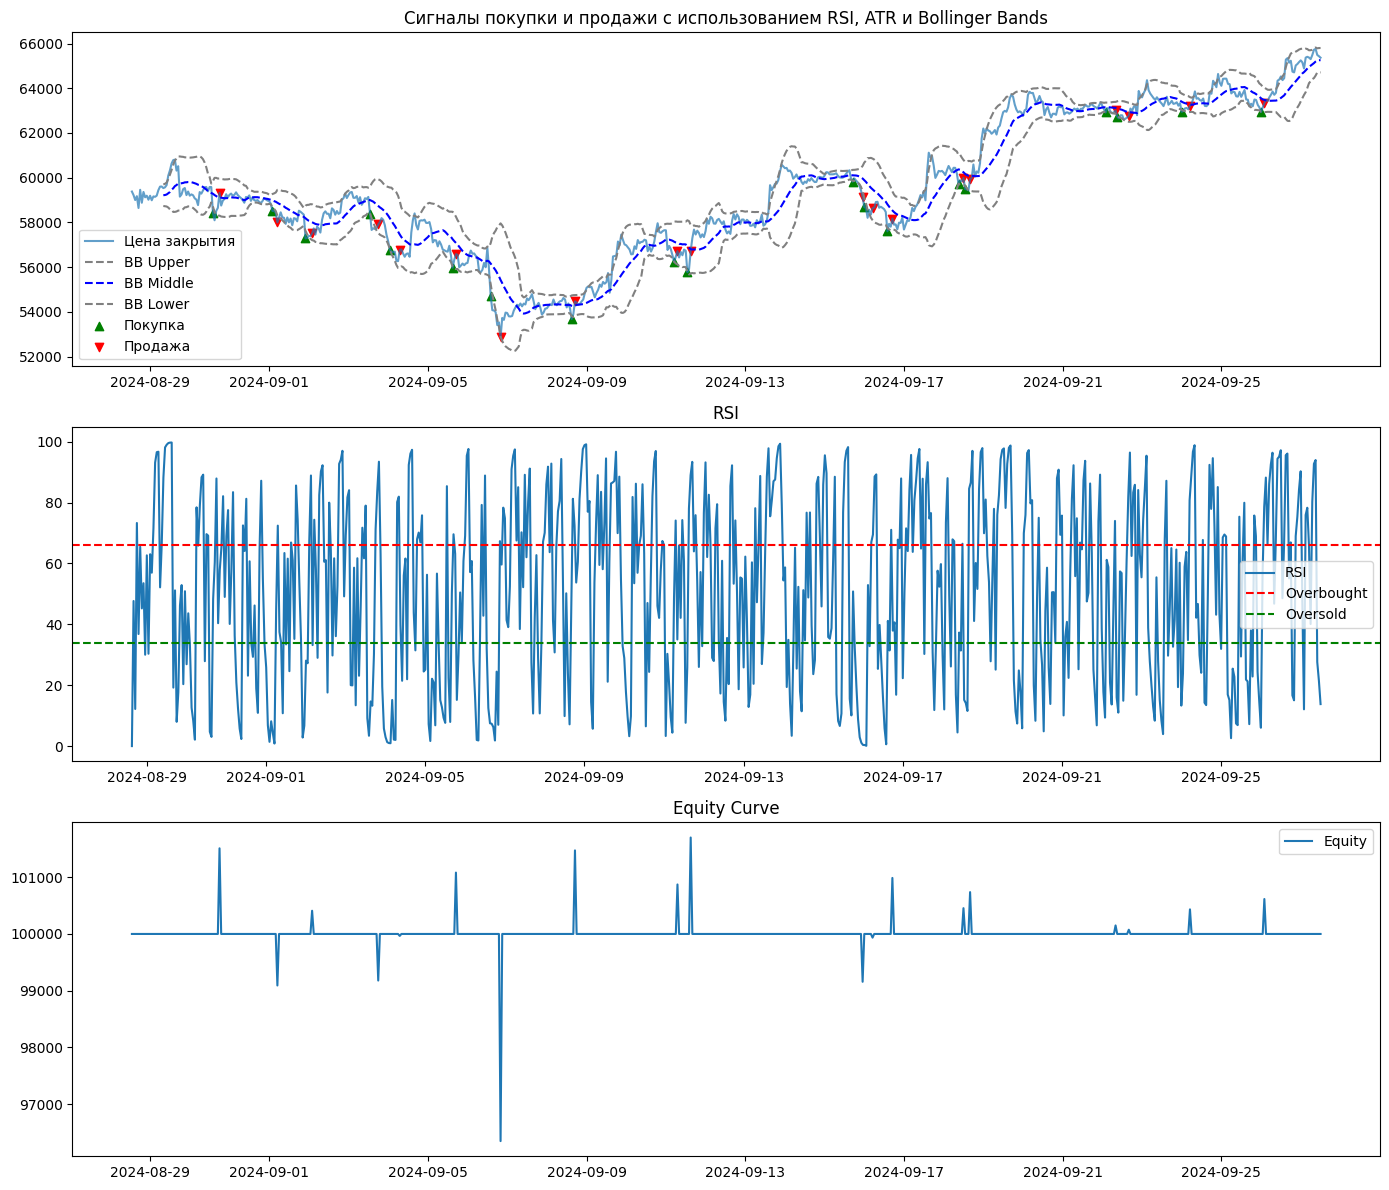

In [ ]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real, Integer

# Параметры стратегии
RSI_PERIOD = 2
ATR_PERIOD = 2
BOLLINGER_PERIOD = 20
BOLLINGER_STD = 2

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Функция для расчета доходности стратегии
def calculate_strategy_return(params):
    rsi_oversold, rsi_overbought, stop_loss_multiplier, take_profit_multiplier = params

    # Рассчитываем RSI
    data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

    # Рассчитываем ATR
    data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

    # Рассчитываем Bollinger Bands
    data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['close'], timeperiod=BOLLINGER_PERIOD, nbdevup=BOLLINGER_STD, nbdevdn=BOLLINGER_STD, matype=0)

    in_position = False
    entry_price = 0
    data['signal'] = 0
    data['price_entry'] = np.nan
    data['price_exit'] = np.nan
    data['trade_result'] = np.nan
    data['equity'] = 100000.0

    for i in range(1, len(data)):
        if not in_position:  # Если мы не в позиции
            # Условие для покупки: RSI ниже уровня покупки и цена ниже нижней полосы Bollinger Bands
            if data['RSI'][i] < rsi_oversold and data['close'][i] < data['BB_lower'][i]:
                entry_price = data['close'][i]
                atr_value = data['ATR'][i]  # Используем обычный ATR
                stop_loss = entry_price - stop_loss_multiplier * atr_value  # Стоп-лосс на основе ATR
                take_profit = entry_price + take_profit_multiplier * atr_value  # Тейк-профит на основе ATR
                data.at[i, 'signal'] = 1  # Сигнал на покупку
                data.at[i, 'price_entry'] = entry_price
                in_position = True
        else:  # Если мы в позиции
            # Проверяем, достигли ли стоп-лосса или тейк-профита
            if data['low'][i] <= stop_loss:  # Стоп-лосс
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = stop_loss
                data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            elif data['high'][i] >= take_profit:  # Тейк-профит
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = take_profit
                data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            # Продаем, если RSI выше уровня продажи или цена выше верхней полосы Bollinger Bands
            elif data['RSI'][i] > rsi_overbought or data['close'][i] > data['BB_upper'][i]:
                exit_price = data['close'][i]
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = exit_price
                data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            else:
                data.at[i, 'equity'] = data.iloc[i-1]['equity']

    # Возвращаем отрицательную доходность (поскольку gp_minimize ищет минимум функции)
    return -data['equity'].iloc[-1] / data['equity'].iloc[0]

# Определение пространства поиска
search_space = [
    Integer(10, 40, name='rsi_oversold'),
    Integer(60, 90, name='rsi_overbought'),
    Real(0.5, 2.0, name='stop_loss_multiplier'),
    Real(1.0, 4.0, name='take_profit_multiplier')
]

# Байесовская оптимизация
result = gp_minimize(calculate_strategy_return, search_space, n_calls=50, random_state=42)

# Вывод оптимальных параметров
optimal_params = result.x
print("Оптимальные параметры:")
print(f"RSI Oversold: {optimal_params[0]}")
print(f"RSI Overbought: {optimal_params[1]}")
print(f"Stop Loss Multiplier: {optimal_params[2]:.2f}")
print(f"Take Profit Multiplier: {optimal_params[3]:.2f}")

# Применение оптимальных параметров к стратегии
rsi_oversold, rsi_overbought, stop_loss_multiplier, take_profit_multiplier = optimal_params

# Рассчитываем RSI с фиксированным периодом
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем ATR с фиксированным периодом
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Рассчитываем Bollinger Bands
data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['close'], timeperiod=BOLLINGER_PERIOD, nbdevup=BOLLINGER_STD, nbdevdn=BOLLINGER_STD, matype=0)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах
data['equity'] = 100000.0  # Начальный капитал (изменим тип на float)

# Статусы для управления сделками
in_position = False
entry_price = 0
initial_equity = data['equity'].iloc[0]

for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и цена ниже нижней полосы Bollinger Bands
        if data['RSI'][i] < rsi_oversold and data['close'][i] < data['BB_lower'][i]:
            entry_price = data['close'][i]
            atr_value = data['ATR'][i]  # Используем обычный ATR
            stop_loss = entry_price - stop_loss_multiplier * atr_value  # Стоп-лосс на основе ATR
            take_profit = entry_price + take_profit_multiplier * atr_value  # Тейк-профит на основе ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        # Продаем, если RSI выше уровня продажи или цена выше верхней полосы Bollinger Bands
        elif data['RSI'][i] > rsi_overbought or data['close'][i] > data['BB_upper'][i]:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        else:
            data.at[i, 'equity'] = data.iloc[i-1]['equity']

# Вывод результатов сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 12))

# График цены закрытия и Bollinger Bands
plt.subplot(3, 1, 1)
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
plt.plot(data['date'], data['BB_upper'], label='BB Upper', linestyle='--', color='gray')
plt.plot(data['date'], data['BB_middle'], label='BB Middle', linestyle='--', color='blue')
plt.plot(data['date'], data['BB_lower'], label='BB Lower', linestyle='--', color='gray')
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI, ATR и Bollinger Bands')
plt.legend()

# График RSI
plt.subplot(3, 1, 2)
plt.plot(data['date'], data['RSI'], label='RSI')
plt.axhline(y=rsi_overbought, color='r', linestyle='--', label='Overbought')
plt.axhline(y=rsi_oversold, color='g', linestyle='--', label='Oversold')
plt.title('RSI')
plt.legend()

# График доходности
plt.subplot(3, 1, 3)
plt.plot(data['date'], data['equity'], label='Equity')
plt.title('Equity Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from skopt import gp_minimize
from skopt.space import Real, Integer

# Параметры стратегии
RSI_PERIOD = 2
ATR_PERIOD = 2

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Функция для расчета доходности стратегии
def calculate_strategy_return(params):
    rsi_oversold, rsi_overbought, stop_loss_multiplier, take_profit_multiplier, bollinger_period, bollinger_std = params

    # Рассчитываем RSI
    data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

    # Рассчитываем ATR
    data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

    # Применяем фильтр Калмана к значениям ATR
    data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

    # Рассчитываем Bollinger Bands
    data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['close'], timeperiod=int(bollinger_period), nbdevup=bollinger_std, nbdevdn=bollinger_std, matype=0)

    # Применяем фильтр Калмана к значениям Bollinger Bands
    data['BB_upper_Kalman'] = apply_kalman_filter(data['BB_upper'])
    data['BB_lower_Kalman'] = apply_kalman_filter(data['BB_lower'])

    in_position = False
    entry_price = 0
    data['signal'] = 0
    data['price_entry'] = np.nan
    data['price_exit'] = np.nan
    data['trade_result'] = np.nan
    data['equity'] = 100000.0

    for i in range(1, len(data)):
        if not in_position:  # Если мы не в позиции
            # Условие для покупки: RSI ниже уровня покупки и цена ниже нижней полосы Bollinger Bands
            if data['RSI'][i] < rsi_oversold and data['close'][i] < data['BB_lower_Kalman'][i]:
                entry_price = data['close'][i]
                atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
                stop_loss = entry_price - stop_loss_multiplier * atr_value  # Стоп-лосс на основе сглаженного ATR
                take_profit = entry_price + take_profit_multiplier * atr_value  # Тейк-профит на основе сглаженного ATR
                data.at[i, 'signal'] = 1  # Сигнал на покупку
                data.at[i, 'price_entry'] = entry_price
                in_position = True
        else:  # Если мы в позиции
            # Проверяем, достигли ли стоп-лосса или тейк-профита
            if data['low'][i] <= stop_loss:  # Стоп-лосс
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = stop_loss
                data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            elif data['high'][i] >= take_profit:  # Тейк-профит
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = take_profit
                data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            # Продаем, если RSI выше уровня продажи или цена выше верхней полосы Bollinger Bands
            elif data['RSI'][i] > rsi_overbought or data['close'][i] > data['BB_upper_Kalman'][i]:
                exit_price = data['close'][i]
                data.at[i, 'signal'] = -1  # Сигнал на продажу
                data.at[i, 'price_exit'] = exit_price
                data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
                data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
                in_position = False
            else:
                data.at[i, 'equity'] = data.iloc[i-1]['equity']

    # Возвращаем отрицательную доходность (поскольку gp_minimize ищет минимум функции)
    return -data['equity'].iloc[-1] / data['equity'].iloc[0]

# Определение пространства поиска
search_space = [
    Integer(10, 40, name='rsi_oversold'),
    Integer(60, 90, name='rsi_overbought'),
    Real(0.5, 2.0, name='stop_loss_multiplier'),
    Real(1.0, 4.0, name='take_profit_multiplier'),
    Integer(10, 30, name='bollinger_period'),  # Диапазон для периода Bollinger Bands
    Real(1.0, 3.0, name='bollinger_std')  # Диапазон для стандартных отклонений Bollinger Bands
]

# Байесовская оптимизация
result = gp_minimize(calculate_strategy_return, search_space, n_calls=50, random_state=11)

# Вывод оптимальных параметров
optimal_params = result.x
print("Оптимальные параметры:")
print(f"RSI Oversold: {optimal_params[0]}")
print(f"RSI Overbought: {optimal_params[1]}")
print(f"Stop Loss Multiplier: {optimal_params[2]:.2f}")
print(f"Take Profit Multiplier: {optimal_params[3]:.2f}")
print(f"Bollinger Period: {optimal_params[4]}")
print(f"Bollinger Std: {optimal_params[5]:.2f}")

# Применение оптимальных параметров к стратегии
rsi_oversold, rsi_overbought, stop_loss_multiplier, take_profit_multiplier, bollinger_period, bollinger_std = optimal_params

# Рассчитываем RSI с фиксированным периодом
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем ATR с фиксированным периодом
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Рассчитываем Bollinger Bands с оптимальными параметрами
data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['close'], timeperiod=int(bollinger_period), nbdevup=bollinger_std, nbdevdn=bollinger_std, matype=0)

# Применяем фильтр Калмана к значениям Bollinger Bands
data['BB_upper_Kalman'] = apply_kalman_filter(data['BB_upper'])
data['BB_lower_Kalman'] = apply_kalman_filter(data['BB_lower'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах
data['equity'] = 100000.0  # Начальный капитал (изменим тип на float)

# Статусы для управления сделками
in_position = False
entry_price = 0
initial_equity = data['equity'].iloc[0]

for i in range(1, len(data)):
    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и цена ниже нижней полосы Bollinger Bands
        if data['RSI'][i] < rsi_oversold and data['close'][i] < data['BB_lower_Kalman'][i]:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - stop_loss_multiplier * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + take_profit_multiplier * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        # Продаем, если RSI выше уровня продажи или цена выше верхней полосы Bollinger Bands
        elif data['RSI'][i] > rsi_overbought or data['close'][i] > data['BB_upper_Kalman'][i]:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        else:
            data.at[i, 'equity'] = data.iloc[i-1]['equity']

# Вывод результатов сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 12))

# График цены закрытия и Bollinger Bands
plt.subplot(3, 1, 1)
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
plt.plot(data['date'], data['BB_upper_Kalman'], label='BB Upper (Kalman)', linestyle='--', color='gray')
plt.plot(data['date'], data['BB_middle'], label='BB Middle', linestyle='--', color='blue')
plt.plot(data['date'], data['BB_lower_Kalman'], label='BB Lower (Kalman)', linestyle='--', color='gray')
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI, ATR (Kalman) и Bollinger Bands (Kalman)')
plt.legend()

# График RSI
plt.subplot(3, 1, 2)
plt.plot(data['date'], data['RSI'], label='RSI')
plt.axhline(y=rsi_overbought, color='r', linestyle='--', label='Overbought')
plt.axhline(y=rsi_oversold, color='g', linestyle='--', label='Oversold')
plt.title('RSI')
plt.legend()

# График доходности
plt.subplot(3, 1, 3)
plt.plot(data['date'], data['equity'], label='Equity')
plt.title('Equity Curve')
plt.legend()

plt.tight_layout()
plt.show()

Оптимальные параметры:
RSI Oversold: 12
RSI Overbought: 80
Stop Loss Multiplier: 0.79
Take Profit Multiplier: 3.78
Bollinger Period: 12
Bollinger Std: 1.45
Всего сделок: 0
Успешные сделки: 0


ZeroDivisionError: division by zero

<ipython-input-51-c9d307aa19a1>:46: RuntimeWarning: invalid value encountered in divide
  state_probabilities /= state_probabilities.sum()


Всего сделок: 121
Успешные сделки: 56
Процент успешных сделок: 46.28%
Общая доходность: 12.93%
Максимальная прибыль: 2.91%
Максимальный убыток: -1.29%


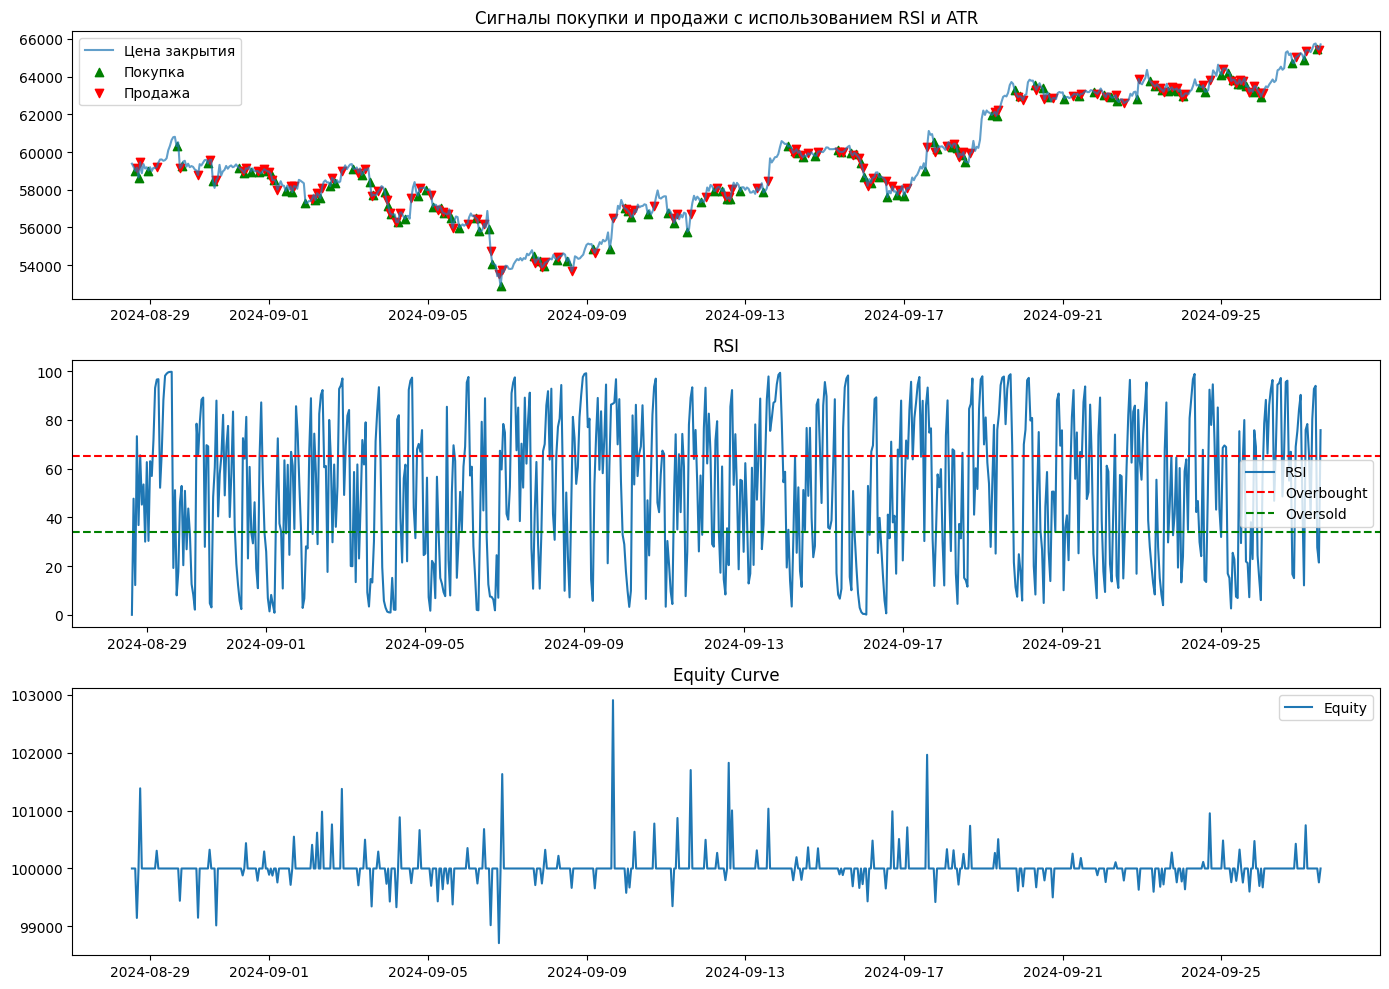

In [ ]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Параметры стратегии
RSI_PERIOD = 2
RSI_OVERBOUGHT = 65
RSI_OVERSOLD = 34
ATR_PERIOD = 2
STOP_LOSS_MULTIPLIER = 0.6
TAKE_PROFIT_MULTIPLIER = 2.5

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах
data['equity'] = 100000.0  # Начальный капитал (изменим тип на float)
data['position_size'] = np.nan  # Размер позиции

# Статусы для управления сделками
in_position = False
entry_price = 0
initial_equity = data['equity'].iloc[0]

# Байесовский метод для управления рисками
def update_market_state_probabilities(data, state_probabilities, new_data):
    likelihoods = np.array([
        norm.pdf(new_data, loc=0.01, scale=0.02),  # Тренд вверх
        norm.pdf(new_data, loc=-0.01, scale=0.02),  # Тренд вниз
        norm.pdf(new_data, loc=0, scale=0.01)  # Флэт
    ])
    state_probabilities *= likelihoods
    state_probabilities /= state_probabilities.sum()
    return state_probabilities

# Инициализация априорных вероятностей состояний рынка
state_probabilities = np.array([0.3, 0.4, 0.3])  # Тренд вверх, тренд вниз, флэт

for i in range(1, len(data)):
    # Обновляем вероятности состояний рынка
    state_probabilities = update_market_state_probabilities(data, state_probabilities, data['close'][i] - data['close'][i-1])

    # Динамический размер позиции в зависимости от состояния рынка
    position_size = state_probabilities[0] * 2 + state_probabilities[2] * 1  # Увеличиваем размер позиции при тренде вверх, уменьшаем при флэте

    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки
        if data['RSI'][i] < RSI_OVERSOLD:
            entry_price = data['close'][i]
            atr_value = data['ATR'][i]  # Используем обычный ATR
            stop_loss = entry_price - STOP_LOSS_MULTIPLIER * atr_value  # Стоп-лосс на основе ATR
            take_profit = entry_price + TAKE_PROFIT_MULTIPLIER * atr_value  # Тейк-профит на основе ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            data.at[i, 'position_size'] = position_size
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        # Продаем, если RSI выше уровня продажи
        elif data['RSI'][i] > RSI_OVERBOUGHT:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        else:
            data.at[i, 'equity'] = data.iloc[i-1]['equity']

# Вывод результатов сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 10))

# График цены закрытия
plt.subplot(3, 1, 1)
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI и ATR')
plt.legend()

# График RSI
plt.subplot(3, 1, 2)
plt.plot(data['date'], data['RSI'], label='RSI')
plt.axhline(y=RSI_OVERBOUGHT, color='r', linestyle='--', label='Overbought')
plt.axhline(y=RSI_OVERSOLD, color='g', linestyle='--', label='Oversold')
plt.title('RSI')
plt.legend()

# График доходности
plt.subplot(3, 1, 3)
plt.plot(data['date'], data['equity'], label='Equity')
plt.title('Equity Curve')
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-52-27c1df08039e>:51: RuntimeWarning: invalid value encountered in divide
  state_probabilities /= state_probabilities.sum()


Всего сделок: 55
Успешные сделки: 31
Процент успешных сделок: 56.36%
Общая доходность: 4.42%
Максимальная прибыль: 1.83%
Максимальный убыток: -2.19%


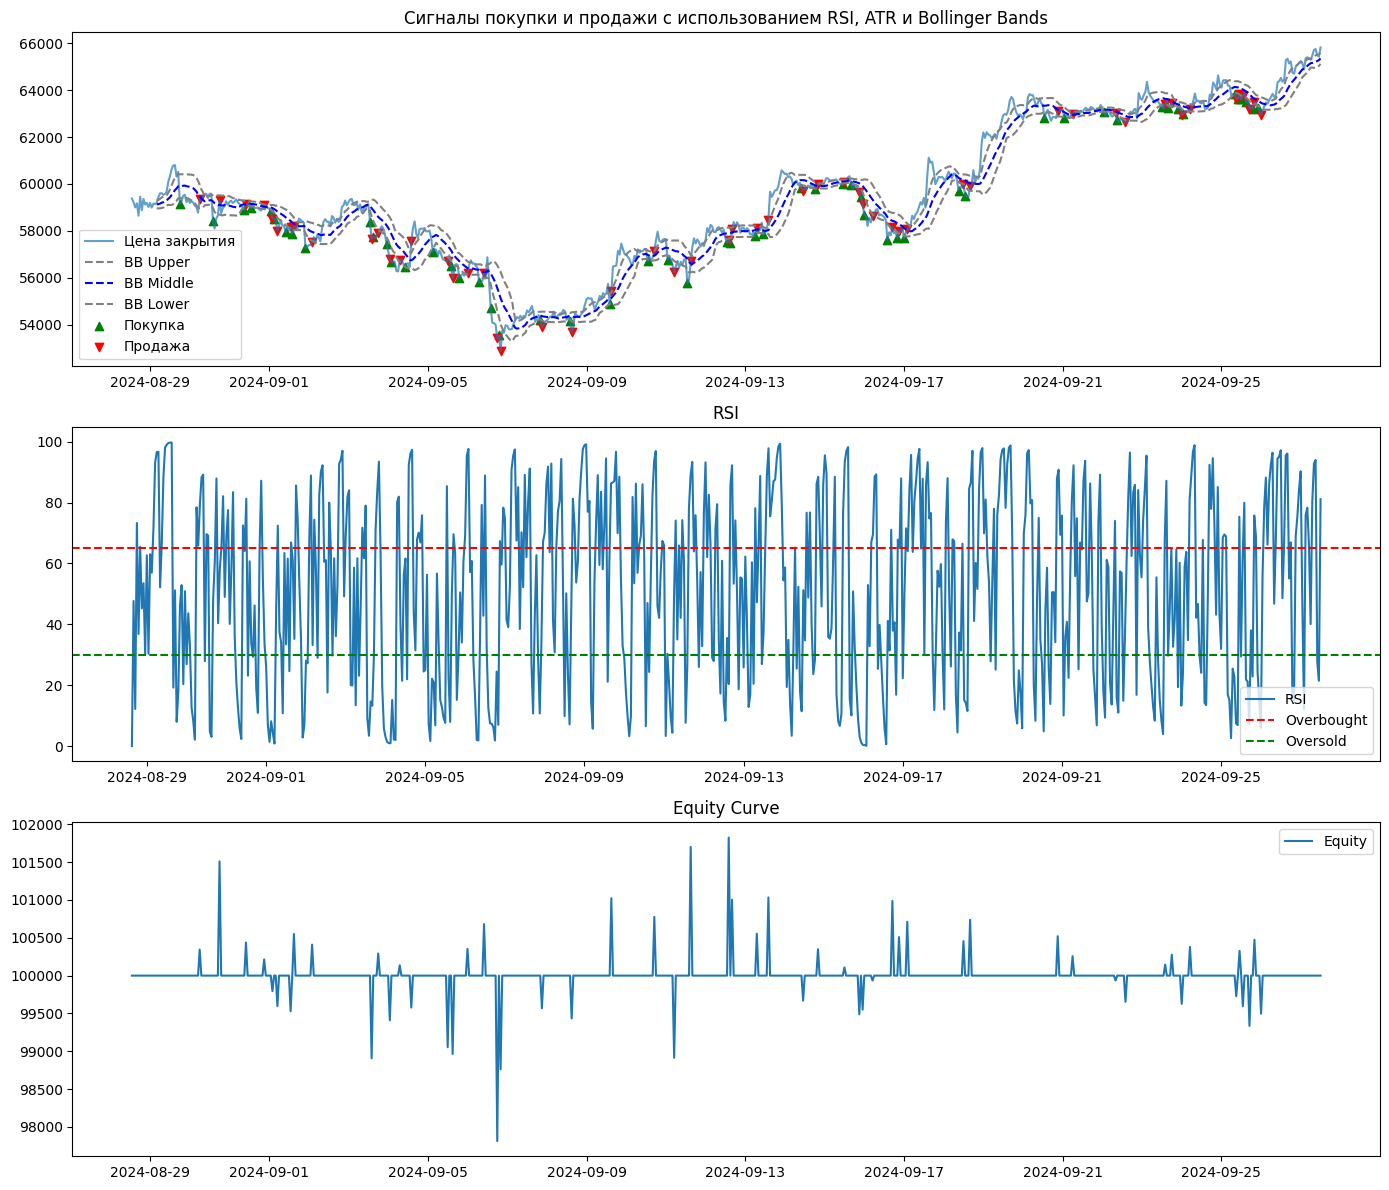

In [ ]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Параметры стратегии
RSI_PERIOD = 2
RSI_OVERBOUGHT = 65
RSI_OVERSOLD = 30
ATR_PERIOD = 2
STOP_LOSS_MULTIPLIER = 1
TAKE_PROFIT_MULTIPLIER = 2.5
BOLLINGER_PERIOD = 16
BOLLINGER_STD = 0.9

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Рассчитываем Bollinger Bands
data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['close'], timeperiod=BOLLINGER_PERIOD, nbdevup=BOLLINGER_STD, nbdevdn=BOLLINGER_STD, matype=0)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах
data['equity'] = 100000.0  # Начальный капитал (изменим тип на float)
data['position_size'] = np.nan  # Размер позиции

# Статусы для управления сделками
in_position = False
entry_price = 0
initial_equity = data['equity'].iloc[0]

# Байесовский метод для управления рисками
def update_market_state_probabilities(data, state_probabilities, new_data):
    likelihoods = np.array([
        norm.pdf(new_data, loc=0.01, scale=0.02),  # Тренд вверх
        norm.pdf(new_data, loc=-0.01, scale=0.02),  # Тренд вниз
        norm.pdf(new_data, loc=0, scale=0.01)  # Флэт
    ])
    state_probabilities *= likelihoods
    state_probabilities /= state_probabilities.sum()
    return state_probabilities

# Инициализация априорных вероятностей состояний рынка
state_probabilities = np.array([0.3, 0.4, 0.3])  # Тренд вверх, тренд вниз, флэт

for i in range(1, len(data)):
    # Обновляем вероятности состояний рынка
    state_probabilities = update_market_state_probabilities(data, state_probabilities, data['close'][i] - data['close'][i-1])

    # Динамический размер позиции в зависимости от состояния рынка
    position_size = state_probabilities[0] * 2 + state_probabilities[2] * 1  # Увеличиваем размер позиции при тренде вверх, уменьшаем при флэте

    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и цена ниже нижней полосы Bollinger Bands
        if data['RSI'][i] < RSI_OVERSOLD and data['close'][i] < data['BB_lower'][i]:
            entry_price = data['close'][i]
            atr_value = data['ATR'][i]  # Используем обычный ATR
            stop_loss = entry_price - STOP_LOSS_MULTIPLIER * atr_value  # Стоп-лосс на основе ATR
            take_profit = entry_price + TAKE_PROFIT_MULTIPLIER * atr_value  # Тейк-профит на основе ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            data.at[i, 'position_size'] = position_size
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        # Продаем, если RSI выше уровня продажи или цена выше верхней полосы Bollinger Bands
        elif data['RSI'][i] > RSI_OVERBOUGHT or data['close'][i] > data['BB_upper'][i]:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        else:
            data.at[i, 'equity'] = data.iloc[i-1]['equity']

# Вывод результатов сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 12))

# График цены закрытия и Bollinger Bands
plt.subplot(3, 1, 1)
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
plt.plot(data['date'], data['BB_upper'], label='BB Upper', linestyle='--', color='gray')
plt.plot(data['date'], data['BB_middle'], label='BB Middle', linestyle='--', color='blue')
plt.plot(data['date'], data['BB_lower'], label='BB Lower', linestyle='--', color='gray')
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI, ATR и Bollinger Bands')
plt.legend()

# График RSI
plt.subplot(3, 1, 2)
plt.plot(data['date'], data['RSI'], label='RSI')
plt.axhline(y=RSI_OVERBOUGHT, color='r', linestyle='--', label='Overbought')
plt.axhline(y=RSI_OVERSOLD, color='g', linestyle='--', label='Oversold')
plt.title('RSI')
plt.legend()

# График доходности
plt.subplot(3, 1, 3)
plt.plot(data['date'], data['equity'], label='Equity')
plt.title('Equity Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from scipy.stats import norm

# Параметры стратегии
RSI_PERIOD = 2
RSI_OVERBOUGHT = 65
RSI_OVERSOLD = 30
ATR_PERIOD = 2
STOP_LOSS_MULTIPLIER = 1
TAKE_PROFIT_MULTIPLIER = 2.5
BOLLINGER_PERIOD = 16
BOLLINGER_STD = 0.9

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Рассчитываем Bollinger Bands
data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['close'], timeperiod=BOLLINGER_PERIOD, nbdevup=BOLLINGER_STD, nbdevdn=BOLLINGER_STD, matype=0)

# Применяем фильтр Калмана к значениям Bollinger Bands
data['BB_upper_Kalman'] = apply_kalman_filter(data['BB_upper'])
data['BB_lower_Kalman'] = apply_kalman_filter(data['BB_lower'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах
data['equity'] = 100000.0  # Начальный капитал (изменим тип на float)
data['position_size'] = np.nan  # Размер позиции

# Статусы для управления сделками
in_position = False
entry_price = 0
initial_equity = data['equity'].iloc[0]

# Байесовский метод для управления рисками
def update_market_state_probabilities(data, state_probabilities, new_data):
    likelihoods = np.array([
        norm.pdf(new_data, loc=0.01, scale=0.02),  # Тренд вверх
        norm.pdf(new_data, loc=-0.01, scale=0.02),  # Тренд вниз
        norm.pdf(new_data, loc=0, scale=0.01)  # Флэт
    ])
    state_probabilities *= likelihoods
    state_probabilities /= state_probabilities.sum()
    return state_probabilities

# Инициализация априорных вероятностей состояний рынка
state_probabilities = np.array([0.3, 0.4, 0.3])  # Тренд вверх, тренд вниз, флэт

for i in range(1, len(data)):
    # Обновляем вероятности состояний рынка
    state_probabilities = update_market_state_probabilities(data, state_probabilities, data['close'][i] - data['close'][i-1])

    # Динамический размер позиции в зависимости от состояния рынка
    position_size = state_probabilities[0] * 2 + state_probabilities[2] * 1  # Увеличиваем размер позиции при тренде вверх, уменьшаем при флэте

    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и цена ниже нижней полосы Bollinger Bands
        if data['RSI'][i] < RSI_OVERSOLD and data['close'][i] < data['BB_lower_Kalman'][i]:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - STOP_LOSS_MULTIPLIER * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + TAKE_PROFIT_MULTIPLIER * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            data.at[i, 'position_size'] = position_size
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        # Продаем, если RSI выше уровня продажи или цена выше верхней полосы Bollinger Bands
        elif data['RSI'][i] > RSI_OVERBOUGHT or data['close'][i] > data['BB_upper_Kalman'][i]:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        else:
            data.at[i, 'equity'] = data.iloc[i-1]['equity']

# Вывод результатов сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 12))

# График цены закрытия и Bollinger Bands
plt.subplot(3, 1, 1)
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
plt.plot(data['date'], data['BB_upper_Kalman'], label='BB Upper (Kalman)', linestyle='--', color='gray')
plt.plot(data['date'], data['BB_middle'], label='BB Middle', linestyle='--', color='blue')
plt.plot(data['date'], data['BB_lower_Kalman'], label='BB Lower (Kalman)', linestyle='--', color='gray')
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи с использованием RSI, ATR (Kalman) и Bollinger Bands (Kalman)')
plt.legend()

# График RSI
plt.subplot(3, 1, 2)
plt.plot(data['date'], data['RSI'], label='RSI')
plt.axhline(y=RSI_OVERBOUGHT, color='r', linestyle='--', label='Overbought')
plt.axhline(y=RSI_OVERSOLD, color='g', linestyle='--', label='Oversold')
plt.title('RSI')
plt.legend()

# График доходности
plt.subplot(3, 1, 3)
plt.plot(data['date'], data['equity'], label='Equity')
plt.title('Equity Curve')
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-53-b971e1b1e5f3>:70: RuntimeWarning: invalid value encountered in divide
  state_probabilities /= state_probabilities.sum()


Всего сделок: 0
Успешные сделки: 0


ZeroDivisionError: division by zero

<ipython-input-54-fd8189ce5ed7>:66: RuntimeWarning: invalid value encountered in divide
  state_probabilities /= state_probabilities.sum()


Всего сделок: 44
Успешные сделки: 34
Процент успешных сделок: 77.27%
Общая доходность: 11.80%
Максимальная прибыль: 1.92%
Максимальный убыток: -2.18%


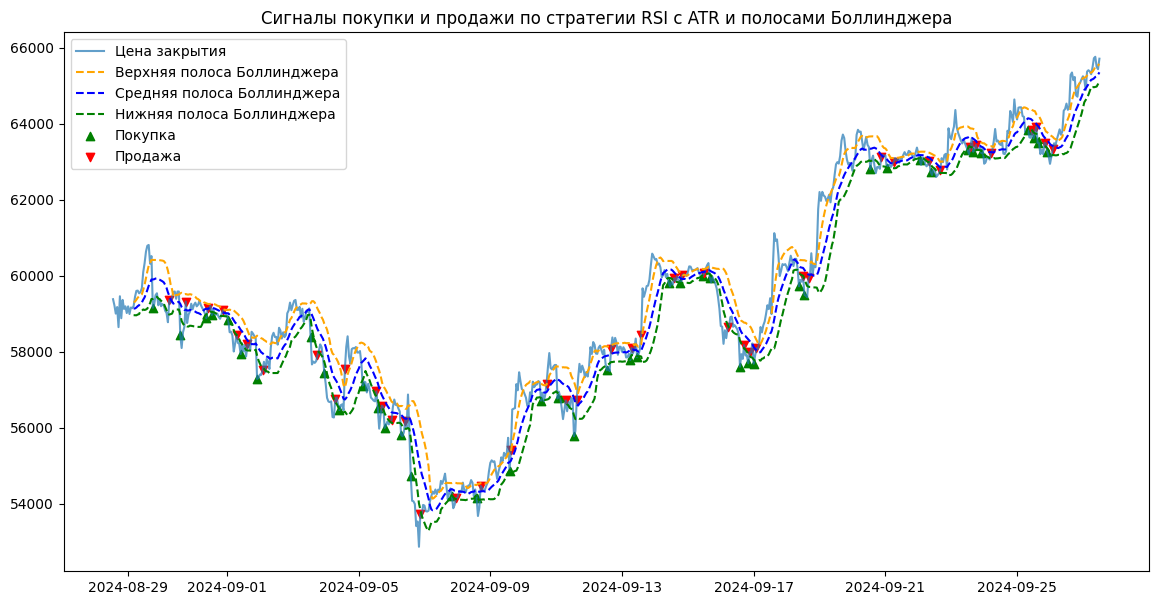

In [ ]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from scipy.stats import norm

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 30
RSI_SELL_LEVEL = 65
ATR_PERIOD = 2  # Период ATR для расчета волатильности
ATR_MULTIPLIER_SL = 1.0  # Множитель для стоп-лосса
ATR_MULTIPLIER_TP = 2.5  # Множитель для тейк-профита
BBANDS_PERIOD = 16  # Период для расчета полос Боллинджера
BBANDS_STDDEV = 0.9  # Стандартное отклонение для полос Боллинджера

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных (параметры можно настроить по своему усмотрению)
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем стандартный RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем стандартный ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_kalman'] = apply_kalman_filter(data['ATR'].values)

# Рассчитываем полосы Боллинджера
data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['close'], timeperiod=BBANDS_PERIOD, nbdevup=BBANDS_STDDEV, nbdevdn=BBANDS_STDDEV, matype=0)

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах
data['equity'] = 100000.0  # Начальный капитал (изменим тип на float)
data['position_size'] = np.nan  # Размер позиции

# Статусы для управления сделками
in_position = False
entry_price = 0
initial_equity = data['equity'].iloc[0]

# Байесовский метод для управления рисками
def update_market_state_probabilities(data, state_probabilities, new_data):
    likelihoods = np.array([
        norm.pdf(new_data, loc=0.01, scale=0.02),  # Тренд вверх
        norm.pdf(new_data, loc=-0.01, scale=0.02),  # Тренд вниз
        norm.pdf(new_data, loc=0, scale=0.01)  # Флэт
    ])
    state_probabilities *= likelihoods
    state_probabilities /= state_probabilities.sum()
    return state_probabilities

# Инициализация априорных вероятностей состояний рынка
state_probabilities = np.array([0.3, 0.4, 0.3])  # Тренд вверх, тренд вниз, флэт

for i in range(1, len(data)):
    # Обновляем вероятности состояний рынка
    state_probabilities = update_market_state_probabilities(data, state_probabilities, data['close'][i] - data['close'][i-1])

    # Динамический размер позиции в зависимости от состояния рынка
    position_size = state_probabilities[0] * 2 + state_probabilities[2] * 1  # Увеличиваем размер позиции при тренде вверх, уменьшаем при флэте

    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и цена касается нижней полосы Боллинджера
        if data['RSI'][i] < RSI_BUY_LEVEL and data['close'][i] <= data['BB_lower'][i]:
            entry_price = data['close'][i]
            atr_value = data['ATR_kalman'][i]  # Сглаженное значение ATR
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            data.at[i, 'position_size'] = position_size
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        # Продаем, если RSI выше уровня продажи или если цена касается верхней полосы Боллинджера
        elif data['RSI'][i] > RSI_SELL_LEVEL or data['close'][i] >= data['BB_upper'][i]:
            exit_price = data['close'][i]
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = exit_price
            data.at[i, 'trade_result'] = (exit_price - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        else:
            data.at[i, 'equity'] = data.iloc[i-1]['equity']

# Вывод результатов сделок
trades = data.dropna(subset=['trade_result'])
print(f"Всего сделок: {len(trades)}")
print(f"Успешные сделки: {len(trades[trades['trade_result'] > 0])}")
print(f"Процент успешных сделок: {len(trades[trades['trade_result'] > 0]) / len(trades) * 100:.2f}%")
print(f"Общая доходность: {trades['trade_result'].sum():.2f}%")
print(f"Максимальная прибыль: {trades['trade_result'].max():.2f}%")
print(f"Максимальный убыток: {trades['trade_result'].min():.2f}%")

# Визуализация
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['close'], label='Цена закрытия', alpha=0.7)
plt.plot(data['date'], data['BB_upper'], label='Верхняя полоса Боллинджера', linestyle='--', color='orange')
plt.plot(data['date'], data['BB_middle'], label='Средняя полоса Боллинджера', linestyle='--', color='blue')
plt.plot(data['date'], data['BB_lower'], label='Нижняя полоса Боллинджера', linestyle='--', color='green')
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == -1]
plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', label='Покупка', alpha=1)
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', label='Продажа', alpha=1)
plt.title('Сигналы покупки и продажи по стратегии RSI с ATR и полосами Боллинджера')
plt.legend()
plt.show()

In [ ]:
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from scipy.stats import norm

# Параметры стратегии
RSI_PERIOD = 2
RSI_BUY_LEVEL = 35
RSI_SELL_LEVEL = 65
STOCH_K_PERIOD = 10  # Период для K линии стохастика
STOCH_D_PERIOD = 2   # Период для D линии стохастика
STOCH_OVERBOUGHT = 75
STOCH_OVERSOLD = 25
ATR_PERIOD = 2  # Период ATR для расчета волатильности
ATR_MULTIPLIER_SL = 1.0  # Множитель для стоп-лосса
ATR_MULTIPLIER_TP = 2.5  # Множитель для тейк-профита

# Функция для применения фильтра Калмана
def apply_kalman_filter(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)
    state_means, _ = kf.filter(data)
    return state_means.flatten()

# Загрузка данных
data = get_data('kraken', '2024-04-01T00:00:00Z', '2024-05-31T00:00:00Z', '1h', 'BTC/USDT')
data.reset_index(inplace=True)

# Рассчитываем RSI
data['RSI'] = ta.RSI(data['close'], timeperiod=RSI_PERIOD)

# Рассчитываем стохастик
data['STOCH_K'], data['STOCH_D'] = ta.STOCH(data['high'], data['low'], data['close'],
                                             fastk_period=STOCH_K_PERIOD,
                                             slowk_period=STOCH_D_PERIOD,
                                             slowk_matype=0,
                                             slowd_period=STOCH_D_PERIOD,
                                             slowd_matype=0)

# Рассчитываем стандартный ATR
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=ATR_PERIOD)

# Применяем фильтр Калмана к значениям ATR
data['ATR_Kalman'] = apply_kalman_filter(data['ATR'])

# Создаем столбцы для сигналов и результатов
data['signal'] = 0  # 1 — покупка, -1 — продажа, 0 — нет сигнала
data['price_entry'] = np.nan  # Цена входа в сделку
data['price_exit'] = np.nan  # Цена выхода
data['trade_result'] = np.nan  # Результат сделки в процентах
data['equity'] = 100000.0  # Начальный капитал (изменим тип на float)
data['position_size'] = np.nan  # Размер позиции

# Статусы для управления сделками
in_position = False
entry_price = 0
initial_equity = data['equity'].iloc[0]

# Байесовский метод для управления рисками
def update_market_state_probabilities(data, state_probabilities, new_data):
    likelihoods = np.array([
        norm.pdf(new_data, loc=0.01, scale=0.02),  # Тренд вверх
        norm.pdf(new_data, loc=-0.01, scale=0.02),  # Тренд вниз
        norm.pdf(new_data, loc=0, scale=0.01)  # Флэт
    ])
    state_probabilities *= likelihoods
    state_probabilities /= state_probabilities.sum()
    return state_probabilities

# Инициализация априорных вероятностей состояний рынка
state_probabilities = np.array([0.3, 0.4, 0.3])  # Тренд вверх, тренд вниз, флэт

for i in range(1, len(data)):
    # Обновляем вероятности состояний рынка
    state_probabilities = update_market_state_probabilities(data, state_probabilities, data['close'][i] - data['close'][i-1])

    # Динамический размер позиции в зависимости от состояния рынка
    position_size = state_probabilities[0] * 2 + state_probabilities[2] * 1  # Увеличиваем размер позиции при тренде вверх, уменьшаем при флэте

    if not in_position:  # Если мы не в позиции
        # Условие для покупки: RSI ниже уровня покупки и стохастик показывает перепроданность
        if data['RSI'][i] < RSI_BUY_LEVEL and data['STOCH_K'][i] < STOCH_OVERSOLD and data['STOCH_D'][i] < STOCH_OVERSOLD:
            entry_price = data['close'][i]
            atr_value = data['ATR_Kalman'][i]  # Используем сглаженный ATR с фильтром Калмана
            stop_loss = entry_price - ATR_MULTIPLIER_SL * atr_value  # Стоп-лосс на основе сглаженного ATR
            take_profit = entry_price + ATR_MULTIPLIER_TP * atr_value  # Тейк-профит на основе сглаженного ATR
            data.at[i, 'signal'] = 1  # Сигнал на покупку
            data.at[i, 'price_entry'] = entry_price
            data.at[i, 'position_size'] = position_size
            in_position = True
    else:  # Если мы в позиции
        # Проверяем, достигли ли стоп-лосса или тейк-профита
        if data['low'][i] <= stop_loss:  # Стоп-лосс
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = stop_loss
            data.at[i, 'trade_result'] = (stop_loss - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)
            in_position = False
        elif data['high'][i] >= take_profit:  # Тейк-профит
            data.at[i, 'signal'] = -1  # Сигнал на продажу
            data.at[i, 'price_exit'] = take_profit
            data.at[i, 'trade_result'] = (take_profit - entry_price) / entry_price * 100
            data.at[i, 'equity'] = data.iloc[i-1]['equity'] * (1 + data.at[i, 'trade_result'] / 100)